In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import struct
import numpy as np




In [3]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [4]:
from glow import thops
from glow import modules
from glow import models
from glow.config import JsonConfig
import cv2

/home/huyu/workspace/fewshot/glow-pytorch/glow/utils.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/huyu/miniconda3/envs/pytorch/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/huyu/miniconda3/envs/pytorch/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/huyu/miniconda3/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/huyu/miniconda3/envs/pytorch/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/huyu/miniconda3/envs/pytorch/lib/python3.5/site-packages/ip

In [5]:

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte'
                               % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape((len(labels),28,28))

    return images, labels

In [6]:
X_train, y_train = load_mnist('./data')
                              
X_test, y_test = load_mnist('./data',kind='t10k')
print(X_test.shape,y_test.shape)

(10000, 28, 28) (10000,)


In [7]:
X_train_32 = np.zeros((len(X_train),32,32))
X_test_32 = np.zeros((len(X_test),32,32))

In [8]:
for i in range (len(X_train)):
    X_train_32[i] = cv2.resize(X_train[i],(32,32),interpolation = cv2.INTER_LINEAR)

In [9]:
for i in range (len(X_test)):
    X_test_32[i] = cv2.resize(X_test[i],(32,32),interpolation = cv2.INTER_LINEAR)

(60000, 32, 32)
(10000, 32, 32)


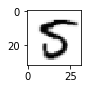

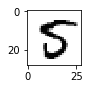

In [11]:
# img_test = cv2.resize(X_train[1],(32,32),interpolation = cv2.INTER_LINEAR)
img_show(X_train_32[11980])

img_show(X_train[11980])
print(X_train_32.shape)
print(X_test_32.shape)

In [12]:
def imgs_show_norm(imgs,row,col):
    fig,ax = plt.subplots(nrows=row,ncols=col,sharex=True,sharey=True)
    ax = ax.flatten()
    for i in range(row*col):
        img = imgs[i]
        min = np.min(img)
#         print('min = ',min)
        img = np.subtract(img,min) # 0->
        max = np.max(img)
#         print('max =',max)
        img = np.divide(img,max)
        
        ax[i].imshow(img,cmap='Greys', interpolation='nearest')
    
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()

In [13]:
def img_show_norm(img):
    min_ = np.min(img)
#     print('min = ',min_)
    img = np.subtract(img,min_) # 0->
    max_ = np.amax(a = img,keepdims=False)
#     print('max =',max_)
    img = np.divide(img,max_)  # 0->1
#     print(img)
    plt.figure(figsize=(1,1))
    plt.imshow(img,cmap='Greys',interpolation='nearest')

In [14]:
def img_show(img):
    plt.figure(figsize=(1,1))
    plt.imshow(img,cmap='Greys',interpolation='nearest')
    

In [15]:
def imgs_show(imgs,row,col):
    fig,ax = plt.subplots(nrows=row,ncols=col,sharex=True,sharey=True)
    ax = ax.flatten()
    for i in range(row*col):
        img = imgs[i]
        
        ax[i].imshow(img,cmap='Greys', interpolation='nearest')
    
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()
    
    

In [16]:
def normal_minist(img):
    return ((img / 255.0) -0.5)*2

In [17]:
def expend_HWC(img):
    return np.expand_dims(img,axis=3)


In [18]:
def to_CHW(img):
    return np.transpose(img,(0,3,1,2))
def to_HWC(img):
    return np.transpose(img,(0,2,3,1))

In [19]:
#只能运行一次
X_train_nor = expend_HWC(X_train_32)
X_train_nor = normal_minist(X_train_nor)
X_train_nor = to_CHW(X_train_nor)
print(X_train_nor.shape)

X_test_nor = expend_HWC(X_test_32)
X_test_nor = normal_minist(X_test_nor)
X_test_nor = to_CHW(X_test_nor)
print(X_test_nor.shape)




(60000, 1, 32, 32)
(10000, 1, 32, 32)


In [20]:
eval_index = [0,6]
negative_index = [1,2,3,4,5,7,8,9]
classes = 10
nn_index = [-1,1]
def compute_index_logical_equal(inputs,indexs):
    logic_result = (inputs==indexs[0])
    for value in indexs:
        logic_result = np.logical_or(inputs == value,logic_result)
    return logic_result

def compute_index_logical_not_equal(inputs,indexs):
    logic_result = (inputs==indexs[0])
    for value in indexs:
        logic_result = np.logical_or(inputs == value,logic_result)
    return np.logical_not(logic_result)

In [21]:
y_test_te = y_test[:10]
print(y_test_te)
print(compute_index_logical_equal(y_test_te,eval_index))
print(compute_index_logical_not_equal(y_test_te,eval_index))
print(y_test_te[compute_index_logical_equal(y_test_te,eval_index)])

[7 2 1 0 4 1 4 9 5 9]
[False False False  True False False False False False False]
[ True  True  True False  True  True  True  True  True  True]
[0]


test_postitive_lable :  (1938,) [0 0 6 0 6 6 0 0 6 6 0 6 0 0 6 6 6 6 6 0 6 0 6 6 0 6 6 0 6 0 6 6 0 0 0 0 6
 6 0 6 0 6 0 0 6 0 0 0 0 0]
test_nagivate_lable :  (8062,) [7 2 1 4 1 4 9 5 9 9 1 5 9 7 3 4 9 5 4 7 4 1 3 1 3 4 7 2 7 1 2 1 1 7 4 2 3
 5 1 2 4 4 3 5 5 4 1 9 5 7]


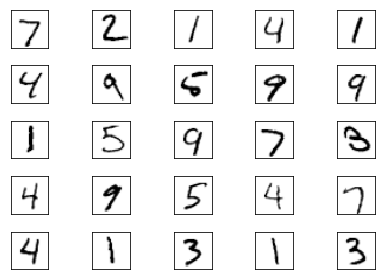

In [22]:
#init test data set
y_test_equal_evla_index = compute_index_logical_equal(y_test,eval_index)
y_test_no_equal_evla_index = compute_index_logical_not_equal(y_test,eval_index)

test_nagivate_lable = y_test[y_test_no_equal_evla_index]
test_nagivate = X_test_nor[y_test_no_equal_evla_index]

test_postitive = X_test_nor[y_test_equal_evla_index]
test_postitive_lable = y_test[y_test_equal_evla_index]
# print(test_postitive[:50])
print("test_postitive_lable : ",test_postitive_lable.shape,test_postitive_lable[:50])
print("test_nagivate_lable : ",test_nagivate_lable.shape,test_nagivate_lable[:50])
imgs_show(np.squeeze(test_nagivate[:25]),5,5)



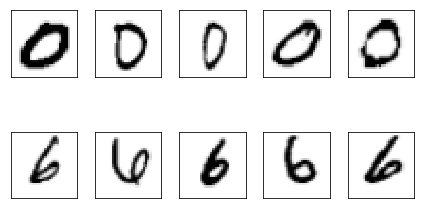

[0 0 0 0 0 6 6 6 6 6]


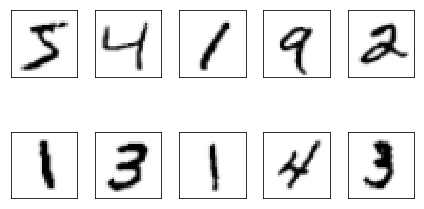

[5 4 1 9 2 1 3 1 4 3]
(48159, 1, 32, 32)


In [23]:
#init train data set
train_positive = []
label_positive =[]
np.random.seed(7)
for value in eval_index :
    
    shuffle_index_positive = np.random.permutation(len(X_train_nor[y_train == value]))
    train_positive.append(X_train_nor[y_train == value][shuffle_index_positive][:5])
    label_positive.append(y_train[y_train == value][shuffle_index_positive][:5])
train_positive = np.concatenate(train_positive)
label_positive = np.concatenate(label_positive)

imgs_show(np.squeeze(train_positive),2,5)
print(label_positive)


train_nagivate = X_train_nor[compute_index_logical_not_equal(y_train ,eval_index)]
label_nagivate = y_train[compute_index_logical_not_equal(y_train , eval_index)]
imgs_show(np.squeeze(train_nagivate[:10]),2,5)
print(label_nagivate[:10])
print(train_nagivate.shape)




In [24]:
def compute_index_logical_equal(inputs,indexs):
    logic_result = (inputs==indexs[0])
    for value in indexs:
        logic_result = np.logical_or(inputs == value,logic_result)
    return logic_result


In [25]:
class AutoCodeNet(nn.Module):
    def __init__(self):
        super(AutoCodeNet,self).__init__()
        self.conv1 = nn.Conv2d(1,8,kernel_size=3,stride=2,padding=1)
#         self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(8,16,kernel_size=3,stride=2,padding=1)
#         self.pool2 = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(16,24,kernel_size=3,stride=2,padding=1)
#         self.pool3 = nn.MaxPool2d(2,2,padding=1)

        self.fc1 = nn.Linear(24*4*4,100)
        self.fc2 = nn.Linear(100,10)
      
            
        
        self.up1 = nn.Upsample(scale_factor = 2,mode='nearest')
#         F.interpolate()
        self.conv_d1 = nn.Conv2d(24,16,kernel_size=3,stride=1,padding=1)
        self.up2 = nn.Upsample(scale_factor = 2)
        self.conv_d2 = nn.Conv2d(16,8,kernel_size=3,stride=1)
        self.up3 = nn.Upsample(scale_factor = 2)
        self.conv_d3 = nn.Conv2d(8,8,kernel_size=3,stride=1,padding=1)
        
        self.conv_d4 = nn.Conv2d(8,1,kernel_size=3,stride=1,padding=1)
        
        self.features={}
        
    def decodeForward(self,x):
        #decode
        x = F.leaky_relu(self.conv1(x))
        self.features['relu1'] = x
        
        x = F.leaky_relu(self.conv2(x))
        self.features['relu2'] = x
        
        x = F.leaky_relu(self.conv3(x))
        self.features['relu3'] = x
        
        return x
    
    def encodeforward(self,x):
        
        x_g = self.up1(x)
        self.features['up1'] = x_g
        x_g = F.leaky_relu(self.conv_d1(x_g))
        self.features['relu_d1'] = x_g
        
        x_g = self.up2(x_g)
        self.features['up2'] = x_g
        x_g = F.leaky_relu(self.conv_d2(x_g))
        self.features['relu_d2'] = x_g
        
        x_g = self.up3(x_g)
        self.features['up3'] = x_g
        x_g = F.leaky_relu(self.conv_d3(x_g))
        self.features['relu_d3'] =x_g
        
        x_g = self.conv_d4(x_g)
        self.features['conv_d4'] = x_g
        
        x_g = F.tanh(x_g)
        self.features['tanh'] = x_g
        return  x_g
    
    def class_forward(self,x):
        x_c = x.view(-1,self.num_flat_features(x))
        x_c = F.leaky_relu(self.fc1(x_c))
        x_c = F.dropout(x_c, training=self.training)
        x_c = self.fc2(x_c)
        x_c = F.log_softmax(x_c,dim=1)
        return x_c
    
    def num_flat_features(self,x):
        size = x.size()[1:]
        num_features =1

        for s in size:
            num_features *= s
        return num_features
        
        
    def forward(self,x):
        assert len(x) % 3 == 0
        
        #decode
        x = self.decodeForward(x)
#         print('x.size(): ',x.size())

        
        
        
            
            
        
        #class
        x_c = self.class_forward(x)
        
        #encode
        x_g = self.encodeforward(x)
        
        
        return x_g ,x_c
        
        
        
        
        
        
        

In [26]:

def test_glow():
    print("[Test]: Glow")
    
    glow = models.Glow(JsonConfig("hparams/celeba_minist.json"))
    # img = cv2.imread("pictures/tsuki.jpeg")
    # img = cv2.resize(img, (32, 32))
    # img = (img / 255.0).astype(np.float32)
    # img = img[:, :, ::-1].transpose(2, 0, 1)
    # x = torch.Tensor([img]*8)
    
    x = torch.Tensor(train_positive)
    print('x.size = ', x.size())

    batch_size = 10
    nb_digits = 10
    y = torch.Tensor(label_positive).long()
    print('y = ',y)
    print('y.view(-1,1) = ', y.view(-1,1))
    y_onehot = torch.FloatTensor(batch_size, nb_digits)
    y_onehot.zero_()
    y_onehot.scatter_(1, y.view(-1,1), 1)
    print('y_onehot:', y_onehot)


    z, det, y_logits = glow(x=x, y_onehot=y_onehot)
    print(z.size())
    print(det)

    print(models.Glow.loss_generative(det))
    print('y_logits =  ',y_logits)
    print(models.Glow.loss_class(y_logits,y))


In [27]:
test_glow()

[Test]: Glow
x.size =  torch.Size([10, 1, 32, 32])
y =  tensor([ 0,  0,  0,  0,  0,  6,  6,  6,  6,  6])
y.view(-1,1) =  tensor([[ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 6],
        [ 6],
        [ 6],
        [ 6],
        [ 6]])
y_onehot: tensor([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]])


RuntimeError: invalid argument 2: size '[30 x 32 x 1 x 1]' is invalid for input with 320 elements at /opt/conda/conda-bld/pytorch_1524580978845/work/aten/src/TH/THStorage.c:41

In [28]:
def getnext(train_x,train_y,batch_size):
    batchs = len(train_y) // batch_size
    print(len(train_y),batchs)

    for i in range(batchs):
        x = train_x[batch_size * i : batch_size * (i+1)]
        y = train_y[batch_size * i : batch_size * (i+1)]
        yield x,y
        

In [29]:
def get_nagivate_next(train_positive,train_nagivate):
    batch_size = len(train_positive) 
    batchs = len(train_nagivate) // batch_size
    print(len(train_nagivate),batchs)
    
    for i in range(batchs):
        x = np.concatenate((train_positive,train_nagivate[batch_size * i : batch_size * (i+1)]))
        y = np.concatenate((np.zeros(batch_size),np.ones(batch_size)))
        shuf_index = np.random.permutation(len(y))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x ,y 
        

In [30]:
def get_nagivate_batch_next(train_positive,train_nagivate,batch_size):
#     batch_size = len(train_positive) 
    batchs = len(train_nagivate) // batch_size
    print(len(train_nagivate),batchs)
    
    for i in range(batchs):
        x = np.concatenate((train_positive,train_nagivate[batch_size * i : batch_size * (i+1)]))
        y = np.concatenate((np.zeros(len(train_positive)),np.ones(len(train_nagivate))))
        shuf_index = np.random.permutation(len(x))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x ,y 

In [31]:
def get_next_posi_nag(train_positive,train_nagivate,label_positive, label_nagivate ,batch_size):
#     batch_size = len(train_positive) 
    batchs = len(train_nagivate) // batch_size
    print(len(train_nagivate),batchs)
    
    for i in range(batchs):
        x = np.concatenate((train_positive,train_nagivate[batch_size * i : batch_size * (i+1)]))
        y = np.concatenate((label_positive,label_nagivate[batch_size * i : batch_size * (i+1)]))
        shuf_index = np.random.permutation(len(x))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x ,y 

In [32]:
def get_next_pn_label(train_positive,train_nagivate,label_positive, label_nagivate):

    class_index_num =[]
    for i in range(1,10):
        class_index_num.append(len(train_nagivate[label_nagivate == i]))
    class_index_num = np.array(class_index_num)
    print('class_index_num = ',class_index_num)
    min_index_num = np.min(class_index_num)
    print('min_index_num = ',min_index_num)
    max_index_num = np.max(class_index_num)
    print('max_index_num = ',max_index_num)
    max_index_class = np.argmax(class_index_num) + 1
    print('max_index_class = ',max_index_class)
    batch_size = 2
    batchs = min_index_num // batch_size
    print('batchs = ',batchs)
    
    
    
    
    
    for i in range(batchs):
        x = train_positive
        y = label_positive
        for class_index in range(1,10):
            
            # batch_index < class len
            if batch_size * (i+1) <= class_index_num[class_index - 1] :
                
                x = np.concatenate( (x,train_nagivate[label_nagivate == class_index][batch_size * i : batch_size * (i+1)]))
                y = np.concatenate((y,label_nagivate[label_nagivate == class_index][batch_size * i : batch_size * (i+1)]))
        
        if len(x) < (3 * len(train_positive)) :
            x = np.concatenate((x,train_nagivate[label_nagivate == max_index_class][batch_size * (i+1) : batch_size * (i+2)]))
            y = np.concatenate((y,label_nagivate[label_nagivate == max_index_class][batch_size * (i+1) : batch_size * (i+2)]))

        shuf_index = np.random.permutation(len(x))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x,y 


In [33]:
def get_next_pn_label2(train_positive,train_nagivate,label_positive, label_nagivate):

    class_index_num =[]
    for value in negative_index:
        class_index_num.append(len(train_nagivate[label_nagivate == value]))
    
    class_index_num = np.array(class_index_num)
    # class_index_num = np.sort(class_index_num)
    print('class_index_num = ',class_index_num)
    
    sort_index_num = np.argsort(class_index_num)
    print('sort_index_num = ',sort_index_num)
    
    min_index_num = class_index_num[sort_index_num[0]]
    max_index_num = class_index_num[sort_index_num[-1]]
    print('min_index_num = ',min_index_num)
    print('max_index_num = ',max_index_num)
    
    max_index_class = negative_index[sort_index_num[-1]]
    max_second_index_class = negative_index[sort_index_num[-2]]
    print('max_index_class = ',max_index_class)
    print('max_second_index_class = ',max_second_index_class)
    
    batch_size = 2
    batchs = min_index_num // batch_size
    print('batchs = ',batchs)
    
    
    
    for i in range(batchs):
        x = []
        y = []
        x.append(train_positive)  
        y.append(label_positive)
        
        for sor_index in sort_index_num :
                class_index = negative_index[sor_index]
#                 print(class_index)
                x.append(train_nagivate[label_nagivate == class_index][batch_size * i : batch_size * (i+1)])
                y.append(label_nagivate[label_nagivate == class_index][batch_size * i : batch_size * (i+1)])
        
        
        x.append(train_nagivate[label_nagivate == max_index_class][-(batch_size * (i+2)):-(batch_size * (i+1)) ])
        y.append(label_nagivate[label_nagivate == max_index_class][-(batch_size * (i+2)):-(batch_size * (i+1)) ])
#         print(label_nagivate[(-batch_size * (i+2)):-2])
        x.append(train_nagivate[label_nagivate == max_second_index_class][-(batch_size * (i+2)):-(batch_size * (i+1)) ])
        y.append(label_nagivate[label_nagivate == max_second_index_class][-(batch_size * (i+2)):-(batch_size * (i+1)) ])
        
#         for i in range(len(x)):
#             print(x[i].shape)
        x = np.concatenate(x)
        y = np.concatenate(y)
        shuf_index = np.random.permutation(len(x))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x,y 

In [34]:
#     train_1 = train_nagivate[y_train == 1]
#     print("train_1.shape = ",train_1.shape)

#     train_2 = train_nagivate[y_train == 2]
#     print("train_2.shape = ",train_2.shape)

#     train_3 = train_nagivate[y_train == 3]
#     print("train_3.shape = ",train_3.shape)

#     train_4 = train_nagivate[y_train == 4]
#     print("train_0.shape = ",train_4.shape)


#     train_5 = train_nagivate[y_train == 5]
#     print("train_0.shape = ",train_5.shape)


#     train_6 = train_nagivate[y_train == 6]
#     print("train_6.shape = ",train_6.shape)

#     train_7 = train_nagivate[y_train == 7]
#     print("train_7.shape = ",train_7.shape)


#     train_8 = train_nagivate[y_train == 8]
#     print("train_8.shape = ",train_8.shape)


#     train_9 = train_nagivate[y_train == 9]
#     print("train_9.shape = ",train_9.shape)
                               
# train_0.shape =  (5923, 1, 28, 28)
# train_1.shape =  (6742, 1, 28, 28)
# train_2.shape =  (5958, 1, 28, 28)
# train_3.shape =  (6131, 1, 28, 28)
# train_4.shape =  (5842, 1, 28, 28)
# train_5.shape =  (5421, 1, 28, 28)
# train_6.shape =  (5918, 1, 28, 28)
# train_7.shape =  (6265, 1, 28, 28)
# train_8.shape =  (5851, 1, 28, 28)
# train_9.shape =  (5949, 1, 28, 28)

class_index_num =  [13 12 13 12 11 12 10 17]
sort_index_num =  [6 4 1 3 5 0 2 7]
min_index_num =  10
max_index_num =  17
max_index_class =  9
max_second_index_class =  3
batchs =  5
(30, 1, 32, 32)
[6 6 8 1 5 6 2 0 9 3 3 5 4 9 4 0 9 8 6 3 0 1 6 7 0 0 9 2 7 3]


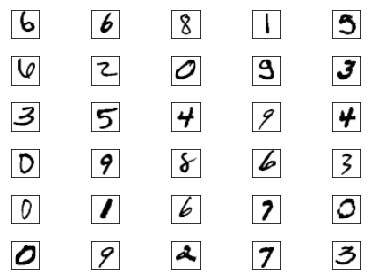

(30, 1, 32, 32)
[3 0 6 0 0 8 4 7 5 9 5 4 2 9 2 0 1 3 6 3 9 6 1 3 6 7 9 6 8 0]


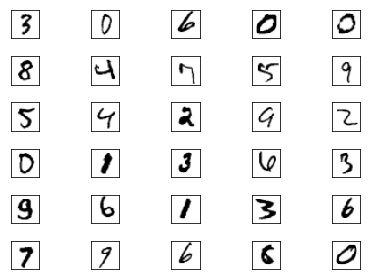

(30, 1, 32, 32)
[7 1 6 9 6 3 3 9 3 5 6 6 9 2 0 0 2 6 0 4 8 8 1 4 5 3 0 0 9 7]


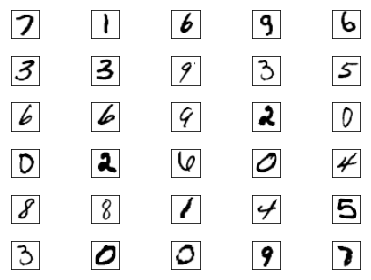

(30, 1, 32, 32)
[0 3 7 9 0 7 1 4 8 0 6 5 3 6 9 8 4 9 2 9 3 6 3 1 0 0 5 6 6 2]


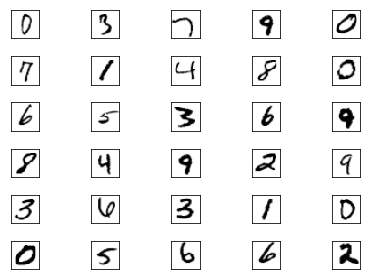

(30, 1, 32, 32)
[7 4 9 0 6 2 1 0 6 7 8 0 3 1 9 0 9 9 6 5 6 0 2 3 8 3 5 3 6 4]


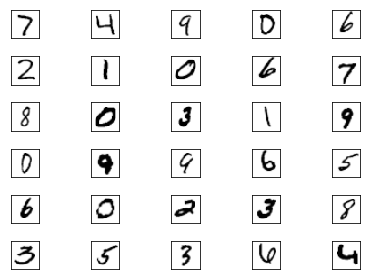

In [35]:
datas = get_next_pn_label2(train_positive,train_nagivate[1100:1200],label_positive,label_nagivate[1100:1200])
for x,y in datas:
    print(x.shape)
    
    print(y)
    imgs_show(np.squeeze( x),6,5)


In [40]:
batch_size = 30
nb_digits = 10
net_auto = models.Glow(JsonConfig("hparams/celeba_minist.json"))



In [41]:

# net_auto = torch.load('model_autoEncode5.pkl')
use_cuda = torch.cuda.is_available()
torch.manual_seed(666)
device = torch.device("cuda" if use_cuda else "cpu")
net_auto.to(device)
net_auto.float()


criterion = nn.MSELoss()
optimizer = optim.SGD(net_auto.parameters(),lr=0.001,momentum=0.9,weight_decay=5e-4)


In [ ]:
#X_train_nor


for epoch in range(50):
    #train:
    net_auto.train()
    shuf_nagivate = np.random.permutation(len(train_nagivate))
    train_nagivate = train_nagivate[shuf_nagivate]
    label_nagivate = label_nagivate[shuf_nagivate]
#     datas = get_next_posi_nag(train_positive,train_nagivate,label_positive,label_nagivate, 10)
    datas = get_next_pn_label2(train_positive,train_nagivate,label_positive,label_nagivate)
    
    trainloss_g = 0
    trainloss_c = 0
    
    for x,y in datas:
        inputs ,lables = torch.from_numpy(x).float().to(device),\
            torch.from_numpy(y).long().to(device)
        
        y_onehot = torch.FloatTensor(batch_size, nb_digits).to(device)
        y_onehot.zero_()
        y_onehot.scatter_(1, lables.view(-1,1), 1)
#         print('y_onehot:', y_onehot)


       

        optimizer.zero_grad()
        z, det, y_logits = net_auto(x=inputs, y_onehot=y_onehot)
#         print(z.size())
#         print(det)
        loss_g = models.Glow.loss_generative(det)
        loss_c = models.Glow.loss_class(y_logits,lables)
        print('loss_g = ',loss_g.item())
        print('loss_c =  ',loss_c.item())
        loss = loss_g + loss_c
        loss.backward()
        torch.nn.utils.clip_grad_value_(net_auto.parameters(), 5)
        torch.nn.utils.clip_grad_norm_(net_auto.parameters(), 100)
        
        
        trainloss_g += loss_g.item()
        trainloss_c += loss_c.item()
#         print("net_auto.conv_d1 grad:",net_auto.conv_d1.weight.grad)
        
#         print("after net_auto.conv_1 grad:",net_auto.conv1.weight.grad)
        optimizer.step()
        
    print('%d  gloss: %.3f, class loss:%.3f' % (epoch ,  trainloss_g,trainloss_c))
    
    
    torch.save(net_auto.state_dict(),'model_few_shot_class_only'+str(epoch)+'.pt')
    


class_index_num =  [6742 5958 6131 5842 5421 6265 5851 5949]
sort_index_num =  [4 3 6 7 1 2 5 0]
min_index_num =  5421
max_index_num =  6742
max_index_class =  1
max_second_index_class =  7
batchs =  2710
loss_g =  8.249985694885254
loss_c =   2.3025851249694824
loss_g =  8.201475143432617
loss_c =   2.3025388717651367
loss_g =  8.153929710388184
loss_c =   2.3024635314941406
loss_g =  8.097819328308105
loss_c =   2.302340507507324
loss_g =  8.043601036071777
loss_c =   2.302241563796997
loss_g =  8.018177032470703
loss_c =   2.3021223545074463
loss_g =  7.949365139007568
loss_c =   2.30194354057312
loss_g =  7.921837329864502
loss_c =   2.3018624782562256
loss_g =  7.8975958824157715
loss_c =   2.301673650741577
loss_g =  7.852426528930664
loss_c =   2.301527976989746
loss_g =  7.8492751121521
loss_c =   2.3012855052948
loss_g =  7.812087059020996
loss_c =   2.3011178970336914
loss_g =  7.794674873352051
loss_c =   2.301048755645752
loss_g =  7.761245250701904
loss_c =   2.30075430870

loss_g =  6.4034929275512695
loss_c =   2.241389751434326
loss_g =  6.29995059967041
loss_c =   2.244042158126831
loss_g =  6.385271072387695
loss_c =   2.246825695037842
loss_g =  6.310926914215088
loss_c =   2.2499375343322754
loss_g =  6.348030090332031
loss_c =   2.2480826377868652
loss_g =  6.23503303527832
loss_c =   2.245969533920288
loss_g =  6.194383144378662
loss_c =   2.243032217025757
loss_g =  6.240853309631348
loss_c =   2.2403693199157715
loss_g =  7.221319675445557
loss_c =   2.2358458042144775
loss_g =  8.105406761169434
loss_c =   2.2439260482788086
loss_g =  6.835152626037598
loss_c =   2.256988525390625
loss_g =  7.194091796875
loss_c =   2.26688551902771
loss_g =  7.15271520614624
loss_c =   2.2709453105926514
loss_g =  7.009566783905029
loss_c =   2.272490978240967
loss_g =  6.965063571929932
loss_c =   2.275496482849121
loss_g =  7.062713146209717
loss_c =   2.2845468521118164
loss_g =  7.125730991363525
loss_c =   2.2812280654907227
loss_g =  7.069456577301025
l

loss_g =  5.453737258911133
loss_c =   1.6550781726837158
loss_g =  6.674305438995361
loss_c =   1.6243988275527954
loss_g =  5.50002384185791
loss_c =   1.6645698547363281
loss_g =  6.414895057678223
loss_c =   1.6415741443634033
loss_g =  5.742368221282959
loss_c =   1.6487834453582764
loss_g =  5.797240734100342
loss_c =   1.681819200515747
loss_g =  5.85995626449585
loss_c =   1.6299457550048828
loss_g =  5.840346336364746
loss_c =   1.6182302236557007
loss_g =  5.6331939697265625
loss_c =   1.6290431022644043
loss_g =  5.637194633483887
loss_c =   1.6127187013626099
loss_g =  5.75364875793457
loss_c =   1.5958504676818848
loss_g =  5.601712703704834
loss_c =   1.5877169370651245
loss_g =  5.572244644165039
loss_c =   1.6030566692352295
loss_g =  5.623886585235596
loss_c =   1.608171820640564
loss_g =  5.506819248199463
loss_c =   1.5957077741622925
loss_g =  5.542593002319336
loss_c =   1.565988540649414
loss_g =  5.488272666931152
loss_c =   1.529097080230713
loss_g =  5.46732854

loss_g =  5.025761604309082
loss_c =   1.0702214241027832
loss_g =  4.747968673706055
loss_c =   1.1386388540267944
loss_g =  5.262053966522217
loss_c =   1.0775820016860962
loss_g =  4.866506099700928
loss_c =   1.0371602773666382
loss_g =  5.015870094299316
loss_c =   1.0686147212982178
loss_g =  5.0543131828308105
loss_c =   1.1152030229568481
loss_g =  4.812114238739014
loss_c =   1.116952896118164
loss_g =  4.888335704803467
loss_c =   1.0340572595596313
loss_g =  4.884655952453613
loss_c =   1.0889031887054443
loss_g =  4.8442487716674805
loss_c =   1.1034367084503174
loss_g =  4.837259769439697
loss_c =   1.029422640800476
loss_g =  4.743623733520508
loss_c =   1.0441911220550537
loss_g =  4.840015888214111
loss_c =   0.9730638265609741
loss_g =  4.800686836242676
loss_c =   1.0492639541625977
loss_g =  4.795130252838135
loss_c =   0.9228580594062805
loss_g =  4.7753095626831055
loss_c =   1.0236220359802246
loss_g =  4.6351237297058105
loss_c =   1.0180044174194336
loss_g =  4.

loss_g =  4.770284175872803
loss_c =   0.824464738368988
loss_g =  5.438470840454102
loss_c =   0.8737272024154663
loss_g =  5.9867143630981445
loss_c =   0.9443367719650269
loss_g =  5.65588903427124
loss_c =   1.0397454500198364
loss_g =  5.602509498596191
loss_c =   1.0043079853057861
loss_g =  5.778056621551514
loss_c =   0.9528605341911316
loss_g =  5.668481826782227
loss_c =   1.024963140487671
loss_g =  5.444055080413818
loss_c =   0.9931296110153198
loss_g =  5.502740859985352
loss_c =   1.0156537294387817
loss_g =  5.537276268005371
loss_c =   0.9599640369415283
loss_g =  5.424704551696777
loss_c =   0.9148540496826172
loss_g =  5.4129157066345215
loss_c =   0.8281571865081787
loss_g =  5.4037065505981445
loss_c =   0.8881890773773193
loss_g =  5.29573392868042
loss_c =   1.0108580589294434
loss_g =  5.324206829071045
loss_c =   0.8260613083839417
loss_g =  5.3527936935424805
loss_c =   0.8402481079101562
loss_g =  5.137628078460693
loss_c =   0.9408431649208069
loss_g =  5.24

loss_g =  4.640562057495117
loss_c =   0.840013325214386
loss_g =  4.893609523773193
loss_c =   0.8358898162841797
loss_g =  4.853233814239502
loss_c =   0.7642678022384644
loss_g =  4.814183235168457
loss_c =   0.7995807528495789
loss_g =  4.935800552368164
loss_c =   0.7888022065162659
loss_g =  4.507418632507324
loss_c =   1.0666943788528442
loss_g =  4.822821140289307
loss_c =   0.816102921962738
loss_g =  4.636938571929932
loss_c =   0.8183498382568359
loss_g =  4.774806022644043
loss_c =   0.8022518157958984
loss_g =  4.67129373550415
loss_c =   0.7983213067054749
loss_g =  4.608099460601807
loss_c =   0.9108201265335083
loss_g =  4.9037322998046875
loss_c =   0.771412193775177
loss_g =  5.07634162902832
loss_c =   0.8657544255256653
loss_g =  4.712808609008789
loss_c =   0.7481249570846558
loss_g =  4.717051029205322
loss_c =   0.8068124651908875
loss_g =  4.807800769805908
loss_c =   0.8270285129547119
loss_g =  4.69363260269165
loss_c =   0.709942102432251
loss_g =  4.82881164

loss_g =  4.8787665367126465
loss_c =   0.7039371132850647
loss_g =  4.721058368682861
loss_c =   0.6960718035697937
loss_g =  5.1546711921691895
loss_c =   0.8131170868873596
loss_g =  5.061578750610352
loss_c =   0.8384563326835632
loss_g =  5.46109676361084
loss_c =   0.9516506195068359
loss_g =  5.002712726593018
loss_c =   0.8005248308181763
loss_g =  4.900162696838379
loss_c =   0.7167194485664368
loss_g =  5.013415813446045
loss_c =   0.7857663035392761
loss_g =  5.053092002868652
loss_c =   0.7480838894844055
loss_g =  4.957962512969971
loss_c =   0.8073440194129944
loss_g =  4.985470771789551
loss_c =   0.7393470406532288
loss_g =  4.866703987121582
loss_c =   0.7305814027786255
loss_g =  4.699603080749512
loss_c =   0.8077362775802612
loss_g =  4.834501266479492
loss_c =   0.8470844030380249
loss_g =  4.976526260375977
loss_c =   0.6639079451560974
loss_g =  4.834066867828369
loss_c =   0.8302995562553406
loss_g =  4.720717906951904
loss_c =   0.7738984227180481
loss_g =  4.6

loss_g =  5.432415962219238
loss_c =   0.6911613941192627
loss_g =  5.354493618011475
loss_c =   0.7578160762786865
loss_g =  5.184095859527588
loss_c =   0.6035321354866028
loss_g =  5.129293441772461
loss_c =   0.7843681573867798
loss_g =  5.327195644378662
loss_c =   0.8390358090400696
loss_g =  5.063105583190918
loss_c =   0.7267208099365234
loss_g =  5.202036380767822
loss_c =   0.8776577711105347
loss_g =  5.2130937576293945
loss_c =   0.756702184677124
loss_g =  5.487588882446289
loss_c =   0.9009088277816772
loss_g =  5.0871262550354
loss_c =   0.7293484210968018
loss_g =  5.256535530090332
loss_c =   0.9021580219268799
loss_g =  5.283868312835693
loss_c =   0.8397594094276428
loss_g =  5.073494911193848
loss_c =   0.6463793516159058
loss_g =  5.078671932220459
loss_c =   0.712029218673706
loss_g =  5.146228313446045
loss_c =   0.5489011406898499
loss_g =  5.034820556640625
loss_c =   0.6420040726661682
loss_g =  5.299256801605225
loss_c =   0.8104852437973022
loss_g =  5.14126

loss_g =  5.606545448303223
loss_c =   0.5196786522865295
loss_g =  5.747312545776367
loss_c =   1.163801908493042
loss_g =  4.95500373840332
loss_c =   0.5675936341285706
loss_g =  5.492636203765869
loss_c =   1.0045655965805054
loss_g =  5.237011909484863
loss_c =   0.6077954173088074
loss_g =  5.903424263000488
loss_c =   0.6469182372093201
loss_g =  6.0008463859558105
loss_c =   0.7088760137557983
loss_g =  5.176318645477295
loss_c =   0.5883490443229675
loss_g =  5.6283860206604
loss_c =   0.6575170755386353
loss_g =  5.212435245513916
loss_c =   0.5316819548606873
loss_g =  5.688652515411377
loss_c =   0.5656642913818359
loss_g =  5.4702019691467285
loss_c =   1.2575560808181763
loss_g =  5.422634601593018
loss_c =   0.6131487488746643
loss_g =  5.538874626159668
loss_c =   0.5927569270133972
loss_g =  5.488077163696289
loss_c =   0.7725140452384949
loss_g =  5.3771467208862305
loss_c =   0.7660564184188843
loss_g =  5.5272698402404785
loss_c =   0.5361822247505188
loss_g =  5.37

loss_g =  5.519011497497559
loss_c =   0.6596032381057739
loss_g =  5.223810195922852
loss_c =   0.49901384115219116
loss_g =  5.544459819793701
loss_c =   0.4080197513103485
loss_g =  5.443485736846924
loss_c =   0.4126858711242676
loss_g =  5.260636806488037
loss_c =   0.48953258991241455
loss_g =  5.263684272766113
loss_c =   0.6642959117889404
loss_g =  5.35090970993042
loss_c =   0.6103603839874268
loss_g =  5.318432807922363
loss_c =   0.41317784786224365
loss_g =  5.344555854797363
loss_c =   0.45839977264404297
loss_g =  5.237770080566406
loss_c =   0.36493366956710815
loss_g =  5.214661121368408
loss_c =   0.36012139916419983
loss_g =  5.282196044921875
loss_c =   0.4494829773902893
loss_g =  5.0243377685546875
loss_c =   0.40286991000175476
loss_g =  5.231997489929199
loss_c =   0.5519534945487976
loss_g =  5.111486911773682
loss_c =   0.37073513865470886
loss_g =  5.099677085876465
loss_c =   0.31037208437919617
loss_g =  5.084122180938721
loss_c =   0.38975709676742554
loss

loss_g =  5.359510898590088
loss_c =   0.34956029057502747
loss_g =  5.156956672668457
loss_c =   0.41963404417037964
loss_g =  4.893738746643066
loss_c =   0.37183865904808044
loss_g =  5.070502758026123
loss_c =   0.18850810825824738
loss_g =  5.069104194641113
loss_c =   0.2507413327693939
loss_g =  4.846112251281738
loss_c =   0.37696540355682373
loss_g =  4.909026622772217
loss_c =   0.4049517512321472
loss_g =  4.9137396812438965
loss_c =   0.19107763469219208
loss_g =  5.036287784576416
loss_c =   0.2590193450450897
loss_g =  4.92424201965332
loss_c =   0.24822020530700684
loss_g =  4.794927597045898
loss_c =   0.2645333409309387
loss_g =  4.95542049407959
loss_c =   0.2572214603424072
loss_g =  4.907423496246338
loss_c =   0.22831320762634277
loss_g =  4.84696626663208
loss_c =   0.37920236587524414
loss_g =  4.810418605804443
loss_c =   0.28180962800979614
loss_g =  5.129362106323242
loss_c =   0.5419428944587708
loss_g =  4.879054069519043
loss_c =   0.32579123973846436
loss_

loss_g =  6.133780002593994
loss_c =   0.22071626782417297
loss_g =  5.440319538116455
loss_c =   0.4302779734134674
loss_g =  5.614014625549316
loss_c =   0.42359665036201477
loss_g =  5.315548896789551
loss_c =   0.1921800971031189
loss_g =  5.352768898010254
loss_c =   0.12092041969299316
loss_g =  5.258556842803955
loss_c =   0.2870595157146454
loss_g =  5.450406074523926
loss_c =   0.46195676922798157
loss_g =  5.167411804199219
loss_c =   0.26519519090652466
loss_g =  5.583212375640869
loss_c =   0.25269192457199097
loss_g =  5.2862348556518555
loss_c =   0.23375962674617767
loss_g =  5.740638732910156
loss_c =   0.15946868062019348
loss_g =  5.907079696655273
loss_c =   0.3529090881347656
loss_g =  5.377607822418213
loss_c =   0.29440319538116455
loss_g =  5.723355770111084
loss_c =   0.36408960819244385
loss_g =  5.883947372436523
loss_c =   0.3600671887397766
loss_g =  5.280947685241699
loss_c =   0.20878370106220245
loss_g =  5.63993501663208
loss_c =   0.4484296143054962
los

loss_g =  5.01360559463501
loss_c =   0.16149519383907318
loss_g =  5.079514026641846
loss_c =   0.19093553721904755
loss_g =  4.821987628936768
loss_c =   0.26027339696884155
loss_g =  5.415482997894287
loss_c =   0.2204108089208603
loss_g =  4.964988708496094
loss_c =   0.3477247953414917
loss_g =  5.228060245513916
loss_c =   0.09446334093809128
loss_g =  5.06499719619751
loss_c =   0.21617987751960754
loss_g =  5.078091144561768
loss_c =   0.13119743764400482
loss_g =  5.090309143066406
loss_c =   0.08177024871110916
loss_g =  4.902680397033691
loss_c =   0.10037057101726532
loss_g =  5.4977803230285645
loss_c =   0.2320384979248047
loss_g =  5.159013748168945
loss_c =   0.09782610833644867
loss_g =  5.157738208770752
loss_c =   0.23184780776500702
loss_g =  5.358567237854004
loss_c =   0.11698611080646515
loss_g =  5.129068851470947
loss_c =   0.22276440262794495
loss_g =  5.082159996032715
loss_c =   0.12874844670295715
loss_g =  5.830801010131836
loss_c =   0.23073183000087738
l

loss_g =  5.091672897338867
loss_c =   0.1498292237520218
loss_g =  5.083097457885742
loss_c =   0.07037769258022308
loss_g =  5.044798851013184
loss_c =   0.10840436816215515
loss_g =  5.04103946685791
loss_c =   0.15768244862556458
loss_g =  4.965592384338379
loss_c =   0.23420442640781403
loss_g =  4.981741428375244
loss_c =   0.20447476208209991
loss_g =  4.8785295486450195
loss_c =   0.17984086275100708
loss_g =  5.054834365844727
loss_c =   0.20394659042358398
loss_g =  4.847908973693848
loss_c =   0.15070563554763794
loss_g =  5.085546016693115
loss_c =   0.10717963427305222
loss_g =  4.990553379058838
loss_c =   0.2635570168495178
loss_g =  4.858204364776611
loss_c =   0.21859890222549438
loss_g =  5.002166271209717
loss_c =   0.12560443580150604
loss_g =  4.868704319000244
loss_c =   0.2599557340145111
loss_g =  5.200010299682617
loss_c =   0.09174858778715134
loss_g =  4.917108058929443
loss_c =   0.16256839036941528
loss_g =  5.255264759063721
loss_c =   0.3899456560611725
l

loss_g =  4.739251613616943
loss_c =   0.12363197654485703
loss_g =  4.69419527053833
loss_c =   0.039977747946977615
loss_g =  5.005620002746582
loss_c =   0.1087414100766182
loss_g =  4.709991455078125
loss_c =   0.07541172951459885
loss_g =  4.746633529663086
loss_c =   0.09709299355745316
loss_g =  4.969229221343994
loss_c =   0.10783133655786514
loss_g =  4.626193046569824
loss_c =   0.23997272551059723
loss_g =  5.041046142578125
loss_c =   0.05624181404709816
loss_g =  4.762797832489014
loss_c =   0.22718212008476257
loss_g =  4.687628269195557
loss_c =   0.11676670610904694
loss_g =  4.82481050491333
loss_c =   0.13270573318004608
loss_g =  4.625744819641113
loss_c =   0.04153672233223915
loss_g =  4.659206867218018
loss_c =   0.18753495812416077
loss_g =  4.926773548126221
loss_c =   0.10135195404291153
loss_g =  4.86604642868042
loss_c =   0.06472213566303253
loss_g =  5.020129203796387
loss_c =   0.14017842710018158
loss_g =  4.916480541229248
loss_c =   0.2552642822265625
l

loss_g =  5.626213550567627
loss_c =   0.09365975856781006
loss_g =  5.471025466918945
loss_c =   0.1949872076511383
loss_g =  5.618373394012451
loss_c =   0.18120115995407104
loss_g =  5.517294883728027
loss_c =   0.2008747011423111
loss_g =  5.635881423950195
loss_c =   0.20368114113807678
loss_g =  5.550992488861084
loss_c =   0.10756319016218185
loss_g =  5.572623252868652
loss_c =   0.32060572504997253
loss_g =  5.6816511154174805
loss_c =   0.11712843924760818
loss_g =  5.470263957977295
loss_c =   0.21301467716693878
loss_g =  5.559451103210449
loss_c =   0.07842586934566498
loss_g =  5.508864402770996
loss_c =   0.16791699826717377
loss_g =  5.42011833190918
loss_c =   0.21404699981212616
loss_g =  5.4528703689575195
loss_c =   0.21603861451148987
loss_g =  5.351937770843506
loss_c =   0.18728573620319366
loss_g =  5.430047988891602
loss_c =   0.23788204789161682
loss_g =  5.343771457672119
loss_c =   0.0959741622209549
loss_g =  5.362648963928223
loss_c =   0.22605259716510773

loss_g =  5.2375688552856445
loss_c =   0.413472980260849
loss_g =  5.055549621582031
loss_c =   0.13844576478004456
loss_g =  5.288825035095215
loss_c =   0.3325113356113434
loss_g =  5.090843200683594
loss_c =   0.06481321156024933
loss_g =  5.334659099578857
loss_c =   0.12721505761146545
loss_g =  5.324739933013916
loss_c =   0.05135825648903847
loss_g =  5.205313682556152
loss_c =   0.22392040491104126
loss_g =  5.145052433013916
loss_c =   0.06177060678601265
loss_g =  5.197969913482666
loss_c =   0.1364065557718277
loss_g =  5.102056503295898
loss_c =   0.1643226593732834
loss_g =  5.037071228027344
loss_c =   0.11660134047269821
loss_g =  5.088321208953857
loss_c =   0.07643350213766098
loss_g =  5.0741047859191895
loss_c =   0.09191135317087173
loss_g =  5.14677619934082
loss_c =   0.03714080527424812
loss_g =  4.970926284790039
loss_c =   0.13687743246555328
loss_g =  5.037394046783447
loss_c =   0.049479611217975616
loss_g =  5.0538225173950195
loss_c =   0.15133628249168396

loss_g =  5.5366411209106445
loss_c =   0.1995762139558792
loss_g =  5.580903053283691
loss_c =   0.047995105385780334
loss_g =  5.388833522796631
loss_c =   0.14686256647109985
loss_g =  5.235774040222168
loss_c =   0.3363714814186096
loss_g =  5.240643501281738
loss_c =   0.29631805419921875
loss_g =  5.034830570220947
loss_c =   0.07485675066709518
loss_g =  5.71439790725708
loss_c =   0.17626453936100006
loss_g =  5.544033527374268
loss_c =   0.35961997509002686
loss_g =  5.387362480163574
loss_c =   0.1541195958852768
loss_g =  5.655577182769775
loss_c =   0.2059796303510666
loss_g =  5.779601573944092
loss_c =   0.07845080643892288
loss_g =  5.482028484344482
loss_c =   0.11083552986383438
loss_g =  5.407650470733643
loss_c =   0.11520764976739883
loss_g =  5.453604221343994
loss_c =   0.12809684872627258
loss_g =  5.392114639282227
loss_c =   0.35597965121269226
loss_g =  5.085079669952393
loss_c =   0.20275016129016876
loss_g =  5.391600131988525
loss_c =   0.14441248774528503


loss_g =  4.9941020011901855
loss_c =   0.17346416413784027
loss_g =  5.047323226928711
loss_c =   0.09240462630987167
loss_g =  5.065866947174072
loss_c =   0.09565651416778564
loss_g =  4.920935153961182
loss_c =   0.17681270837783813
loss_g =  5.147066593170166
loss_c =   0.17005139589309692
loss_g =  5.023272514343262
loss_c =   0.23919804394245148
loss_g =  5.003243923187256
loss_c =   0.128804549574852
loss_g =  4.896624565124512
loss_c =   0.02999240532517433
loss_g =  4.872775077819824
loss_c =   0.11160500347614288
loss_g =  4.90814733505249
loss_c =   0.11662719398736954
loss_g =  4.814821243286133
loss_c =   0.09355170279741287
loss_g =  4.7648115158081055
loss_c =   0.10756801068782806
loss_g =  4.8284220695495605
loss_c =   0.26473182439804077
loss_g =  4.787363529205322
loss_c =   0.09998203814029694
loss_g =  5.341813087463379
loss_c =   0.013456249609589577
loss_g =  5.4764275550842285
loss_c =   0.0745515301823616
loss_g =  5.004386901855469
loss_c =   0.11056961119174

loss_g =  4.746812343597412
loss_c =   0.12505072355270386
loss_g =  5.0823163986206055
loss_c =   0.11102766543626785
loss_g =  5.294299602508545
loss_c =   0.09615044295787811
loss_g =  4.662907600402832
loss_c =   0.10201718658208847
loss_g =  5.510817527770996
loss_c =   0.18930377066135406
loss_g =  4.931516647338867
loss_c =   0.12798883020877838
loss_g =  5.1344895362854
loss_c =   0.08751432597637177
loss_g =  5.117867946624756
loss_c =   0.12255982309579849
loss_g =  5.084958553314209
loss_c =   0.06787452101707458
loss_g =  5.096868515014648
loss_c =   0.08009578287601471
loss_g =  4.866117477416992
loss_c =   0.11252982169389725
loss_g =  5.058060169219971
loss_c =   0.19419053196907043
loss_g =  4.929197788238525
loss_c =   0.20731505751609802
loss_g =  4.91975212097168
loss_c =   0.1879466325044632
loss_g =  5.171530723571777
loss_c =   0.08674038201570511
loss_g =  5.036157608032227
loss_c =   0.06108715385198593
loss_g =  4.888186931610107
loss_c =   0.04749758169054985


loss_g =  4.759221076965332
loss_c =   0.1795583814382553
loss_g =  4.923072338104248
loss_c =   0.06038856506347656
loss_g =  4.642516613006592
loss_c =   0.03460874408483505
loss_g =  4.660044193267822
loss_c =   0.23899397253990173
loss_g =  4.7886857986450195
loss_c =   0.18749277293682098
loss_g =  4.547502040863037
loss_c =   0.20765277743339539
loss_g =  4.67098331451416
loss_c =   0.0820874348282814
loss_g =  4.656555652618408
loss_c =   0.03534477576613426
loss_g =  4.669113636016846
loss_c =   0.16831786930561066
loss_g =  4.543271064758301
loss_c =   0.06853512674570084
loss_g =  4.5422163009643555
loss_c =   0.09190400689840317
loss_g =  4.684344291687012
loss_c =   0.026991350576281548
loss_g =  4.627562522888184
loss_c =   0.01623319834470749
loss_g =  4.722625255584717
loss_c =   0.2685503363609314
loss_g =  4.61950159072876
loss_c =   0.02525564841926098
loss_g =  4.569763660430908
loss_c =   0.03867241367697716
loss_g =  4.605172634124756
loss_c =   0.01545686740428209

loss_g =  4.405060291290283
loss_c =   0.1037295013666153
loss_g =  4.512338161468506
loss_c =   0.10032738745212555
loss_g =  4.414504051208496
loss_c =   0.07782372087240219
loss_g =  4.3279571533203125
loss_c =   0.1489294022321701
loss_g =  4.441859245300293
loss_c =   0.08054957538843155
loss_g =  4.363134860992432
loss_c =   0.10608059912919998
loss_g =  4.433321952819824
loss_c =   0.2880536913871765
loss_g =  4.376776695251465
loss_c =   0.32992228865623474
loss_g =  4.3887248039245605
loss_c =   0.07783685624599457
loss_g =  4.2786383628845215
loss_c =   0.2382466346025467
loss_g =  4.52055549621582
loss_c =   0.11292935162782669
loss_g =  4.318336009979248
loss_c =   0.1274278312921524
loss_g =  4.4969000816345215
loss_c =   0.09714578837156296
loss_g =  4.277555465698242
loss_c =   0.05138946324586868
loss_g =  4.595622539520264
loss_c =   0.232528418302536
loss_g =  4.352386474609375
loss_c =   0.04213208332657814
loss_g =  4.524647235870361
loss_c =   0.04246045649051666
l

loss_g =  4.223850250244141
loss_c =   0.23908163607120514
loss_g =  4.256873607635498
loss_c =   0.05033528804779053
loss_g =  4.264321804046631
loss_c =   0.05099419876933098
loss_g =  4.203730583190918
loss_c =   0.02415437623858452
loss_g =  4.207183361053467
loss_c =   0.034280650317668915
loss_g =  4.194939136505127
loss_c =   0.03164440765976906
loss_g =  4.269476413726807
loss_c =   0.31673696637153625
loss_g =  4.188132286071777
loss_c =   0.042240310460329056
loss_g =  4.1079559326171875
loss_c =   0.1581946164369583
loss_g =  4.143130302429199
loss_c =   0.06807736307382584
loss_g =  4.415711402893066
loss_c =   0.025980154052376747
loss_g =  4.240200519561768
loss_c =   0.04370914399623871
loss_g =  4.1982808113098145
loss_c =   0.06696365028619766
loss_g =  4.2318644523620605
loss_c =   0.1920117884874344
loss_g =  4.227200031280518
loss_c =   0.09730112552642822
loss_g =  4.19447660446167
loss_c =   0.3522060215473175
loss_g =  4.204380512237549
loss_c =   0.2459845691919

loss_g =  4.190812587738037
loss_c =   0.02988630160689354
loss_g =  4.177822589874268
loss_c =   0.28935590386390686
loss_g =  4.147965431213379
loss_c =   0.007539145182818174
loss_g =  4.170893669128418
loss_c =   0.18435794115066528
loss_g =  4.36381721496582
loss_c =   0.04124061390757561
loss_g =  4.2946953773498535
loss_c =   0.15434154868125916
loss_g =  4.284364223480225
loss_c =   0.043686214834451675
loss_g =  4.297863483428955
loss_c =   0.06690781563520432
loss_g =  4.213067531585693
loss_c =   0.09244564175605774
loss_g =  4.15203332901001
loss_c =   0.037886906415224075
loss_g =  4.217724323272705
loss_c =   0.22418612241744995
loss_g =  4.311686992645264
loss_c =   0.16982826590538025
loss_g =  4.2993483543396
loss_c =   0.07817118614912033
loss_g =  4.339090347290039
loss_c =   0.03920917585492134
loss_g =  4.348320960998535
loss_c =   0.05522041395306587
loss_g =  4.205033302307129
loss_c =   0.05576537549495697
loss_g =  4.310175895690918
loss_c =   0.021771479398012

loss_g =  4.287291049957275
loss_c =   0.041271623224020004
loss_g =  4.3677215576171875
loss_c =   0.04150833934545517
loss_g =  4.286571979522705
loss_c =   0.0276008453220129
loss_g =  4.242040157318115
loss_c =   0.09661499410867691
loss_g =  4.2503342628479
loss_c =   0.20323370397090912
loss_g =  4.270113945007324
loss_c =   0.04293973371386528
loss_g =  4.292598247528076
loss_c =   0.18663373589515686
loss_g =  4.3175435066223145
loss_c =   0.17299318313598633
loss_g =  4.234934329986572
loss_c =   0.04040288180112839
loss_g =  4.3288655281066895
loss_c =   0.06602063030004501
loss_g =  4.266121864318848
loss_c =   0.11759793013334274
loss_g =  4.165950775146484
loss_c =   0.03338715061545372
loss_g =  4.366927623748779
loss_c =   0.04343225806951523
loss_g =  4.3116374015808105
loss_c =   0.15618421137332916
loss_g =  4.307217121124268
loss_c =   0.034832049161195755
loss_g =  4.253420829772949
loss_c =   0.1431279182434082
loss_g =  4.272497177124023
loss_c =   0.0370956026017

loss_g =  4.304358959197998
loss_c =   0.3876039683818817
loss_g =  4.285158157348633
loss_c =   0.059703279286623
loss_g =  4.228226184844971
loss_c =   0.01753423921763897
loss_g =  4.250980377197266
loss_c =   0.2986084520816803
loss_g =  4.290744304656982
loss_c =   0.29713210463523865
loss_g =  4.183180809020996
loss_c =   0.01630738563835621
loss_g =  4.29309606552124
loss_c =   0.06277729570865631
loss_g =  4.19606876373291
loss_c =   0.022917015478014946
loss_g =  4.273993968963623
loss_c =   0.06855476647615433
loss_g =  4.3516106605529785
loss_c =   0.02767569199204445
loss_g =  4.175576686859131
loss_c =   0.12910516560077667
loss_g =  4.252536773681641
loss_c =   0.2570687234401703
loss_g =  4.095944881439209
loss_c =   0.04325086995959282
loss_g =  4.236517429351807
loss_c =   0.20768213272094727
loss_g =  4.306535720825195
loss_c =   0.04398937150835991
loss_g =  4.297555446624756
loss_c =   0.12409786880016327
loss_g =  4.241316318511963
loss_c =   0.13263258337974548
lo

loss_g =  4.1792311668396
loss_c =   0.03035449981689453
loss_g =  4.110052585601807
loss_c =   0.04156649857759476
loss_g =  4.114497661590576
loss_c =   0.05648220330476761
loss_g =  4.138143539428711
loss_c =   0.3101683557033539
loss_g =  4.454432010650635
loss_c =   0.0037947336677461863
loss_g =  4.09274959564209
loss_c =   0.01933949813246727
loss_g =  4.385424613952637
loss_c =   0.24828119575977325
loss_g =  4.3871989250183105
loss_c =   0.00992727279663086
loss_g =  4.243469715118408
loss_c =   0.07516581565141678
loss_g =  4.354947566986084
loss_c =   0.0524262972176075
loss_g =  4.341979026794434
loss_c =   0.025528160855174065
loss_g =  4.313117504119873
loss_c =   0.04297246038913727
loss_g =  4.398771286010742
loss_c =   0.047688763588666916
loss_g =  4.145017623901367
loss_c =   0.1700858473777771
loss_g =  4.430994987487793
loss_c =   0.029926219955086708
loss_g =  4.37733793258667
loss_c =   0.05183301120996475
loss_g =  4.185750484466553
loss_c =   0.0220070369541645

loss_g =  4.120118141174316
loss_c =   0.05188600718975067
loss_g =  4.211830139160156
loss_c =   0.21101507544517517
loss_g =  4.287566184997559
loss_c =   0.007854620926082134
loss_g =  4.21584415435791
loss_c =   0.009894386865198612
loss_g =  4.188096523284912
loss_c =   0.023524204269051552
loss_g =  4.06015682220459
loss_c =   0.028720395639538765
loss_g =  4.186007499694824
loss_c =   0.038786616176366806
loss_g =  4.166777610778809
loss_c =   0.5223289132118225
loss_g =  4.261202335357666
loss_c =   0.16356812417507172
loss_g =  4.080785274505615
loss_c =   0.129392609000206
loss_g =  4.170773029327393
loss_c =   0.049090202897787094
loss_g =  4.243782997131348
loss_c =   0.05126740038394928
loss_g =  4.067824363708496
loss_c =   0.10822673887014389
loss_g =  4.122927188873291
loss_c =   0.08092513680458069
loss_g =  4.0132975578308105
loss_c =   0.08360230922698975
loss_g =  4.129127025604248
loss_c =   0.2756868898868561
loss_g =  4.088342189788818
loss_c =   0.15955354273319

loss_g =  4.090153217315674
loss_c =   0.07644236087799072
loss_g =  4.011941432952881
loss_c =   0.008447217755019665
loss_g =  3.972916841506958
loss_c =   0.26347434520721436
loss_g =  4.037266254425049
loss_c =   0.0441603809595108
loss_g =  4.048670768737793
loss_c =   0.007165559101849794
loss_g =  4.067121505737305
loss_c =   0.014642111025750637
loss_g =  4.058906555175781
loss_c =   0.2961110770702362
loss_g =  4.147797107696533
loss_c =   0.04083205759525299
loss_g =  4.0429534912109375
loss_c =   0.021352052688598633
loss_g =  4.225406169891357
loss_c =   0.3623889982700348
loss_g =  4.1441192626953125
loss_c =   0.042537037283182144
loss_g =  4.107210159301758
loss_c =   0.1439920961856842
loss_g =  4.0985846519470215
loss_c =   0.1158355101943016
loss_g =  4.109738349914551
loss_c =   0.007784477900713682
loss_g =  4.106081485748291
loss_c =   0.03475731238722801
loss_g =  4.043034076690674
loss_c =   0.06497855484485626
loss_g =  4.091761112213135
loss_c =   0.00329483347

loss_g =  4.228788375854492
loss_c =   0.004554271697998047
loss_g =  4.25285005569458
loss_c =   0.020788859575986862
loss_g =  4.352442264556885
loss_c =   0.11741223186254501
loss_g =  4.218694686889648
loss_c =   0.03531171381473541
loss_g =  4.338785171508789
loss_c =   0.04741034656763077
loss_g =  4.2683563232421875
loss_c =   0.0053770700469613075
loss_g =  4.294213771820068
loss_c =   0.012577470391988754
loss_g =  4.447941303253174
loss_c =   0.21593308448791504
loss_g =  4.311033248901367
loss_c =   0.2675257921218872
loss_g =  4.187684535980225
loss_c =   0.04386544227600098
loss_g =  4.303505897521973
loss_c =   0.0058916728012263775
loss_g =  4.206926345825195
loss_c =   0.05886929854750633
loss_g =  4.309197902679443
loss_c =   0.051580555737018585
loss_g =  4.267055034637451
loss_c =   0.06308004260063171
loss_g =  4.287419319152832
loss_c =   0.13185977935791016
loss_g =  4.289565563201904
loss_c =   0.08277721703052521
loss_g =  4.238043785095215
loss_c =   0.02851791

loss_g =  4.169530391693115
loss_c =   0.1473272442817688
loss_g =  4.201068878173828
loss_c =   0.03970961645245552
loss_g =  4.229450702667236
loss_c =   0.007107480429112911
loss_g =  4.091507434844971
loss_c =   0.017495376989245415
loss_g =  4.211082935333252
loss_c =   0.015525579452514648
loss_g =  4.3263092041015625
loss_c =   0.12219934910535812
loss_g =  4.150795936584473
loss_c =   0.09620857238769531
loss_g =  4.21394157409668
loss_c =   0.19190016388893127
loss_g =  4.229917526245117
loss_c =   0.05066118389368057
loss_g =  4.111480712890625
loss_c =   0.05390730872750282
loss_g =  4.231836795806885
loss_c =   0.04293202608823776
loss_g =  4.274354457855225
loss_c =   0.08146580308675766
loss_g =  4.175721168518066
loss_c =   0.19068269431591034
loss_g =  4.241429805755615
loss_c =   0.12081350386142731
loss_g =  4.201567649841309
loss_c =   0.04336238652467728
loss_g =  4.2873077392578125
loss_c =   0.011867618188261986
loss_g =  4.132552623748779
loss_c =   0.14453016221

loss_g =  4.091014862060547
loss_c =   0.07878205180168152
loss_g =  4.084531307220459
loss_c =   0.03574411943554878
loss_g =  4.093679904937744
loss_c =   0.049490951001644135
loss_g =  4.060015678405762
loss_c =   0.09124024957418442
loss_g =  4.038976669311523
loss_c =   0.17895656824111938
loss_g =  4.068808555603027
loss_c =   0.23745091259479523
loss_g =  4.040180683135986
loss_c =   0.0038749377708882093
loss_g =  4.052198886871338
loss_c =   0.12084610760211945
loss_g =  4.054048538208008
loss_c =   0.01940232887864113
loss_g =  4.079695701599121
loss_c =   0.02542947046458721
loss_g =  4.031983852386475
loss_c =   0.029643313959240913
loss_g =  3.9635775089263916
loss_c =   0.004180034156888723
loss_g =  4.025178909301758
loss_c =   0.11471500247716904
loss_g =  4.0266194343566895
loss_c =   0.007216469384729862
loss_g =  4.132110118865967
loss_c =   0.09971218556165695
loss_g =  3.9833521842956543
loss_c =   0.0076184747740626335
loss_g =  4.141671657562256
loss_c =   0.0072

loss_g =  4.317922592163086
loss_c =   0.006323305889964104
loss_g =  4.252269268035889
loss_c =   0.01708873175084591
loss_g =  4.159121036529541
loss_c =   0.005668210797011852
loss_g =  4.297192096710205
loss_c =   0.004662466235458851
loss_g =  4.169812202453613
loss_c =   0.032723937183618546
loss_g =  4.219250202178955
loss_c =   0.005767091177403927
loss_g =  4.142874240875244
loss_c =   0.021297374740242958
loss_g =  4.020956516265869
loss_c =   0.0062422435730695724
loss_g =  4.122410297393799
loss_c =   0.1714746057987213
loss_g =  4.180319786071777
loss_c =   0.16005206108093262
loss_g =  4.112210273742676
loss_c =   0.006427923683077097
loss_g =  4.125792980194092
loss_c =   0.10169437527656555
loss_g =  4.074074745178223
loss_c =   0.03429218754172325
loss_g =  4.130387306213379
loss_c =   0.01734054833650589
loss_g =  4.171267509460449
loss_c =   0.013345225714147091
loss_g =  4.211854457855225
loss_c =   0.1507573276758194
loss_g =  4.205028533935547
loss_c =   0.1122343

loss_g =  3.9273812770843506
loss_c =   0.0037755966186523438
loss_g =  3.984671115875244
loss_c =   0.3082069456577301
loss_g =  3.927351951599121
loss_c =   0.12477406859397888
loss_g =  3.946115255355835
loss_c =   0.08944449573755264
loss_g =  4.166922569274902
loss_c =   0.03527959808707237
loss_g =  4.125757694244385
loss_c =   0.09359979629516602
loss_g =  4.0287580490112305
loss_c =   0.10458406060934067
loss_g =  4.002894878387451
loss_c =   0.10757437348365784
loss_g =  4.019802570343018
loss_c =   0.17257332801818848
loss_g =  3.994898557662964
loss_c =   0.08402793854475021
loss_g =  4.057329177856445
loss_c =   0.02939952164888382
loss_g =  4.063131332397461
loss_c =   0.05694902688264847
loss_g =  3.9871978759765625
loss_c =   0.14017607271671295
loss_g =  4.0182905197143555
loss_c =   0.04663898050785065
loss_g =  4.010076999664307
loss_c =   0.00676668481901288
loss_g =  3.9104068279266357
loss_c =   0.05373667925596237
loss_g =  4.0732102394104
loss_c =   0.03130996972

loss_g =  4.053943157196045
loss_c =   0.008842913433909416
loss_g =  4.328995704650879
loss_c =   0.032225750386714935
loss_g =  4.349476337432861
loss_c =   0.08539362251758575
loss_g =  4.287901401519775
loss_c =   0.049193866550922394
loss_g =  4.265974521636963
loss_c =   0.04428170621395111
loss_g =  4.246701240539551
loss_c =   0.19480806589126587
loss_g =  4.060365676879883
loss_c =   0.04616444930434227
loss_g =  4.0009918212890625
loss_c =   0.023268429562449455
loss_g =  4.067299842834473
loss_c =   0.05061239376664162
loss_g =  4.1481218338012695
loss_c =   0.07459820806980133
loss_g =  4.057692527770996
loss_c =   0.025202719494700432
loss_g =  4.030238628387451
loss_c =   0.1277604103088379
loss_g =  4.017950057983398
loss_c =   0.11144614219665527
loss_g =  4.170453071594238
loss_c =   0.10616002231836319
loss_g =  4.080811500549316
loss_c =   0.1406210958957672
loss_g =  4.085240364074707
loss_c =   0.0025695483200252056
loss_g =  4.187261581420898
loss_c =   0.05720981

loss_g =  4.405477523803711
loss_c =   0.11076761782169342
loss_g =  4.403312683105469
loss_c =   0.09565841406583786
loss_g =  4.229491710662842
loss_c =   0.012740707024931908
loss_g =  4.259462833404541
loss_c =   0.00439143180847168
loss_g =  4.204656600952148
loss_c =   0.07830579578876495
loss_g =  4.145261764526367
loss_c =   0.0049958545714616776
loss_g =  4.220836162567139
loss_c =   0.10360507667064667
loss_g =  4.111184120178223
loss_c =   0.22889557480812073
loss_g =  4.225239276885986
loss_c =   0.0014850933803245425
loss_g =  4.101297378540039
loss_c =   0.14428681135177612
loss_g =  4.111748218536377
loss_c =   0.1257738322019577
loss_g =  4.2221245765686035
loss_c =   0.027357356622815132
loss_g =  4.102015972137451
loss_c =   0.2529231309890747
loss_g =  4.284684658050537
loss_c =   0.03347380831837654
loss_g =  4.207226753234863
loss_c =   0.18539446592330933
loss_g =  4.162332534790039
loss_c =   0.10435964167118073
loss_g =  4.186936855316162
loss_c =   0.0135771911

loss_g =  3.9778833389282227
loss_c =   0.1463613063097
loss_g =  4.037421703338623
loss_c =   0.013455820269882679
loss_g =  4.002732276916504
loss_c =   0.12184001505374908
loss_g =  4.07059907913208
loss_c =   0.06178319454193115
loss_g =  3.9966278076171875
loss_c =   0.08204200863838196
loss_g =  4.105886936187744
loss_c =   0.04719036445021629
loss_g =  4.080874919891357
loss_c =   0.049361880868673325
loss_g =  4.324636459350586
loss_c =   0.03808769956231117
loss_g =  4.244750022888184
loss_c =   0.1219458132982254
loss_g =  4.157355308532715
loss_c =   0.32231366634368896
loss_g =  4.292312145233154
loss_c =   0.12164077162742615
loss_g =  4.135935306549072
loss_c =   0.04959205165505409
loss_g =  4.127344131469727
loss_c =   0.07441997528076172
loss_g =  4.063964366912842
loss_c =   0.08921732753515244
loss_g =  4.151981830596924
loss_c =   0.011769612319767475
loss_g =  4.258520603179932
loss_c =   0.034133244305849075
loss_g =  3.973597526550293
loss_c =   0.082406245172023

loss_g =  3.9594573974609375
loss_c =   0.08624445647001266
loss_g =  3.9652316570281982
loss_c =   0.05536532402038574
loss_g =  3.9935355186462402
loss_c =   0.14526528120040894
loss_g =  3.967088222503662
loss_c =   0.140064537525177
loss_g =  3.9013397693634033
loss_c =   0.014928372576832771
loss_g =  3.922246217727661
loss_c =   0.24018867313861847
loss_g =  4.092950820922852
loss_c =   0.03045136108994484
loss_g =  4.07605504989624
loss_c =   0.41657495498657227
loss_g =  4.037642955780029
loss_c =   0.033870600163936615
loss_g =  4.0085015296936035
loss_c =   0.19511063396930695
loss_g =  4.000010013580322
loss_c =   0.1249624714255333
loss_g =  4.422393321990967
loss_c =   0.1293676346540451
loss_g =  4.283389091491699
loss_c =   0.12360870838165283
loss_g =  4.16068172454834
loss_c =   0.0489957258105278
loss_g =  4.113286972045898
loss_c =   0.03113892860710621
loss_g =  4.2800703048706055
loss_c =   0.10200416296720505
loss_g =  4.258744716644287
loss_c =   0.01248896960169

loss_g =  4.004128932952881
loss_c =   0.0037424564361572266
loss_g =  3.88391375541687
loss_c =   0.017250966280698776
loss_g =  3.9983365535736084
loss_c =   0.0076194447465240955
loss_g =  3.921530246734619
loss_c =   0.1879519373178482
loss_g =  3.9059906005859375
loss_c =   0.07550480961799622
loss_g =  4.013967514038086
loss_c =   0.08474244922399521
loss_g =  4.013236045837402
loss_c =   0.010199546813964844
loss_g =  3.9265859127044678
loss_c =   0.03541596606373787
loss_g =  3.9201600551605225
loss_c =   0.0642269030213356
loss_g =  4.056063652038574
loss_c =   0.017915964126586914
loss_g =  3.9678304195404053
loss_c =   0.22974863648414612
loss_g =  4.0179009437561035
loss_c =   0.022027920931577682
loss_g =  4.344359397888184
loss_c =   0.03735978528857231
loss_g =  3.9565091133117676
loss_c =   0.08689114451408386
loss_g =  4.4807353019714355
loss_c =   0.3549969792366028
loss_g =  4.092608451843262
loss_c =   0.03650188446044922
loss_g =  4.265275955200195
loss_c =   0.095

loss_g =  4.118444919586182
loss_c =   0.16832557320594788
loss_g =  4.079371929168701
loss_c =   0.014112409204244614
loss_g =  4.038761138916016
loss_c =   0.06837962567806244
loss_g =  4.082075595855713
loss_c =   0.015803702175617218
loss_g =  4.0354108810424805
loss_c =   0.04072192683815956
loss_g =  4.1207756996154785
loss_c =   0.30861201882362366
loss_g =  4.077310085296631
loss_c =   0.0746927410364151
loss_g =  4.0957350730896
loss_c =   0.09078016877174377
loss_g =  4.054934501647949
loss_c =   0.05973045900464058
loss_g =  4.017457485198975
loss_c =   0.11018305271863937
loss_g =  4.012748718261719
loss_c =   0.0754588171839714
loss_g =  4.063482761383057
loss_c =   0.018973596394062042
loss_g =  4.019428730010986
loss_c =   0.02967843972146511
loss_g =  4.078662395477295
loss_c =   0.04147046431899071
loss_g =  4.0714240074157715
loss_c =   0.17524157464504242
loss_g =  4.051238536834717
loss_c =   0.009599447250366211
loss_g =  3.9553887844085693
loss_c =   0.11347484588

loss_g =  3.9438741207122803
loss_c =   0.00310490932315588
loss_g =  4.004120826721191
loss_c =   0.010094118304550648
loss_g =  3.891190528869629
loss_c =   0.022775061428546906
loss_g =  4.021267414093018
loss_c =   0.14195479452610016
loss_g =  3.8954391479492188
loss_c =   0.038808710873126984
loss_g =  3.8709704875946045
loss_c =   0.07109234482049942
loss_g =  3.9088237285614014
loss_c =   0.11628516763448715
loss_g =  3.8924379348754883
loss_c =   0.012570810504257679
loss_g =  3.948338508605957
loss_c =   0.009340540505945683
loss_g =  3.8997960090637207
loss_c =   0.015709081664681435
loss_g =  3.9664177894592285
loss_c =   0.007416979409754276
loss_g =  4.143415927886963
loss_c =   0.1966843456029892
loss_g =  3.9905970096588135
loss_c =   0.14252033829689026
loss_g =  4.277102470397949
loss_c =   0.13381260633468628
loss_g =  4.083375930786133
loss_c =   0.03526435047388077
loss_g =  4.0585174560546875
loss_c =   0.17835471034049988
loss_g =  4.103061199188232
loss_c =   0.

loss_g =  4.12626838684082
loss_c =   0.018753910437226295
loss_g =  4.198461055755615
loss_c =   0.005453427787870169
loss_g =  4.022975921630859
loss_c =   0.04838601127266884
loss_g =  4.047398567199707
loss_c =   0.06723274290561676
loss_g =  3.9889814853668213
loss_c =   0.006932671647518873
loss_g =  4.04155158996582
loss_c =   0.010092337615787983
loss_g =  4.058150291442871
loss_c =   0.007654905319213867
loss_g =  3.987238883972168
loss_c =   0.06313911825418472
loss_g =  4.083421230316162
loss_c =   0.035514719784259796
loss_g =  3.996687889099121
loss_c =   0.04966926574707031
loss_g =  4.030823230743408
loss_c =   0.0857183113694191
loss_g =  4.050606727600098
loss_c =   0.006152248475700617
loss_g =  4.063139915466309
loss_c =   0.004050334449857473
loss_g =  4.008018493652344
loss_c =   0.12512606382369995
loss_g =  3.9426512718200684
loss_c =   0.1556193083524704
loss_g =  3.994157075881958
loss_c =   0.012223371304571629
loss_g =  4.102362632751465
loss_c =   0.10772240

loss_g =  4.190446853637695
loss_c =   0.22575987875461578
loss_g =  4.265418529510498
loss_c =   0.022092437371611595
loss_g =  4.089962959289551
loss_c =   0.05001714080572128
loss_g =  4.1940789222717285
loss_c =   0.01600772514939308
loss_g =  4.265748500823975
loss_c =   0.011087179183959961
loss_g =  4.3994269371032715
loss_c =   0.12939755618572235
loss_g =  4.391286849975586
loss_c =   0.01822269707918167
loss_g =  4.133538722991943
loss_c =   0.008925278671085835
loss_g =  4.1587300300598145
loss_c =   0.11069449782371521
loss_g =  4.341100215911865
loss_c =   0.13873796164989471
loss_g =  4.178872108459473
loss_c =   0.2350664585828781
loss_g =  4.192483425140381
loss_c =   0.005918455310165882
loss_g =  4.195644378662109
loss_c =   0.0012960911262780428
loss_g =  4.094988822937012
loss_c =   0.022603018209338188
loss_g =  4.180861949920654
loss_c =   0.2669321894645691
loss_g =  4.1588873863220215
loss_c =   0.03996527940034866
loss_g =  4.356493949890137
loss_c =   0.054578

loss_g =  4.166624069213867
loss_c =   0.011831267736852169
loss_g =  4.103718280792236
loss_c =   0.10556865483522415
loss_g =  4.246506690979004
loss_c =   0.10020992904901505
loss_g =  4.113112926483154
loss_c =   0.010012197308242321
loss_g =  4.212249755859375
loss_c =   0.08033864945173264
loss_g =  4.207446575164795
loss_c =   0.019436994567513466
loss_g =  4.112360000610352
loss_c =   0.014067935757339
loss_g =  4.16361141204834
loss_c =   0.005066792014986277
loss_g =  4.023999214172363
loss_c =   0.03497707098722458
loss_g =  4.05506706237793
loss_c =   0.04364999011158943
loss_g =  3.9860517978668213
loss_c =   0.17306455969810486
loss_g =  4.096692085266113
loss_c =   0.006157859228551388
loss_g =  4.062804698944092
loss_c =   0.11199720948934555
loss_g =  3.9649546146392822
loss_c =   0.07515089958906174
loss_g =  4.025400161743164
loss_c =   0.045388784259557724
loss_g =  4.063244819641113
loss_c =   0.05587972700595856
loss_g =  4.041459083557129
loss_c =   0.06113332882

loss_g =  4.04698371887207
loss_c =   0.11474466323852539
loss_g =  4.078702926635742
loss_c =   0.03711070865392685
loss_g =  4.216272354125977
loss_c =   0.0062141576781868935
loss_g =  4.057930946350098
loss_c =   0.15209880471229553
loss_g =  3.983405828475952
loss_c =   0.04127011448144913
loss_g =  4.067162990570068
loss_c =   0.056182362139225006
loss_g =  3.9407718181610107
loss_c =   0.09000197798013687
loss_g =  4.023504257202148
loss_c =   0.04379886016249657
loss_g =  3.999161958694458
loss_c =   0.010578553192317486
loss_g =  4.003149032592773
loss_c =   0.03204018995165825
loss_g =  4.1229143142700195
loss_c =   0.0069028534926474094
loss_g =  4.022452354431152
loss_c =   0.0143769895657897
loss_g =  4.063736438751221
loss_c =   0.025018390268087387
loss_g =  3.9417500495910645
loss_c =   0.06532022356987
loss_g =  3.9355690479278564
loss_c =   0.2687063217163086
loss_g =  4.133482933044434
loss_c =   0.017019081860780716
loss_g =  3.9302453994750977
loss_c =   0.06010448

loss_g =  4.119488716125488
loss_c =   0.015332682989537716
loss_g =  4.187622547149658
loss_c =   0.07027912884950638
loss_g =  4.204805850982666
loss_c =   0.020599039271473885
loss_g =  4.125750541687012
loss_c =   0.005682913586497307
loss_g =  4.043657302856445
loss_c =   0.06546548008918762
loss_g =  4.062814712524414
loss_c =   0.01939360238611698
loss_g =  4.124470233917236
loss_c =   0.018866142258048058
loss_g =  4.089212417602539
loss_c =   0.006129710003733635
loss_g =  4.091129302978516
loss_c =   0.13702355325222015
loss_g =  4.052321910858154
loss_c =   0.13838650286197662
loss_g =  4.1012725830078125
loss_c =   0.006478786468505859
loss_g =  4.010842323303223
loss_c =   0.04065818712115288
loss_g =  4.043614864349365
loss_c =   0.1476113647222519
loss_g =  4.090940952301025
loss_c =   0.002730083419010043
loss_g =  4.306028366088867
loss_c =   0.027375666424632072
loss_g =  4.13059139251709
loss_c =   0.018063688650727272
loss_g =  4.031125068664551
loss_c =   0.0058966

loss_g =  4.047505855560303
loss_c =   0.003482246305793524
loss_g =  4.025625228881836
loss_c =   0.10633134841918945
loss_g =  4.107454776763916
loss_c =   0.027892660349607468
loss_g =  3.990657091140747
loss_c =   0.02322937734425068
loss_g =  4.275961875915527
loss_c =   0.006733528804033995
loss_g =  3.9966554641723633
loss_c =   0.002487738849595189
loss_g =  4.366466045379639
loss_c =   0.024079767987132072
loss_g =  4.1340203285217285
loss_c =   0.1005043014883995
loss_g =  4.173787593841553
loss_c =   0.01855441741645336
loss_g =  4.018439292907715
loss_c =   0.023349793627858162
loss_g =  4.068836688995361
loss_c =   0.018029212951660156
loss_g =  4.139876842498779
loss_c =   0.004864041227847338
loss_g =  4.027381420135498
loss_c =   0.06998656690120697
loss_g =  4.0938191413879395
loss_c =   0.13475289940834045
loss_g =  4.124081611633301
loss_c =   0.13103137910366058
loss_g =  4.196850299835205
loss_c =   0.3502158224582672
loss_g =  4.162357807159424
loss_c =   0.005131

loss_g =  4.05097770690918
loss_c =   0.11356448382139206
loss_g =  4.008803367614746
loss_c =   0.01682252809405327
loss_g =  4.053343296051025
loss_c =   0.015008370392024517
loss_g =  3.918972969055176
loss_c =   0.04602355137467384
loss_g =  4.265564441680908
loss_c =   0.15179607272148132
loss_g =  3.9700372219085693
loss_c =   0.006562026217579842
loss_g =  4.224786758422852
loss_c =   0.2726515233516693
loss_g =  4.261758804321289
loss_c =   0.012545029632747173
loss_g =  4.042617321014404
loss_c =   0.09781689941883087
loss_g =  4.113652229309082
loss_c =   0.011421282775700092
loss_g =  4.052577495574951
loss_c =   0.004734865855425596
loss_g =  4.008881568908691
loss_c =   0.04228638857603073
loss_g =  4.123087406158447
loss_c =   0.028240950778126717
loss_g =  4.009146690368652
loss_c =   0.04839998856186867
loss_g =  4.090025424957275
loss_c =   0.002562363864853978
loss_g =  3.9323203563690186
loss_c =   0.046943601220846176
loss_g =  3.974480628967285
loss_c =   0.0128835

loss_g =  3.9062886238098145
loss_c =   0.13852649927139282
loss_g =  3.9593803882598877
loss_c =   0.01450932864099741
loss_g =  3.957235097885132
loss_c =   0.1844060719013214
loss_g =  3.917757511138916
loss_c =   0.038413096219301224
loss_g =  3.936779737472534
loss_c =   0.10655038803815842
loss_g =  3.8990159034729004
loss_c =   0.16592001914978027
loss_g =  3.8396735191345215
loss_c =   0.03035380132496357
loss_g =  3.945963144302368
loss_c =   0.015715153887867928
loss_g =  3.8695452213287354
loss_c =   0.03630887717008591
loss_g =  4.045083045959473
loss_c =   0.00682746572420001
loss_g =  3.805248498916626
loss_c =   0.005031887907534838
loss_g =  3.936396598815918
loss_c =   0.24294991791248322
loss_g =  4.003390312194824
loss_c =   0.03917436674237251
loss_g =  3.888190269470215
loss_c =   0.1360090672969818
loss_g =  4.144647598266602
loss_c =   0.011640087701380253
loss_g =  4.101572513580322
loss_c =   0.1731850951910019
loss_g =  4.038026809692383
loss_c =   0.012112203

loss_g =  4.098779201507568
loss_c =   0.026470176875591278
loss_g =  4.03078031539917
loss_c =   0.047709718346595764
loss_g =  4.106117248535156
loss_c =   0.014761209487915039
loss_g =  4.017332077026367
loss_c =   0.016319608315825462
loss_g =  4.293184280395508
loss_c =   0.011193513870239258
loss_g =  4.080174922943115
loss_c =   0.006827020552009344
loss_g =  4.096779823303223
loss_c =   0.03846799582242966
loss_g =  4.384706020355225
loss_c =   0.04418901726603508
loss_g =  4.165115833282471
loss_c =   0.004437033552676439
loss_g =  4.098377704620361
loss_c =   0.01547373179346323
loss_g =  4.16904878616333
loss_c =   0.10725674778223038
loss_g =  4.028648376464844
loss_c =   0.2710309326648712
loss_g =  4.392721652984619
loss_c =   0.015913089737296104
loss_g =  4.466574192047119
loss_c =   0.02673966810107231
loss_g =  4.09725284576416
loss_c =   0.008080975152552128
loss_g =  4.303987503051758
loss_c =   0.010530265048146248
loss_g =  4.282112121582031
loss_c =   0.045252315

loss_g =  4.302586078643799
loss_c =   0.18696089088916779
loss_g =  4.161680698394775
loss_c =   0.07391975075006485
loss_g =  4.061916828155518
loss_c =   0.04285603389143944
loss_g =  4.084425449371338
loss_c =   0.07772377133369446
loss_g =  4.3820600509643555
loss_c =   0.13619354367256165
loss_g =  4.014878273010254
loss_c =   0.007015196606516838
loss_g =  4.166688442230225
loss_c =   0.054394349455833435
loss_g =  4.2387189865112305
loss_c =   0.39872676134109497
loss_g =  4.266722679138184
loss_c =   0.07563505321741104
loss_g =  4.173007488250732
loss_c =   0.025568516924977303
loss_g =  4.192439079284668
loss_c =   0.08042915910482407
loss_g =  4.178822040557861
loss_c =   0.11081964522600174
loss_g =  4.210618019104004
loss_c =   0.00375906634144485
loss_g =  4.237545967102051
loss_c =   0.016953103244304657
loss_g =  4.0376996994018555
loss_c =   0.001048739766702056
loss_g =  4.157011032104492
loss_c =   0.23213596642017365
loss_g =  4.293416976928711
loss_c =   0.0313868

loss_g =  4.057559013366699
loss_c =   0.15896017849445343
loss_g =  4.102050304412842
loss_c =   0.06863049417734146
loss_g =  3.9136903285980225
loss_c =   0.02936628647148609
loss_g =  4.100773334503174
loss_c =   0.010158649645745754
loss_g =  4.026888370513916
loss_c =   0.0742635428905487
loss_g =  3.9851083755493164
loss_c =   0.026162846013903618
loss_g =  4.001206874847412
loss_c =   0.09112358093261719
loss_g =  4.025313377380371
loss_c =   0.015739090740680695
loss_g =  3.9395368099212646
loss_c =   0.035519473254680634
loss_g =  3.926823377609253
loss_c =   0.019952233880758286
loss_g =  3.994626760482788
loss_c =   0.005237388424575329
loss_g =  4.150715351104736
loss_c =   0.09625067561864853
loss_g =  4.014638423919678
loss_c =   0.053704626858234406
loss_g =  3.9865996837615967
loss_c =   0.2340782731771469
loss_g =  3.919144630432129
loss_c =   0.11773919314146042
loss_g =  4.17420768737793
loss_c =   0.004271094221621752
loss_g =  4.112483024597168
loss_c =   0.153578

loss_g =  4.205872058868408
loss_c =   0.04437987133860588
loss_g =  4.150511264801025
loss_c =   0.4123339056968689
loss_g =  4.135224342346191
loss_c =   0.2861614227294922
loss_g =  4.176756381988525
loss_c =   0.017249297350645065
loss_g =  4.098518371582031
loss_c =   0.006210390944033861
loss_g =  4.099167346954346
loss_c =   0.046030886471271515
loss_g =  4.08447790145874
loss_c =   0.003770542098209262
loss_g =  4.286795139312744
loss_c =   0.013293695636093616
loss_g =  4.2001872062683105
loss_c =   0.07859616726636887
loss_g =  4.299132347106934
loss_c =   0.0847223624587059
loss_g =  4.281973361968994
loss_c =   0.13192832469940186
loss_g =  4.243231296539307
loss_c =   0.03444082662463188
loss_g =  4.157223224639893
loss_c =   0.4124482572078705
loss_g =  4.041167259216309
loss_c =   0.008726183325052261
loss_g =  4.172998428344727
loss_c =   0.04709257930517197
loss_g =  4.222836017608643
loss_c =   0.04777058586478233
loss_g =  4.0910468101501465
loss_c =   0.111213542520

loss_g =  4.055856704711914
loss_c =   0.002098735189065337
loss_g =  4.0295820236206055
loss_c =   0.04972349852323532
loss_g =  4.017714500427246
loss_c =   0.05549224838614464
loss_g =  3.988284111022949
loss_c =   0.07338188588619232
loss_g =  4.037950038909912
loss_c =   0.006445853039622307
loss_g =  3.9780097007751465
loss_c =   0.14675703644752502
loss_g =  4.193255424499512
loss_c =   0.020098160952329636
loss_g =  3.9818766117095947
loss_c =   0.1502649039030075
loss_g =  3.9980874061584473
loss_c =   0.08513019233942032
loss_g =  3.976701021194458
loss_c =   0.07646618783473969
loss_g =  4.070101261138916
loss_c =   0.005578549578785896
loss_g =  3.9800021648406982
loss_c =   0.011805725283920765
loss_g =  3.990734100341797
loss_c =   0.09705736488103867
loss_g =  4.049989223480225
loss_c =   0.014967362396419048
loss_g =  3.9051856994628906
loss_c =   0.026749810203909874
loss_g =  4.153595924377441
loss_c =   0.019986692816019058
loss_g =  4.012822151184082
loss_c =   0.05

loss_g =  3.9913747310638428
loss_c =   0.054091501981019974
loss_g =  3.9267165660858154
loss_c =   0.09241782128810883
loss_g =  3.8881208896636963
loss_c =   0.04873139038681984
loss_g =  3.859260320663452
loss_c =   0.009885167703032494
loss_g =  3.843982458114624
loss_c =   0.009863090701401234
loss_g =  3.9010088443756104
loss_c =   0.1022837907075882
loss_g =  3.975095272064209
loss_c =   0.08956284821033478
loss_g =  3.963399648666382
loss_c =   0.014983606524765491
loss_g =  3.9308955669403076
loss_c =   0.005724938586354256
loss_g =  3.840456247329712
loss_c =   0.026228172704577446
loss_g =  3.8936960697174072
loss_c =   0.039234988391399384
loss_g =  3.8930139541625977
loss_c =   0.01595277711749077
loss_g =  3.908388614654541
loss_c =   0.05026966705918312
loss_g =  3.889486074447632
loss_c =   0.036370985209941864
loss_g =  3.8315820693969727
loss_c =   0.08632159233093262
loss_g =  3.8972227573394775
loss_c =   0.036521609872579575
loss_g =  3.874781370162964
loss_c =   

loss_g =  3.9354026317596436
loss_c =   0.11356864124536514
loss_g =  3.9296915531158447
loss_c =   0.05018424242734909
loss_g =  4.162290096282959
loss_c =   0.0643571987748146
loss_g =  3.872255563735962
loss_c =   0.012061706744134426
loss_g =  3.979633092880249
loss_c =   0.014952277764678001
loss_g =  3.8410837650299072
loss_c =   0.019983673468232155
loss_g =  3.9249444007873535
loss_c =   0.10756098479032516
loss_g =  3.882756233215332
loss_c =   0.005406586453318596
loss_g =  3.9307312965393066
loss_c =   0.03131675720214844
loss_g =  3.858875036239624
loss_c =   0.018198251724243164
loss_g =  3.9509518146514893
loss_c =   0.0032262324821203947
loss_g =  3.8619163036346436
loss_c =   0.18892313539981842
loss_g =  4.067427158355713
loss_c =   0.03229411318898201
loss_g =  4.155426502227783
loss_c =   0.00431513786315918
loss_g =  4.0200514793396
loss_c =   0.07793370634317398
loss_g =  3.943438768386841
loss_c =   0.011432838626205921
loss_g =  3.8954997062683105
loss_c =   0.08

loss_g =  4.1237406730651855
loss_c =   0.004269647412002087
loss_g =  4.172435283660889
loss_c =   0.0725017562508583
loss_g =  4.153494834899902
loss_c =   0.06517362594604492
loss_g =  4.022061824798584
loss_c =   0.043306510895490646
loss_g =  4.148809909820557
loss_c =   0.023670736700296402
loss_g =  4.009583950042725
loss_c =   0.006600094027817249
loss_g =  4.383817672729492
loss_c =   0.025608889758586884
loss_g =  4.150819301605225
loss_c =   0.011690234765410423
loss_g =  3.97096848487854
loss_c =   0.11443869024515152
loss_g =  4.0887532234191895
loss_c =   0.3033115267753601
loss_g =  4.000073432922363
loss_c =   0.1591695100069046
loss_g =  3.9725990295410156
loss_c =   0.03201199322938919
loss_g =  3.9387738704681396
loss_c =   0.047525469213724136
loss_g =  3.9007375240325928
loss_c =   0.007359536364674568
loss_g =  4.01431131362915
loss_c =   0.05659017711877823
loss_g =  4.027229309082031
loss_c =   0.016363970935344696
loss_g =  3.964169979095459
loss_c =   0.150504

loss_g =  3.956930637359619
loss_c =   0.004294395446777344
loss_g =  4.1806416511535645
loss_c =   0.03976399078965187
loss_g =  4.073138236999512
loss_c =   0.03121936321258545
loss_g =  3.8255460262298584
loss_c =   0.031212568283081055
loss_g =  3.969228982925415
loss_c =   0.013806390576064587
loss_g =  3.9447052478790283
loss_c =   0.009148136712610722
loss_g =  3.8495450019836426
loss_c =   0.013646602630615234
loss_g =  4.095308780670166
loss_c =   0.05339944362640381
loss_g =  3.926288366317749
loss_c =   0.09822727739810944
loss_g =  3.950284481048584
loss_c =   0.02792871743440628
loss_g =  3.9659454822540283
loss_c =   0.014289284124970436
loss_g =  3.9940593242645264
loss_c =   0.21715396642684937
loss_g =  4.033968448638916
loss_c =   0.03689608722925186
loss_g =  3.924683094024658
loss_c =   0.026499874889850616
loss_g =  3.926088809967041
loss_c =   0.06335140764713287
loss_g =  3.9807679653167725
loss_c =   0.049579985439777374
loss_g =  3.9143497943878174
loss_c =   0

loss_g =  3.913814067840576
loss_c =   0.08427249640226364
loss_g =  3.904604911804199
loss_c =   0.0015827178722247481
loss_g =  3.856560468673706
loss_c =   0.06875937432050705
loss_g =  3.873032331466675
loss_c =   0.05408536642789841
loss_g =  3.783555030822754
loss_c =   0.0024828275199979544
loss_g =  3.8202569484710693
loss_c =   0.00711805047467351
loss_g =  3.8226218223571777
loss_c =   0.004971853923052549
loss_g =  3.7294206619262695
loss_c =   0.0035126686561852694
loss_g =  3.7462713718414307
loss_c =   0.00738240871578455
loss_g =  3.858381509780884
loss_c =   0.1816321760416031
loss_g =  3.8746678829193115
loss_c =   0.0037377835251390934
loss_g =  3.8471567630767822
loss_c =   0.09899397939443588
loss_g =  3.917515754699707
loss_c =   0.006806834600865841
loss_g =  3.9189000129699707
loss_c =   0.0174493957310915
loss_g =  3.8607888221740723
loss_c =   0.1820710301399231
loss_g =  3.8404793739318848
loss_c =   0.18214620649814606
loss_g =  3.8476650714874268
loss_c =   

loss_g =  4.079251766204834
loss_c =   0.040821876376867294
loss_g =  3.905898332595825
loss_c =   0.007317288778722286
loss_g =  3.99672269821167
loss_c =   0.014819907955825329
loss_g =  3.9622902870178223
loss_c =   0.023722410202026367
loss_g =  3.964385986328125
loss_c =   0.017405223101377487
loss_g =  3.917076826095581
loss_c =   0.03532706946134567
loss_g =  3.9559109210968018
loss_c =   0.016769766807556152
loss_g =  3.9494028091430664
loss_c =   0.025201590731739998
loss_g =  3.933504343032837
loss_c =   0.0033172289840877056
loss_g =  3.972538471221924
loss_c =   0.017270246520638466
loss_g =  3.9828665256500244
loss_c =   0.16914720833301544
loss_g =  3.9717257022857666
loss_c =   0.0062192282639443874
loss_g =  3.913487672805786
loss_c =   0.07410383224487305
loss_g =  4.097893714904785
loss_c =   0.21821632981300354
loss_g =  3.9083564281463623
loss_c =   0.011446158401668072
loss_g =  3.9485630989074707
loss_c =   0.19845937192440033
loss_g =  4.006269454956055
loss_c = 

loss_g =  4.3164262771606445
loss_c =   0.02936410903930664
loss_g =  4.358102321624756
loss_c =   0.0370447002351284
loss_g =  4.047010898590088
loss_c =   0.01852097548544407
loss_g =  4.061729907989502
loss_c =   0.02795373648405075
loss_g =  4.015458583831787
loss_c =   0.12604783475399017
loss_g =  4.170008659362793
loss_c =   0.0823480412364006
loss_g =  4.108403205871582
loss_c =   0.0592501237988472
loss_g =  4.231264591217041
loss_c =   0.07595076411962509
loss_g =  4.127266883850098
loss_c =   0.09260199964046478
loss_g =  4.11403226852417
loss_c =   0.04350984841585159
loss_g =  4.0644612312316895
loss_c =   0.07314308732748032
loss_g =  4.074983596801758
loss_c =   0.34159308671951294
loss_g =  4.391645908355713
loss_c =   0.04965343326330185
loss_g =  4.131656169891357
loss_c =   0.1672172099351883
loss_g =  4.288332462310791
loss_c =   0.08507359772920609
loss_g =  4.226426124572754
loss_c =   0.04215805605053902
loss_g =  4.191352844238281
loss_c =   0.043458033353090286

loss_g =  3.9523184299468994
loss_c =   0.18053431808948517
loss_g =  3.863781452178955
loss_c =   0.027157513424754143
loss_g =  3.9417402744293213
loss_c =   0.019836759194731712
loss_g =  3.8923327922821045
loss_c =   0.0142002422362566
loss_g =  3.940077304840088
loss_c =   0.004832474514842033
loss_g =  3.8929197788238525
loss_c =   0.09893719851970673
loss_g =  3.9176383018493652
loss_c =   0.08610962331295013
loss_g =  3.8445489406585693
loss_c =   0.11649920791387558
loss_g =  3.979365348815918
loss_c =   0.17083503305912018
loss_g =  3.9184446334838867
loss_c =   0.014276441186666489
loss_g =  4.034673690795898
loss_c =   0.07655986398458481
loss_g =  3.9752511978149414
loss_c =   0.09492476284503937
loss_g =  3.913450002670288
loss_c =   0.021420828998088837
loss_g =  3.7818520069122314
loss_c =   0.0058720908127725124
loss_g =  3.9289376735687256
loss_c =   0.012910080142319202
loss_g =  3.8787221908569336
loss_c =   0.04101603850722313
loss_g =  3.870802164077759
loss_c =  

loss_g =  4.3687543869018555
loss_c =   0.011468124575912952
loss_g =  4.277962684631348
loss_c =   0.08132236450910568
loss_g =  4.163105487823486
loss_c =   0.08503014594316483
loss_g =  4.183905124664307
loss_c =   0.04745225980877876
loss_g =  4.111556529998779
loss_c =   0.011855697259306908
loss_g =  4.085230350494385
loss_c =   0.029336532577872276
loss_g =  4.028907299041748
loss_c =   0.044419970363378525
loss_g =  3.9718332290649414
loss_c =   0.01844228059053421
loss_g =  4.152085304260254
loss_c =   0.018856557086110115
loss_g =  4.021511554718018
loss_c =   0.06248747557401657
loss_g =  4.277316093444824
loss_c =   0.01286468468606472
loss_g =  4.158169269561768
loss_c =   0.013661591336131096
loss_g =  4.002764701843262
loss_c =   0.003388992976397276
loss_g =  4.086703777313232
loss_c =   0.0042592366226017475
loss_g =  4.025357723236084
loss_c =   0.0031378427520394325
loss_g =  4.116670608520508
loss_c =   0.2373690903186798
loss_g =  4.001871585845947
loss_c =   0.027

loss_g =  3.9265801906585693
loss_c =   0.018103711307048798
loss_g =  4.065238952636719
loss_c =   0.04645562916994095
loss_g =  3.812112331390381
loss_c =   0.04258786886930466
loss_g =  3.9766318798065186
loss_c =   0.06505510210990906
loss_g =  3.9304749965667725
loss_c =   0.23294802010059357
loss_g =  3.984225034713745
loss_c =   0.11173807829618454
loss_g =  3.9140028953552246
loss_c =   0.0031698544044047594
loss_g =  3.930950164794922
loss_c =   0.020725710317492485
loss_g =  3.988097906112671
loss_c =   0.011231104843318462
loss_g =  3.923668384552002
loss_c =   0.040703073143959045
loss_g =  3.9024360179901123
loss_c =   0.026169825345277786
loss_g =  4.034970283508301
loss_c =   0.044527314603328705
loss_g =  4.002878189086914
loss_c =   0.027272749692201614
loss_g =  3.9228098392486572
loss_c =   0.0038915316108614206
loss_g =  3.824214458465576
loss_c =   0.1491447538137436
loss_g =  3.9209883213043213
loss_c =   0.007187016773968935
loss_g =  3.920841932296753
loss_c =  

loss_g =  3.810333490371704
loss_c =   0.009544547647237778
loss_g =  3.902937650680542
loss_c =   0.03235100954771042
loss_g =  3.8658697605133057
loss_c =   0.11496709287166595
loss_g =  3.840888023376465
loss_c =   0.012416092678904533
loss_g =  3.922556161880493
loss_c =   0.060021162033081055
loss_g =  4.091680526733398
loss_c =   0.012419875711202621
loss_g =  3.826153516769409
loss_c =   0.003472360083833337
loss_g =  4.002103805541992
loss_c =   0.026721158996224403
loss_g =  3.939452648162842
loss_c =   0.006217861082404852
loss_g =  3.8832240104675293
loss_c =   0.05560067668557167
loss_g =  3.8569934368133545
loss_c =   0.15868933498859406
loss_g =  3.938859462738037
loss_c =   0.00410143518820405
loss_g =  3.8563992977142334
loss_c =   0.005234209820628166
loss_g =  3.950826406478882
loss_c =   0.23553138971328735
loss_g =  3.92600154876709
loss_c =   0.01553746871650219
loss_g =  3.915390729904175
loss_c =   0.05078650265932083
loss_g =  3.903510093688965
loss_c =   0.0331

loss_g =  3.9419333934783936
loss_c =   0.5569647550582886
loss_g =  3.9184930324554443
loss_c =   0.030063169077038765
loss_g =  3.983995199203491
loss_c =   0.10317187756299973
loss_g =  3.949355125427246
loss_c =   0.02185799367725849
loss_g =  3.8815269470214844
loss_c =   0.12989121675491333
loss_g =  3.9465651512145996
loss_c =   0.15220646560192108
loss_g =  4.00816011428833
loss_c =   0.011898819357156754
loss_g =  4.08728551864624
loss_c =   0.02191818505525589
loss_g =  4.04551887512207
loss_c =   0.08634822815656662
loss_g =  3.8921501636505127
loss_c =   0.011558087542653084
loss_g =  3.939707040786743
loss_c =   0.02276093140244484
loss_g =  3.9827189445495605
loss_c =   0.024515103548765182
loss_g =  3.9754998683929443
loss_c =   0.019968191161751747
loss_g =  3.858691930770874
loss_c =   0.0831344947218895
loss_g =  3.9626305103302
loss_c =   0.07031328231096268
loss_g =  3.9694325923919678
loss_c =   0.12030541151762009
loss_g =  4.036675453186035
loss_c =   0.133667469

loss_g =  3.8932063579559326
loss_c =   0.1033921092748642
loss_g =  4.159729480743408
loss_c =   0.07312759011983871
loss_g =  3.9425926208496094
loss_c =   0.011891650967299938
loss_g =  3.9917683601379395
loss_c =   0.004597727674990892
loss_g =  3.99165678024292
loss_c =   0.004751285072416067
loss_g =  3.9425125122070312
loss_c =   0.01578989066183567
loss_g =  3.9333622455596924
loss_c =   0.004522657487541437
loss_g =  3.9059250354766846
loss_c =   0.008074617013335228
loss_g =  3.925379514694214
loss_c =   0.00950271263718605
loss_g =  3.8271517753601074
loss_c =   0.009954134933650494
loss_g =  3.8669469356536865
loss_c =   0.013240146450698376
loss_g =  3.8197412490844727
loss_c =   0.10035262256860733
loss_g =  3.848020076751709
loss_c =   0.006175803951919079
loss_g =  3.950336217880249
loss_c =   0.0028545220848172903
loss_g =  3.8581490516662598
loss_c =   0.08018484711647034
loss_g =  3.8695669174194336
loss_c =   0.008720429614186287
loss_g =  3.8939931392669678
loss_c 

loss_g =  4.199732780456543
loss_c =   0.0022269089240580797
loss_g =  4.412629127502441
loss_c =   0.05341256409883499
loss_g =  4.0723876953125
loss_c =   0.012215709313750267
loss_g =  4.091149806976318
loss_c =   0.05503849312663078
loss_g =  4.149166584014893
loss_c =   0.042630959302186966
loss_g =  4.157034873962402
loss_c =   0.074086494743824
loss_g =  4.158970832824707
loss_c =   0.004887104034423828
loss_g =  3.9760234355926514
loss_c =   0.06656919419765472
loss_g =  4.190488815307617
loss_c =   0.04026389122009277
loss_g =  4.059724807739258
loss_c =   0.0046389419585466385
loss_g =  4.186361312866211
loss_c =   0.005648946855217218
loss_g =  4.106656551361084
loss_c =   0.04029708728194237
loss_g =  4.1804022789001465
loss_c =   0.1161758154630661
loss_g =  4.1669230461120605
loss_c =   0.21593065559864044
loss_g =  4.020695686340332
loss_c =   0.0020199299324303865
loss_g =  4.266458511352539
loss_c =   0.05276796966791153
loss_g =  4.17415189743042
loss_c =   0.00930949

loss_g =  3.977264165878296
loss_c =   0.0960552990436554
loss_g =  4.236956596374512
loss_c =   0.09952659904956818
loss_g =  4.113580703735352
loss_c =   0.0020585060119628906
loss_g =  4.169295787811279
loss_c =   0.004722038749605417
loss_g =  3.9951841831207275
loss_c =   0.23266372084617615
loss_g =  4.037806034088135
loss_c =   0.031425729393959045
loss_g =  3.9677011966705322
loss_c =   0.05110611021518707
loss_g =  3.928940534591675
loss_c =   0.009214337915182114
loss_g =  3.902026653289795
loss_c =   0.0018195152515545487
loss_g =  3.990447998046875
loss_c =   0.03072175942361355
loss_g =  3.8626110553741455
loss_c =   0.03342016413807869
loss_g =  4.054720401763916
loss_c =   0.006493838503956795
loss_g =  3.91552472114563
loss_c =   0.02362295798957348
loss_g =  4.080722808837891
loss_c =   0.05902779847383499
loss_g =  4.009675979614258
loss_c =   0.12139978259801865
loss_g =  3.9882264137268066
loss_c =   0.05377530679106712
loss_g =  4.009243488311768
loss_c =   0.06993

loss_g =  3.8634376525878906
loss_c =   0.2260146290063858
loss_g =  3.810473918914795
loss_c =   0.1389971524477005
loss_g =  3.81512188911438
loss_c =   0.1115632876753807
loss_g =  3.7532541751861572
loss_c =   0.010771576315164566
loss_g =  3.8300442695617676
loss_c =   0.022899102419614792
loss_g =  3.8617517948150635
loss_c =   0.03558290749788284
loss_g =  4.065145492553711
loss_c =   0.07654193788766861
loss_g =  3.857755184173584
loss_c =   0.01050410233438015
loss_g =  3.851292133331299
loss_c =   0.40056437253952026
loss_g =  4.106872081756592
loss_c =   0.026656150817871094
loss_g =  3.9677913188934326
loss_c =   0.040156714618206024
loss_g =  3.953838348388672
loss_c =   0.037384845316410065
loss_g =  3.9851834774017334
loss_c =   0.025530369952321053
loss_g =  3.873431921005249
loss_c =   0.026418320834636688
loss_g =  3.8331549167633057
loss_c =   0.05281800404191017
loss_g =  3.905235767364502
loss_c =   0.020159324631094933
loss_g =  3.903136730194092
loss_c =   0.0925

loss_g =  3.9879465103149414
loss_c =   0.01463007926940918
loss_g =  3.95566987991333
loss_c =   0.1768524944782257
loss_g =  3.8899714946746826
loss_c =   0.3327937126159668
loss_g =  3.8966989517211914
loss_c =   0.04838357865810394
loss_g =  3.920530080795288
loss_c =   0.02547690086066723
loss_g =  3.8591575622558594
loss_c =   0.013813432306051254
loss_g =  3.8628365993499756
loss_c =   0.1340319663286209
loss_g =  3.867995023727417
loss_c =   0.054779086261987686
loss_g =  3.9384191036224365
loss_c =   0.020483605563640594
loss_g =  3.8328468799591064
loss_c =   0.0076979161240160465
loss_g =  3.898942232131958
loss_c =   0.11003956198692322
loss_g =  3.8915793895721436
loss_c =   0.008508491329848766
loss_g =  3.906909942626953
loss_c =   0.05106182023882866
loss_g =  3.883782148361206
loss_c =   0.0951361432671547
loss_g =  3.772982597351074
loss_c =   0.22855331003665924
loss_g =  3.8699538707733154
loss_c =   0.17956499755382538
loss_g =  3.90617299079895
loss_c =   0.409678

loss_g =  3.769284963607788
loss_c =   0.004614988807588816
loss_g =  3.7639734745025635
loss_c =   0.0029201030265539885
loss_g =  3.774186611175537
loss_c =   0.17620158195495605
loss_g =  3.84553861618042
loss_c =   0.07333400100469589
loss_g =  3.834355115890503
loss_c =   0.04570843279361725
loss_g =  3.7989981174468994
loss_c =   0.023881355300545692
loss_g =  3.7525219917297363
loss_c =   0.19225101172924042
loss_g =  3.956735849380493
loss_c =   0.20440983772277832
loss_g =  3.84621524810791
loss_c =   0.1846761703491211
loss_g =  3.8265695571899414
loss_c =   0.012923764996230602
loss_g =  3.9036176204681396
loss_c =   0.08082141727209091
loss_g =  3.8027307987213135
loss_c =   0.03390525281429291
loss_g =  3.7772953510284424
loss_c =   0.17311812937259674
loss_g =  3.9546549320220947
loss_c =   0.00707639055326581
loss_g =  3.9175708293914795
loss_c =   0.23232872784137726
loss_g =  3.8529257774353027
loss_c =   0.08510775864124298
loss_g =  3.858133554458618
loss_c =   0.084

loss_g =  3.8254740238189697
loss_c =   0.0077417693100869656
loss_g =  3.847883462905884
loss_c =   0.05731040611863136
loss_g =  3.7916996479034424
loss_c =   0.14171047508716583
loss_g =  3.805915594100952
loss_c =   0.01618962362408638
loss_g =  3.798893928527832
loss_c =   0.028005726635456085
loss_g =  3.844127655029297
loss_c =   0.0027800400275737047
loss_g =  3.8266944885253906
loss_c =   0.14748471975326538
loss_g =  3.837528705596924
loss_c =   0.03401223197579384
loss_g =  3.799530506134033
loss_c =   0.11603109538555145
loss_g =  3.879479169845581
loss_c =   0.09239935129880905
loss_g =  3.7913124561309814
loss_c =   0.01590188406407833
loss_g =  3.788170099258423
loss_c =   0.006578683853149414
loss_g =  3.7958695888519287
loss_c =   0.06691328436136246
loss_g =  3.903806447982788
loss_c =   0.03329744189977646
loss_g =  3.779559373855591
loss_c =   0.0752033218741417
loss_g =  3.7999684810638428
loss_c =   0.008459377102553844
loss_g =  3.9246747493743896
loss_c =   0.06

loss_g =  3.7877120971679688
loss_c =   0.21628393232822418
loss_g =  3.8407254219055176
loss_c =   0.001580015872605145
loss_g =  3.9125466346740723
loss_c =   0.2121751755475998
loss_g =  3.8687241077423096
loss_c =   0.004846207331866026
loss_g =  4.051824569702148
loss_c =   0.13613229990005493
loss_g =  4.135940074920654
loss_c =   0.12063446640968323
loss_g =  3.8787078857421875
loss_c =   0.06429993361234665
loss_g =  4.4569501876831055
loss_c =   0.012823772616684437
loss_g =  3.951072931289673
loss_c =   0.002355210017412901
loss_g =  4.444070816040039
loss_c =   0.007291730027645826
loss_g =  4.408421993255615
loss_c =   0.07046475261449814
loss_g =  4.128152370452881
loss_c =   0.024543730542063713
loss_g =  3.9755361080169678
loss_c =   0.011950747109949589
loss_g =  4.281939506530762
loss_c =   0.0893171951174736
loss_g =  3.980271577835083
loss_c =   0.005735890008509159
loss_g =  4.06873083114624
loss_c =   0.056870318949222565
loss_g =  4.04566764831543
loss_c =   0.038

loss_g =  3.9928200244903564
loss_c =   0.029235076159238815
loss_g =  3.894118309020996
loss_c =   0.004671653266996145
loss_g =  3.8667638301849365
loss_c =   0.03972744941711426
loss_g =  3.901749849319458
loss_c =   0.011466709896922112
loss_g =  3.9639480113983154
loss_c =   0.030515193939208984
loss_g =  3.81329083442688
loss_c =   0.024736912921071053
loss_g =  4.094804286956787
loss_c =   0.13925395905971527
loss_g =  3.8088338375091553
loss_c =   0.020814966410398483
loss_g =  3.971048593521118
loss_c =   0.0029937266372144222
loss_g =  4.064258098602295
loss_c =   0.02420062944293022
loss_g =  3.8988723754882812
loss_c =   0.007233889773488045
loss_g =  4.043580532073975
loss_c =   0.00684331264346838
loss_g =  4.05042839050293
loss_c =   0.007379929069429636
loss_g =  3.8620963096618652
loss_c =   0.0077254693023860455
loss_g =  3.9485843181610107
loss_c =   0.03154044225811958
loss_g =  3.890563726425171
loss_c =   0.0331001915037632
loss_g =  3.9502689838409424
loss_c =   

loss_g =  4.032559394836426
loss_c =   0.02887670136988163
loss_g =  4.012356281280518
loss_c =   0.01127014122903347
loss_g =  4.046032905578613
loss_c =   0.07021079212427139
loss_g =  3.925022840499878
loss_c =   0.04910348355770111
loss_g =  3.9140467643737793
loss_c =   0.17228898406028748
loss_g =  4.027577877044678
loss_c =   0.008864020928740501
loss_g =  3.8163650035858154
loss_c =   0.020003819838166237
loss_g =  3.8414530754089355
loss_c =   0.12531302869319916
loss_g =  3.930622100830078
loss_c =   0.07104353606700897
loss_g =  3.9046876430511475
loss_c =   0.023865096271038055
loss_g =  4.003719329833984
loss_c =   0.012524000369012356
loss_g =  4.021158218383789
loss_c =   0.03055572509765625
loss_g =  3.9215004444122314
loss_c =   0.16961021721363068
loss_g =  3.938382625579834
loss_c =   0.03289618343114853
loss_g =  4.010771751403809
loss_c =   0.003870503045618534
loss_g =  4.016078948974609
loss_c =   0.012331564910709858
loss_g =  3.873002529144287
loss_c =   0.1241

loss_g =  3.8287384510040283
loss_c =   0.055943917483091354
loss_g =  3.856780529022217
loss_c =   0.1837819367647171
loss_g =  3.750648021697998
loss_c =   0.0024248918052762747
loss_g =  3.7768054008483887
loss_c =   0.0036361694801598787
loss_g =  3.7352957725524902
loss_c =   0.10675423592329025
loss_g =  3.831620931625366
loss_c =   0.20133182406425476
loss_g =  3.7091119289398193
loss_c =   0.019871585071086884
loss_g =  3.7504804134368896
loss_c =   0.015225347131490707
loss_g =  3.8197848796844482
loss_c =   0.0010528723942115903
loss_g =  3.7633466720581055
loss_c =   0.006931225303560495
loss_g =  4.051839828491211
loss_c =   0.0016094684833660722
loss_g =  3.7854087352752686
loss_c =   0.004854822065681219
loss_g =  3.9762279987335205
loss_c =   0.0626746341586113
loss_g =  3.9517781734466553
loss_c =   0.010606988333165646
loss_g =  3.872173309326172
loss_c =   0.009240436367690563
loss_g =  3.8442065715789795
loss_c =   0.337717741727829
loss_g =  3.8022539615631104
loss_

loss_g =  3.8941376209259033
loss_c =   0.018259096890687943
loss_g =  3.8080837726593018
loss_c =   0.010932350531220436
loss_g =  3.909104347229004
loss_c =   0.0029280344024300575
loss_g =  3.8178656101226807
loss_c =   0.02138516865670681
loss_g =  3.971466064453125
loss_c =   0.10581166297197342
loss_g =  3.801297187805176
loss_c =   0.0034330845810472965
loss_g =  3.8805344104766846
loss_c =   0.17878298461437225
loss_g =  3.8245551586151123
loss_c =   0.05031704902648926
loss_g =  3.7985880374908447
loss_c =   0.002942752791568637
loss_g =  3.9690029621124268
loss_c =   0.039643365889787674
loss_g =  3.9360949993133545
loss_c =   0.02317076548933983
loss_g =  3.901008129119873
loss_c =   0.010044066235423088
loss_g =  3.823031425476074
loss_c =   0.004769484046846628
loss_g =  3.964637517929077
loss_c =   0.004121335223317146
loss_g =  3.8865766525268555
loss_c =   0.029730748385190964
loss_g =  3.861384153366089
loss_c =   0.008022928610444069
loss_g =  3.917367458343506
loss_c

loss_g =  3.8452939987182617
loss_c =   0.03768332675099373
loss_g =  3.854659080505371
loss_c =   0.04495866969227791
loss_g =  3.9011504650115967
loss_c =   0.012359857559204102
loss_g =  3.8230981826782227
loss_c =   0.01703621633350849
loss_g =  3.871520757675171
loss_c =   0.01735706254839897
loss_g =  3.859605312347412
loss_c =   0.016918707638978958
loss_g =  3.8614683151245117
loss_c =   0.0029665629845112562
loss_g =  3.8375961780548096
loss_c =   0.006701231002807617
loss_g =  3.9163410663604736
loss_c =   0.15923580527305603
loss_g =  3.8876264095306396
loss_c =   0.0944463238120079
loss_g =  3.891551971435547
loss_c =   0.00949188880622387
loss_g =  3.765000104904175
loss_c =   0.42486539483070374
loss_g =  3.7996630668640137
loss_c =   0.003929615020751953
loss_g =  3.8036296367645264
loss_c =   0.02718876115977764
loss_g =  3.8182566165924072
loss_c =   0.1244589313864708
loss_g =  3.8707151412963867
loss_c =   0.1271158754825592
loss_g =  3.9117512702941895
loss_c =   0.

loss_g =  3.7676024436950684
loss_c =   0.004653485491871834
loss_g =  3.723256826400757
loss_c =   0.05575207993388176
loss_g =  3.774456739425659
loss_c =   0.010094626806676388
loss_g =  3.7563984394073486
loss_c =   0.04286414012312889
loss_g =  3.707542896270752
loss_c =   0.07822002470493317
loss_g =  3.7838220596313477
loss_c =   0.035134315490722656
loss_g =  3.736283540725708
loss_c =   0.004809411242604256
loss_g =  3.703536033630371
loss_c =   0.001741647720336914
loss_g =  3.800382137298584
loss_c =   0.057837821543216705
loss_g =  3.688995361328125
loss_c =   0.0009537696605548263
loss_g =  3.7599127292633057
loss_c =   0.02096954919397831
loss_g =  3.7816619873046875
loss_c =   0.13928572833538055
loss_g =  3.715876340866089
loss_c =   0.006434376817196608
loss_g =  3.7448513507843018
loss_c =   0.0022289594635367393
loss_g =  3.7104227542877197
loss_c =   0.002123546553775668
loss_g =  3.667320966720581
loss_c =   0.009302552789449692
loss_g =  3.7210938930511475
loss_c 

loss_g =  3.891963481903076
loss_c =   0.0185531135648489
loss_g =  3.793400287628174
loss_c =   0.009689776226878166
loss_g =  3.9635987281799316
loss_c =   0.040936484932899475
loss_g =  3.768192768096924
loss_c =   0.004325262736529112
loss_g =  3.9139761924743652
loss_c =   0.023137474432587624
loss_g =  3.751450538635254
loss_c =   0.02065078355371952
loss_g =  3.828993082046509
loss_c =   0.030101586133241653
loss_g =  3.76055645942688
loss_c =   0.009275070391595364
loss_g =  3.782804250717163
loss_c =   0.008577410131692886
loss_g =  3.8225085735321045
loss_c =   0.010012960061430931
loss_g =  3.6818721294403076
loss_c =   0.004938888363540173
loss_g =  3.7482924461364746
loss_c =   0.03487378731369972
loss_g =  3.7443721294403076
loss_c =   0.002926778746768832
loss_g =  3.631911277770996
loss_c =   0.006186803337186575
loss_g =  3.7823972702026367
loss_c =   0.07941760122776031
loss_g =  3.768549680709839
loss_c =   0.024407608434557915
loss_g =  3.7220656871795654
loss_c =  

loss_g =  3.6831154823303223
loss_c =   0.019359255209565163
loss_g =  3.772773504257202
loss_c =   0.05630095675587654
loss_g =  3.814354419708252
loss_c =   0.030844831839203835
loss_g =  3.692991018295288
loss_c =   0.013902043923735619
loss_g =  3.8633840084075928
loss_c =   0.02715238742530346
loss_g =  3.752298593521118
loss_c =   0.03764670714735985
loss_g =  3.638394594192505
loss_c =   0.024861017242074013
loss_g =  3.744680643081665
loss_c =   0.0202595554292202
loss_g =  3.7665863037109375
loss_c =   0.004742542747408152
loss_g =  3.7637453079223633
loss_c =   0.0036552906967699528
loss_g =  3.7640540599823
loss_c =   0.20079346001148224
loss_g =  3.7557458877563477
loss_c =   0.0037494024727493525
loss_g =  3.725191354751587
loss_c =   0.008132601156830788
loss_g =  3.651580810546875
loss_c =   0.024947531521320343
loss_g =  3.655170440673828
loss_c =   0.008542029187083244
loss_g =  3.684162139892578
loss_c =   0.00037806827458553016
loss_g =  3.7008206844329834
loss_c =  

loss_g =  3.7622711658477783
loss_c =   0.06012408062815666
loss_g =  3.7629289627075195
loss_c =   0.009088452905416489
loss_g =  3.9159467220306396
loss_c =   0.006785345263779163
loss_g =  3.90346360206604
loss_c =   0.006968943402171135
loss_g =  3.7728219032287598
loss_c =   0.012919425964355469
loss_g =  3.6646838188171387
loss_c =   0.027029085904359818
loss_g =  3.748945474624634
loss_c =   0.004291884135454893
loss_g =  3.8145530223846436
loss_c =   0.16015903651714325
loss_g =  3.9439873695373535
loss_c =   0.02724803239107132
loss_g =  3.851407051086426
loss_c =   0.012808910571038723
loss_g =  3.7216124534606934
loss_c =   0.012252092361450195
loss_g =  3.8618876934051514
loss_c =   0.0019697665702551603
loss_g =  3.9345598220825195
loss_c =   0.1401418298482895
loss_g =  4.100697994232178
loss_c =   0.011050860397517681
loss_g =  3.779128313064575
loss_c =   0.002211205195635557
loss_g =  3.804797649383545
loss_c =   0.03458229824900627
loss_g =  3.8059420585632324
loss_c 

loss_g =  3.792945623397827
loss_c =   0.002853695536032319
loss_g =  3.8423240184783936
loss_c =   0.006082614418119192
loss_g =  3.9323198795318604
loss_c =   0.004764365963637829
loss_g =  3.7682690620422363
loss_c =   0.018190432339906693
loss_g =  3.798698663711548
loss_c =   0.0068815709091722965
loss_g =  4.000571250915527
loss_c =   0.05372791364789009
loss_g =  4.014674663543701
loss_c =   0.11198484152555466
loss_g =  3.863023281097412
loss_c =   0.005644623655825853
loss_g =  3.785098075866699
loss_c =   0.05806612968444824
loss_g =  3.779472589492798
loss_c =   0.04179506376385689
loss_g =  3.951870918273926
loss_c =   0.0007261594291776419
loss_g =  4.196263790130615
loss_c =   0.04905424267053604
loss_g =  3.796204090118408
loss_c =   0.11790771782398224
loss_g =  3.935680866241455
loss_c =   0.18896260857582092
loss_g =  3.938060998916626
loss_c =   0.013545846566557884
loss_g =  3.7094533443450928
loss_c =   0.0195772647857666
loss_g =  3.97641921043396
loss_c =   0.012

loss_g =  3.768981695175171
loss_c =   0.01611550711095333
loss_g =  3.738300323486328
loss_c =   0.0838015228509903
loss_g =  3.8136343955993652
loss_c =   0.044414542615413666
loss_g =  3.712449312210083
loss_c =   0.02090904675424099
loss_g =  3.763805866241455
loss_c =   0.027376016601920128
loss_g =  3.8845574855804443
loss_c =   0.027081584557890892
loss_g =  3.7307965755462646
loss_c =   0.018535606563091278
loss_g =  3.6814045906066895
loss_c =   0.0009378274553455412
loss_g =  3.737396717071533
loss_c =   0.10563815385103226
loss_g =  3.86752986907959
loss_c =   0.08386541903018951
loss_g =  3.8088300228118896
loss_c =   0.004502804949879646
loss_g =  3.966268301010132
loss_c =   0.00922780018299818
loss_g =  3.7800583839416504
loss_c =   0.005190738011151552
loss_g =  3.8236536979675293
loss_c =   0.0019529025303199887
loss_g =  3.8133797645568848
loss_c =   0.06269609183073044
loss_g =  3.721698045730591
loss_c =   0.04220954701304436
loss_g =  3.770350217819214
loss_c =   0

loss_g =  3.7011427879333496
loss_c =   0.028994273394346237
loss_g =  3.7452824115753174
loss_c =   0.01634683646261692
loss_g =  3.763113498687744
loss_c =   0.041691239923238754
loss_g =  3.718684196472168
loss_c =   0.0016950607532635331
loss_g =  3.810053586959839
loss_c =   0.02858969382941723
loss_g =  3.856529951095581
loss_c =   0.0026310125831514597
loss_g =  3.817434787750244
loss_c =   0.0009310722234658897
loss_g =  3.6586012840270996
loss_c =   0.19660650193691254
loss_g =  3.849097728729248
loss_c =   0.013492775149643421
loss_g =  3.924168348312378
loss_c =   0.009890270419418812
loss_g =  3.768062114715576
loss_c =   0.012726799584925175
loss_g =  3.918590545654297
loss_c =   0.020785553380846977
loss_g =  3.880037784576416
loss_c =   0.08509926497936249
loss_g =  3.7600138187408447
loss_c =   0.18995891511440277
loss_g =  3.841639757156372
loss_c =   0.018826866522431374
loss_g =  3.8695755004882812
loss_c =   0.004343350883573294
loss_g =  4.023796558380127
loss_c = 

loss_g =  3.7552034854888916
loss_c =   0.01957586593925953
loss_g =  3.7543537616729736
loss_c =   0.011397250927984715
loss_g =  3.775353193283081
loss_c =   0.09883764386177063
loss_g =  3.741107702255249
loss_c =   0.10264604538679123
loss_g =  3.761666774749756
loss_c =   0.004489453509449959
loss_g =  3.719473361968994
loss_c =   0.01396849937736988
loss_g =  3.7466893196105957
loss_c =   0.08579979091882706
loss_g =  3.760104179382324
loss_c =   0.0026199340354651213
loss_g =  3.7325167655944824
loss_c =   0.26882699131965637
loss_g =  3.7330732345581055
loss_c =   0.22135348618030548
loss_g =  3.892815351486206
loss_c =   0.053199682384729385
loss_g =  3.8217132091522217
loss_c =   0.02609175071120262
loss_g =  3.8866395950317383
loss_c =   0.10436835139989853
loss_g =  3.882427930831909
loss_c =   0.20136281847953796
loss_g =  3.890843152999878
loss_c =   0.011807846836745739
loss_g =  3.881744623184204
loss_c =   0.026660505682229996
loss_g =  3.9330673217773438
loss_c =   0.

loss_g =  3.91825008392334
loss_c =   0.004751348402351141
loss_g =  3.845130681991577
loss_c =   0.011809619143605232
loss_g =  3.9077847003936768
loss_c =   0.003020811127498746
loss_g =  3.670212984085083
loss_c =   0.0025653839111328125
loss_g =  3.868133068084717
loss_c =   0.07027964293956757
loss_g =  3.7476539611816406
loss_c =   0.008767318911850452
loss_g =  3.8338277339935303
loss_c =   0.020790377631783485
loss_g =  3.8234362602233887
loss_c =   0.12335298955440521
loss_g =  3.899273633956909
loss_c =   0.004450146574527025
loss_g =  3.844383716583252
loss_c =   0.005287726875394583
loss_g =  3.8418471813201904
loss_c =   0.01386295910924673
loss_g =  3.763018846511841
loss_c =   0.01081050280481577
loss_g =  3.687669277191162
loss_c =   0.000598351180087775
loss_g =  3.8152127265930176
loss_c =   0.020402750000357628
loss_g =  3.848346710205078
loss_c =   0.012007602490484715
loss_g =  3.700462818145752
loss_c =   0.003979428671300411
loss_g =  3.9535365104675293
loss_c = 

loss_g =  3.7435243129730225
loss_c =   0.001348384190350771
loss_g =  3.7695467472076416
loss_c =   0.012294022366404533
loss_g =  3.8437914848327637
loss_c =   0.0022796629928052425
loss_g =  3.866986036300659
loss_c =   0.04902179166674614
loss_g =  3.863940954208374
loss_c =   0.11881625652313232
loss_g =  3.8500401973724365
loss_c =   0.051868122071027756
loss_g =  3.7771782875061035
loss_c =   0.004611428361386061
loss_g =  3.87044095993042
loss_c =   0.026664813980460167
loss_g =  3.803792715072632
loss_c =   0.039690494537353516
loss_g =  3.820085287094116
loss_c =   0.008955176919698715
loss_g =  3.829096555709839
loss_c =   0.02696255035698414
loss_g =  3.754901170730591
loss_c =   0.21728822588920593
loss_g =  3.8238608837127686
loss_c =   0.00829005241394043
loss_g =  3.7546801567077637
loss_c =   0.007352940272539854
loss_g =  3.834338903427124
loss_c =   0.05211246758699417
loss_g =  3.7533717155456543
loss_c =   0.005015230271965265
loss_g =  3.8794662952423096
loss_c = 

loss_g =  3.895277500152588
loss_c =   0.027830060571432114
loss_g =  3.869144916534424
loss_c =   0.0036952176596969366
loss_g =  3.934852361679077
loss_c =   0.046117790043354034
loss_g =  3.8344969749450684
loss_c =   0.0801139697432518
loss_g =  3.8845226764678955
loss_c =   0.2828046679496765
loss_g =  3.8442063331604004
loss_c =   0.02582804299890995
loss_g =  3.91910457611084
loss_c =   0.01976299285888672
loss_g =  3.8328607082366943
loss_c =   0.0459047332406044
loss_g =  3.7441446781158447
loss_c =   0.001738214516080916
loss_g =  3.9855053424835205
loss_c =   0.038722626864910126
loss_g =  3.788813591003418
loss_c =   0.047866884618997574
loss_g =  3.7912538051605225
loss_c =   0.13232854008674622
loss_g =  3.826395273208618
loss_c =   0.20561686158180237
loss_g =  3.9021711349487305
loss_c =   0.015468979254364967
loss_g =  3.8319945335388184
loss_c =   0.027936745434999466
loss_g =  3.8640024662017822
loss_c =   0.028904469683766365
loss_g =  3.763023614883423
loss_c =   0

loss_g =  3.8588719367980957
loss_c =   0.01519648265093565
loss_g =  3.974318265914917
loss_c =   0.09250912815332413
loss_g =  3.8837618827819824
loss_c =   0.04819989204406738
loss_g =  3.8212497234344482
loss_c =   0.004319874569773674
loss_g =  3.7920806407928467
loss_c =   0.01951506920158863
loss_g =  3.7990989685058594
loss_c =   0.23279039561748505
loss_g =  3.879202365875244
loss_c =   0.0013640562538057566
loss_g =  3.8587355613708496
loss_c =   0.019650554284453392
loss_g =  3.727543830871582
loss_c =   0.0034484704956412315
loss_g =  3.870755910873413
loss_c =   0.030797116458415985
loss_g =  4.149682998657227
loss_c =   0.004636669065803289
loss_g =  3.9728546142578125
loss_c =   0.0016793091781437397
loss_g =  4.435892581939697
loss_c =   0.007470623590052128
loss_g =  3.9556643962860107
loss_c =   0.013825686648488045
loss_g =  3.8953845500946045
loss_c =   0.006953319068998098
loss_g =  4.023348808288574
loss_c =   0.009459893219172955
loss_g =  3.8367388248443604
loss

loss_g =  3.8477563858032227
loss_c =   0.015841500833630562
loss_g =  3.9056167602539062
loss_c =   0.020536327734589577
loss_g =  3.7492196559906006
loss_c =   0.004728221800178289
loss_g =  3.7248475551605225
loss_c =   0.003258737036958337
loss_g =  3.8660385608673096
loss_c =   0.01337758731096983
loss_g =  3.7497458457946777
loss_c =   0.003319772193208337
loss_g =  3.7220826148986816
loss_c =   0.2072497457265854
loss_g =  3.8081867694854736
loss_c =   0.11624284088611603
loss_g =  3.8229613304138184
loss_c =   0.0026661555748432875
loss_g =  3.821319818496704
loss_c =   0.009384695440530777
loss_g =  3.8574471473693848
loss_c =   0.06756635010242462
loss_g =  3.8642947673797607
loss_c =   0.07507993280887604
loss_g =  3.86702299118042
loss_c =   0.008160035125911236
loss_g =  3.8205416202545166
loss_c =   0.008629465475678444
loss_g =  3.8120534420013428
loss_c =   0.021375400945544243
loss_g =  3.793767213821411
loss_c =   0.011077896691858768
loss_g =  3.7870254516601562
loss

loss_g =  4.159311294555664
loss_c =   0.016141604632139206
loss_g =  4.310919284820557
loss_c =   0.005329227540642023
loss_g =  4.040534496307373
loss_c =   0.003985913470387459
loss_g =  4.088736534118652
loss_c =   0.021627044305205345
loss_g =  3.9371869564056396
loss_c =   0.00802626647055149
loss_g =  3.9325103759765625
loss_c =   0.18215526640415192
loss_g =  3.9264988899230957
loss_c =   0.023043537512421608
loss_g =  3.756061315536499
loss_c =   0.000906356202904135
loss_g =  3.8418376445770264
loss_c =   0.12064395099878311
loss_g =  3.845855951309204
loss_c =   0.008780686184763908
loss_g =  3.8186018466949463
loss_c =   0.0027480602730065584
loss_g =  3.9021804332733154
loss_c =   0.04072488099336624
loss_g =  3.804553747177124
loss_c =   0.020169544965028763
loss_g =  3.8188934326171875
loss_c =   0.02956964261829853
loss_g =  3.8519797325134277
loss_c =   0.13926498591899872
loss_g =  3.7517638206481934
loss_c =   0.06094040721654892
loss_g =  3.8994100093841553
loss_c =

loss_g =  4.559725761413574
loss_c =   0.43491798639297485
loss_g =  4.298994064331055
loss_c =   0.013294569216668606
loss_g =  4.206328868865967
loss_c =   0.0016311645740643144
loss_g =  4.35280704498291
loss_c =   0.042770370841026306
loss_g =  4.4241042137146
loss_c =   0.2727712392807007
loss_g =  4.2871551513671875
loss_c =   0.19685831665992737
loss_g =  4.092451095581055
loss_c =   0.04449344426393509
loss_g =  4.338193893432617
loss_c =   0.0488959476351738
loss_g =  4.2216057777404785
loss_c =   0.017567140981554985
loss_g =  4.400851249694824
loss_c =   0.014263550750911236
loss_g =  4.4525675773620605
loss_c =   0.06116234511137009
loss_g =  4.274261474609375
loss_c =   0.2752034366130829
loss_g =  4.383023738861084
loss_c =   0.05975409969687462
loss_g =  4.112382411956787
loss_c =   0.07938849180936813
loss_g =  4.1894049644470215
loss_c =   0.32800596952438354
loss_g =  4.418630599975586
loss_c =   0.013025362975895405
loss_g =  4.133857250213623
loss_c =   0.0005808035

loss_g =  4.012894153594971
loss_c =   0.07764096558094025
loss_g =  4.148779392242432
loss_c =   0.0016514937160536647
loss_g =  4.204285144805908
loss_c =   0.0034629027359187603
loss_g =  4.216715335845947
loss_c =   0.0025219758972525597
loss_g =  3.90425443649292
loss_c =   0.06233244016766548
loss_g =  5.196680068969727
loss_c =   0.06946604698896408
loss_g =  4.47092342376709
loss_c =   0.006614017300307751
loss_g =  4.144118309020996
loss_c =   0.18055924773216248
loss_g =  4.228818416595459
loss_c =   0.029179763048887253
loss_g =  4.1437835693359375
loss_c =   0.12840043008327484
loss_g =  4.211775779724121
loss_c =   0.010603110305964947
loss_g =  4.351668357849121
loss_c =   0.028518294915556908
loss_g =  4.180138111114502
loss_c =   0.04544030874967575
loss_g =  4.149251461029053
loss_c =   0.02603491209447384
loss_g =  4.779172897338867
loss_c =   0.07528891414403915
loss_g =  4.226343631744385
loss_c =   0.010776042938232422
loss_g =  4.127953052520752
loss_c =   0.02765

loss_g =  4.181230068206787
loss_c =   0.13171997666358948
loss_g =  4.182741641998291
loss_c =   0.0187139343470335
loss_g =  4.188411235809326
loss_c =   0.0058328150771558285
loss_g =  4.2425761222839355
loss_c =   0.0012906074989587069
loss_g =  4.131687641143799
loss_c =   0.192593514919281
loss_g =  4.492165565490723
loss_c =   0.024499956518411636
loss_g =  4.363067626953125
loss_c =   0.007417106535285711
loss_g =  4.111364841461182
loss_c =   0.00032656986149959266
loss_g =  4.172513961791992
loss_c =   0.07333190739154816
loss_g =  3.93107008934021
loss_c =   0.25436678528785706
loss_g =  3.904750108718872
loss_c =   0.0071863653138279915
loss_g =  4.075296401977539
loss_c =   0.0011602083686739206
loss_g =  4.0446648597717285
loss_c =   0.13410355150699615
loss_g =  3.9140946865081787
loss_c =   0.0019218286033719778
loss_g =  4.175149917602539
loss_c =   0.07116300612688065
loss_g =  4.002580165863037
loss_c =   0.012536748312413692
loss_g =  4.0765604972839355
loss_c =   0

loss_g =  3.977144956588745
loss_c =   0.009254788979887962
loss_g =  4.428004264831543
loss_c =   0.007391150575131178
loss_g =  4.120138168334961
loss_c =   0.06097476929426193
loss_g =  4.457046985626221
loss_c =   0.09103130549192429
loss_g =  4.220487117767334
loss_c =   0.11780882626771927
loss_g =  3.9075043201446533
loss_c =   0.0004422187921591103
loss_g =  4.014873504638672
loss_c =   0.02874169312417507
loss_g =  4.013235092163086
loss_c =   0.02002623863518238
loss_g =  4.408925533294678
loss_c =   0.062042251229286194
loss_g =  4.096876621246338
loss_c =   0.1254260092973709
loss_g =  4.0368475914001465
loss_c =   0.0017096996307373047
loss_g =  4.553780555725098
loss_c =   0.002851724624633789
loss_g =  4.388941764831543
loss_c =   0.0676909014582634
loss_g =  4.251439571380615
loss_c =   0.12426764518022537
loss_g =  4.244559288024902
loss_c =   0.01303114928305149
loss_g =  4.269805431365967
loss_c =   0.06489475816488266
loss_g =  4.116964340209961
loss_c =   0.0103750

loss_g =  3.9788320064544678
loss_c =   0.009623606689274311
loss_g =  4.390010356903076
loss_c =   0.061417628079652786
loss_g =  4.044665813446045
loss_c =   0.012682851403951645
loss_g =  4.560548782348633
loss_c =   0.0015805403236299753
loss_g =  4.557108402252197
loss_c =   0.005250962451100349
loss_g =  3.837953805923462
loss_c =   0.02656826190650463
loss_g =  4.74850606918335
loss_c =   0.03349123150110245
loss_g =  4.092530250549316
loss_c =   0.008480755612254143
loss_g =  4.342923164367676
loss_c =   0.005599339958280325
loss_g =  4.5187764167785645
loss_c =   0.0072938124649226665
loss_g =  3.900458335876465
loss_c =   0.0018105347407981753
loss_g =  4.220078468322754
loss_c =   0.009568850509822369
loss_g =  4.335271835327148
loss_c =   0.013613064773380756
loss_g =  3.919344663619995
loss_c =   0.06221218779683113
loss_g =  3.9633326530456543
loss_c =   0.2668490707874298
loss_g =  4.245723247528076
loss_c =   0.024738939478993416
loss_g =  4.239078998565674
loss_c =   0

loss_g =  3.951125144958496
loss_c =   0.05386366322636604
loss_g =  3.78660249710083
loss_c =   0.10406170040369034
loss_g =  3.8631882667541504
loss_c =   0.011248080059885979
loss_g =  3.722712993621826
loss_c =   0.13253135979175568
loss_g =  3.808556079864502
loss_c =   0.040809743106365204
loss_g =  3.7654271125793457
loss_c =   0.042026687413454056
loss_g =  3.7810728549957275
loss_c =   0.005248546600341797
loss_g =  3.7569072246551514
loss_c =   0.13251656293869019
loss_g =  3.7462503910064697
loss_c =   0.030351383611559868
loss_g =  3.788479804992676
loss_c =   0.0033207417000085115
loss_g =  3.779743194580078
loss_c =   0.21718427538871765
loss_g =  3.8391199111938477
loss_c =   0.0329626239836216
loss_g =  3.7651774883270264
loss_c =   0.01872936822474003
loss_g =  3.7917487621307373
loss_c =   0.005602598190307617
loss_g =  3.774411678314209
loss_c =   0.010345474816858768
loss_g =  3.8744311332702637
loss_c =   0.015827814117074013
loss_g =  3.8116629123687744
loss_c =  

loss_g =  3.7035601139068604
loss_c =   0.0279670562595129
loss_g =  3.7614905834198
loss_c =   0.0024020513519644737
loss_g =  3.667404890060425
loss_c =   0.020066404715180397
loss_g =  3.7828471660614014
loss_c =   0.05366603657603264
loss_g =  3.738168478012085
loss_c =   0.005824565887451172
loss_g =  3.711784839630127
loss_c =   0.14939694106578827
loss_g =  3.7472617626190186
loss_c =   0.0035598278045654297
loss_g =  3.8569226264953613
loss_c =   0.003194872522726655
loss_g =  3.852849245071411
loss_c =   0.010058308020234108
loss_g =  3.804203510284424
loss_c =   0.05561591684818268
loss_g =  3.7533891201019287
loss_c =   0.00044711431837640703
loss_g =  3.772993803024292
loss_c =   0.00142978026997298
loss_g =  3.8439571857452393
loss_c =   0.06465563923120499
loss_g =  3.739750862121582
loss_c =   0.00923390407115221
loss_g =  3.964033365249634
loss_c =   0.002149724867194891
loss_g =  3.8324239253997803
loss_c =   0.053154174238443375
loss_g =  3.736807107925415
loss_c =   

loss_g =  3.779273748397827
loss_c =   0.0008815129403956234
loss_g =  3.8380517959594727
loss_c =   0.012711540795862675
loss_g =  3.828317165374756
loss_c =   0.011933612637221813
loss_g =  3.8293755054473877
loss_c =   0.029783090576529503
loss_g =  3.8081257343292236
loss_c =   0.008962536230683327
loss_g =  3.680689573287964
loss_c =   0.03768785670399666
loss_g =  3.796542167663574
loss_c =   0.006388600450009108
loss_g =  3.7314908504486084
loss_c =   0.010650094598531723
loss_g =  3.754873752593994
loss_c =   0.0002963384031318128
loss_g =  3.7397985458374023
loss_c =   0.04776797443628311
loss_g =  3.6178793907165527
loss_c =   0.010890865698456764
loss_g =  3.7651329040527344
loss_c =   0.012159124948084354
loss_g =  3.712278127670288
loss_c =   0.04338362067937851
loss_g =  3.7621474266052246
loss_c =   0.03292481228709221
loss_g =  3.836066722869873
loss_c =   0.03905129432678223
loss_g =  3.6379945278167725
loss_c =   0.001996851060539484
loss_g =  3.7231409549713135
loss_

loss_g =  3.676002025604248
loss_c =   0.047922708094120026
loss_g =  3.7696597576141357
loss_c =   0.08929670602083206
loss_g =  3.685540199279785
loss_c =   0.09438638389110565
loss_g =  3.662702798843384
loss_c =   0.01904826983809471
loss_g =  3.7178914546966553
loss_c =   0.00661727599799633
loss_g =  3.6811363697052
loss_c =   0.007299407385289669
loss_g =  3.6605026721954346
loss_c =   0.0858301967382431
loss_g =  3.6541378498077393
loss_c =   0.015873081982135773
loss_g =  3.6097395420074463
loss_c =   0.029424723237752914
loss_g =  3.612993001937866
loss_c =   0.004816357512027025
loss_g =  3.5835487842559814
loss_c =   0.027727922424674034
loss_g =  3.706000328063965
loss_c =   0.0018721104133874178
loss_g =  3.7121822834014893
loss_c =   0.05500108376145363
loss_g =  3.708287239074707
loss_c =   0.0023546218872070312
loss_g =  3.707716703414917
loss_c =   0.005159171298146248
loss_g =  3.7622177600860596
loss_c =   0.11110354214906693
loss_g =  3.6527743339538574
loss_c =   

loss_g =  3.5745010375976562
loss_c =   0.027858035638928413
loss_g =  3.7267568111419678
loss_c =   0.043183598667383194
loss_g =  3.7255449295043945
loss_c =   0.007845370098948479
loss_g =  3.7442421913146973
loss_c =   0.07896258682012558
loss_g =  3.661731004714966
loss_c =   0.2729061543941498
loss_g =  3.6966328620910645
loss_c =   0.0009824434528127313
loss_g =  3.7374303340911865
loss_c =   0.0007977644563652575
loss_g =  3.657417058944702
loss_c =   0.016656016930937767
loss_g =  3.6655962467193604
loss_c =   0.004974269773811102
loss_g =  3.6203362941741943
loss_c =   0.0956789180636406
loss_g =  3.6965062618255615
loss_c =   0.1309620440006256
loss_g =  3.6846749782562256
loss_c =   0.031165091320872307
loss_g =  3.758636474609375
loss_c =   0.004792070481926203
loss_g =  3.737398386001587
loss_c =   0.0051856995560228825
loss_g =  3.707444190979004
loss_c =   0.0024341423995792866
loss_g =  3.680068016052246
loss_c =   0.2459927350282669
loss_g =  3.857264995574951
loss_c 

loss_g =  3.6792948246002197
loss_c =   0.012321281246840954
loss_g =  3.6394548416137695
loss_c =   0.003785769222304225
loss_g =  3.678048610687256
loss_c =   0.03954203799366951
loss_g =  3.676926374435425
loss_c =   0.02823292464017868
loss_g =  3.7491464614868164
loss_c =   0.023454315960407257
loss_g =  3.7227234840393066
loss_c =   0.024420730769634247
loss_g =  3.6939809322357178
loss_c =   0.02502344362437725
loss_g =  3.5939977169036865
loss_c =   0.0161526370793581
loss_g =  3.6577274799346924
loss_c =   0.017288001254200935
loss_g =  3.6343348026275635
loss_c =   0.0005290984991006553
loss_g =  3.6631884574890137
loss_c =   0.0009579340694472194
loss_g =  3.6732177734375
loss_c =   0.0020002364180982113
loss_g =  3.700164556503296
loss_c =   0.18523246049880981
loss_g =  3.6333389282226562
loss_c =   0.16153381764888763
loss_g =  3.7133255004882812
loss_c =   0.011078723706305027
loss_g =  3.642970323562622
loss_c =   0.09205533564090729
loss_g =  3.751166820526123
loss_c =

loss_g =  3.7814009189605713
loss_c =   0.03269569203257561
loss_g =  3.7151994705200195
loss_c =   0.050975196063518524
loss_g =  3.6394646167755127
loss_c =   0.049782417714595795
loss_g =  3.762856960296631
loss_c =   0.0009586016531102359
loss_g =  3.593308210372925
loss_c =   0.0015179157489910722
loss_g =  3.685162305831909
loss_c =   0.012690289877355099
loss_g =  3.7002861499786377
loss_c =   0.01568104512989521
loss_g =  3.6826016902923584
loss_c =   0.12278001755475998
loss_g =  3.657277822494507
loss_c =   0.2260301262140274
loss_g =  3.6783130168914795
loss_c =   0.19888892769813538
loss_g =  3.753784656524658
loss_c =   0.265398770570755
loss_g =  3.8118698596954346
loss_c =   0.08151210099458694
loss_g =  3.7688169479370117
loss_c =   0.0034738064277917147
loss_g =  3.733157157897949
loss_c =   0.01809701882302761
loss_g =  3.6675608158111572
loss_c =   0.07775109261274338
loss_g =  3.7790117263793945
loss_c =   0.26390179991722107
loss_g =  3.710432291030884
loss_c =   0

loss_g =  3.898334264755249
loss_c =   0.1549208015203476
loss_g =  3.8893074989318848
loss_c =   0.0028364977333694696
loss_g =  3.7823526859283447
loss_c =   0.07963255047798157
loss_g =  4.02924919128418
loss_c =   0.1040729284286499
loss_g =  3.9698269367218018
loss_c =   0.1625073105096817
loss_g =  3.8618595600128174
loss_c =   0.0197917390614748
loss_g =  3.9210522174835205
loss_c =   0.0025227388832718134
loss_g =  4.1203131675720215
loss_c =   0.14109255373477936
loss_g =  3.8872435092926025
loss_c =   0.0650840699672699
loss_g =  3.766181230545044
loss_c =   0.017379561439156532
loss_g =  3.991610288619995
loss_c =   0.03962337225675583
loss_g =  3.844987630844116
loss_c =   0.1924963742494583
loss_g =  4.105203628540039
loss_c =   0.2114306092262268
loss_g =  3.9143929481506348
loss_c =   0.0021315256599336863
loss_g =  3.8541007041931152
loss_c =   0.0020020166411995888
loss_g =  3.865626573562622
loss_c =   0.016116492450237274
loss_g =  3.8600802421569824
loss_c =   0.155

loss_g =  3.6742255687713623
loss_c =   0.004725630860775709
loss_g =  3.6013216972351074
loss_c =   0.06331010907888412
loss_g =  3.675339937210083
loss_c =   0.04162556305527687
loss_g =  3.5881450176239014
loss_c =   0.0631416067481041
loss_g =  3.709611415863037
loss_c =   0.04338661953806877
loss_g =  3.5900981426239014
loss_c =   0.023546170443296432
loss_g =  3.7438955307006836
loss_c =   0.0069985706359148026
loss_g =  3.695683002471924
loss_c =   0.005756187252700329
loss_g =  3.653726816177368
loss_c =   0.012062263675034046
loss_g =  3.6502525806427
loss_c =   0.07099982351064682
loss_g =  3.675656318664551
loss_c =   0.01312785129994154
loss_g =  3.6963632106781006
loss_c =   0.005868291947990656
loss_g =  3.7091867923736572
loss_c =   0.0061624846421182156
loss_g =  3.6582155227661133
loss_c =   0.0076657929457724094
loss_g =  3.553272247314453
loss_c =   0.0005568822380155325
loss_g =  3.632291555404663
loss_c =   0.01994004286825657
loss_g =  3.6449620723724365
loss_c = 

loss_g =  3.607483148574829
loss_c =   0.0004957516794092953
loss_g =  3.7606287002563477
loss_c =   0.002411317778751254
loss_g =  3.83176851272583
loss_c =   0.0013181050308048725
loss_g =  3.650712251663208
loss_c =   0.0005642255418933928
loss_g =  3.798513650894165
loss_c =   0.021707089617848396
loss_g =  3.7076046466827393
loss_c =   0.3047047555446625
loss_g =  3.7987685203552246
loss_c =   0.0381733737885952
loss_g =  4.023038387298584
loss_c =   0.0513552650809288
loss_g =  3.7494685649871826
loss_c =   0.010065427981317043
loss_g =  3.6335246562957764
loss_c =   0.07672438770532608
loss_g =  3.900435209274292
loss_c =   0.0038324673660099506
loss_g =  3.9487380981445312
loss_c =   0.1283891499042511
loss_g =  3.804961681365967
loss_c =   0.01565033569931984
loss_g =  3.7354137897491455
loss_c =   0.14823909103870392
loss_g =  3.7715394496917725
loss_c =   0.06955539435148239
loss_g =  3.925856590270996
loss_c =   0.04797074943780899
loss_g =  3.871845006942749
loss_c =   0.0

loss_g =  3.537285089492798
loss_c =   0.08835712820291519
loss_g =  3.641214609146118
loss_c =   0.021747112274169922
loss_g =  3.648768901824951
loss_c =   0.10106945037841797
loss_g =  3.6404473781585693
loss_c =   0.029676293954253197
loss_g =  3.61389422416687
loss_c =   0.11714590340852737
loss_g =  3.784928560256958
loss_c =   0.09227147698402405
loss_g =  3.664808750152588
loss_c =   0.08101160079240799
loss_g =  3.6824188232421875
loss_c =   0.006162119098007679
loss_g =  3.623972177505493
loss_c =   0.0046574752777814865
loss_g =  3.6810266971588135
loss_c =   0.02606654167175293
loss_g =  3.6084299087524414
loss_c =   0.046905167400836945
loss_g =  3.5850400924682617
loss_c =   0.013188998214900494
loss_g =  3.6781015396118164
loss_c =   0.00723131513223052
loss_g =  3.637617588043213
loss_c =   0.40096721053123474
loss_g =  3.6664323806762695
loss_c =   0.0009733836050145328
loss_g =  3.615724802017212
loss_c =   0.09517289698123932
loss_g =  3.6252169609069824
loss_c =   0

loss_g =  3.6763644218444824
loss_c =   0.007573334500193596
loss_g =  3.6386451721191406
loss_c =   0.10419013351202011
loss_g =  3.7663791179656982
loss_c =   0.008954795077443123
loss_g =  3.7395784854888916
loss_c =   0.0017777920002117753
loss_g =  3.7154488563537598
loss_c =   0.004964923951774836
loss_g =  3.694427967071533
loss_c =   0.008866564370691776
loss_g =  3.6185171604156494
loss_c =   0.004022359848022461
loss_g =  3.74450421333313
loss_c =   0.02333766594529152
loss_g =  3.6622350215911865
loss_c =   0.09274434298276901
loss_g =  3.6430773735046387
loss_c =   0.05868128314614296
loss_g =  3.7217376232147217
loss_c =   0.0357123538851738
loss_g =  3.655517339706421
loss_c =   0.012671025469899178
loss_g =  3.7260496616363525
loss_c =   0.0030479112174361944
loss_g =  3.642947196960449
loss_c =   0.1706814169883728
loss_g =  3.7077977657318115
loss_c =   0.007208665367215872
loss_g =  3.6793675422668457
loss_c =   0.033021196722984314
loss_g =  3.6163151264190674
loss_c

loss_g =  3.6210577487945557
loss_c =   0.014656146056950092
loss_g =  3.643253803253174
loss_c =   0.0016587257850915194
loss_g =  3.6758079528808594
loss_c =   0.0009338061208836734
loss_g =  3.616720676422119
loss_c =   0.01031417865306139
loss_g =  3.6434988975524902
loss_c =   0.025172805413603783
loss_g =  3.619934558868408
loss_c =   0.001598914503119886
loss_g =  3.72939133644104
loss_c =   0.19890591502189636
loss_g =  3.7382969856262207
loss_c =   0.0082903066650033
loss_g =  3.779052495956421
loss_c =   0.03181692585349083
loss_g =  3.7269980907440186
loss_c =   0.049996040761470795
loss_g =  3.797459602355957
loss_c =   0.0333731509745121
loss_g =  3.8991265296936035
loss_c =   0.08950938284397125
loss_g =  3.8852880001068115
loss_c =   0.02232448197901249
loss_g =  3.7957091331481934
loss_c =   0.03260517120361328
loss_g =  3.9281721115112305
loss_c =   0.11949029564857483
loss_g =  3.861036539077759
loss_c =   0.10158216953277588
loss_g =  3.774348497390747
loss_c =   0.0

loss_g =  3.7080132961273193
loss_c =   0.013055054470896721
loss_g =  3.777928352355957
loss_c =   0.02742149867117405
loss_g =  3.8642566204071045
loss_c =   0.1460493952035904
loss_g =  3.7710413932800293
loss_c =   0.01089518889784813
loss_g =  3.7567451000213623
loss_c =   0.10483512282371521
loss_g =  3.8235039710998535
loss_c =   0.008047151379287243
loss_g =  3.883331060409546
loss_c =   0.00810343399643898
loss_g =  3.7724928855895996
loss_c =   0.02797679975628853
loss_g =  3.618588924407959
loss_c =   0.027970219030976295
loss_g =  3.7566235065460205
loss_c =   0.1490830034017563
loss_g =  3.940194845199585
loss_c =   0.006178951356559992
loss_g =  3.9528584480285645
loss_c =   0.03626646846532822
loss_g =  3.8595526218414307
loss_c =   0.010753647424280643
loss_g =  3.792771577835083
loss_c =   0.011969693936407566
loss_g =  3.7797939777374268
loss_c =   0.28111252188682556
loss_g =  3.793260335922241
loss_c =   0.006276384927332401
loss_g =  3.9229094982147217
loss_c =   0

loss_g =  3.7846665382385254
loss_c =   0.006532589439302683
loss_g =  3.755650520324707
loss_c =   0.011020294390618801
loss_g =  3.7248945236206055
loss_c =   0.013950824737548828
loss_g =  3.761449098587036
loss_c =   0.008964300155639648
loss_g =  3.752609968185425
loss_c =   0.0021514734253287315
loss_g =  3.867710828781128
loss_c =   0.011531496420502663
loss_g =  3.7918124198913574
loss_c =   0.006493918132036924
loss_g =  3.7664971351623535
loss_c =   0.011273177340626717
loss_g =  3.821915626525879
loss_c =   0.0009860992431640625
loss_g =  3.8450775146484375
loss_c =   0.008901230059564114
loss_g =  3.7087745666503906
loss_c =   0.029762299731373787
loss_g =  3.7125866413116455
loss_c =   0.011670955456793308
loss_g =  3.6966769695281982
loss_c =   0.06452202796936035
loss_g =  3.873276710510254
loss_c =   0.007639249321073294
loss_g =  3.7193264961242676
loss_c =   0.0034296035300940275
loss_g =  3.679732322692871
loss_c =   0.05693163722753525
loss_g =  3.6857080459594727
l

loss_g =  3.6705541610717773
loss_c =   0.008442624472081661
loss_g =  3.712688684463501
loss_c =   0.3220708966255188
loss_g =  3.7344882488250732
loss_c =   0.03709102421998978
loss_g =  3.6595537662506104
loss_c =   0.045300547033548355
loss_g =  3.686070442199707
loss_c =   0.021793365478515625
loss_g =  3.5786221027374268
loss_c =   0.05017772689461708
loss_g =  3.720801830291748
loss_c =   0.02072656899690628
loss_g =  3.7281603813171387
loss_c =   0.004565890412777662
loss_g =  3.6109261512756348
loss_c =   0.03318812698125839
loss_g =  3.680835008621216
loss_c =   0.005203866865485907
loss_g =  3.6668002605438232
loss_c =   0.1476411372423172
loss_g =  3.718729257583618
loss_c =   0.11197765916585922
loss_g =  3.6740646362304688
loss_c =   0.052888281643390656
loss_g =  3.7667388916015625
loss_c =   0.02331380918622017
loss_g =  3.697336435317993
loss_c =   0.003953361418098211
loss_g =  3.7425923347473145
loss_c =   0.0009482065797783434
loss_g =  3.813063144683838
loss_c =   

loss_g =  3.7899293899536133
loss_c =   0.0027873835060745478
loss_g =  3.6573431491851807
loss_c =   0.006838210392743349
loss_g =  3.7349627017974854
loss_c =   0.00050268170889467
loss_g =  3.7898478507995605
loss_c =   0.1640794426202774
loss_g =  3.849543571472168
loss_c =   0.0019434611313045025
loss_g =  3.7918882369995117
loss_c =   0.024806451052427292
loss_g =  3.7947957515716553
loss_c =   0.0646914690732956
loss_g =  3.7001540660858154
loss_c =   0.024339962750673294
loss_g =  3.7577807903289795
loss_c =   0.019643593579530716
loss_g =  3.8939406871795654
loss_c =   0.01780090294778347
loss_g =  3.8076441287994385
loss_c =   0.2708829343318939
loss_g =  3.7448391914367676
loss_c =   0.00977854710072279
loss_g =  3.696655511856079
loss_c =   0.0038647493347525597
loss_g =  3.7665443420410156
loss_c =   0.013751824386417866
loss_g =  3.814969778060913
loss_c =   0.037435468286275864
loss_g =  3.739649534225464
loss_c =   0.025182072073221207
loss_g =  3.773418664932251
loss_c

loss_g =  3.7518961429595947
loss_c =   0.011019992642104626
loss_g =  3.636334180831909
loss_c =   0.09054458886384964
loss_g =  3.745102643966675
loss_c =   0.0025889554526656866
loss_g =  3.5926625728607178
loss_c =   0.02651611901819706
loss_g =  3.6928985118865967
loss_c =   0.003692833473905921
loss_g =  3.733278512954712
loss_c =   0.005335124209523201
loss_g =  3.6539864540100098
loss_c =   0.0024827797897160053
loss_g =  3.6863350868225098
loss_c =   0.017993243411183357
loss_g =  3.6257359981536865
loss_c =   0.027572529390454292
loss_g =  3.723881959915161
loss_c =   0.03221825882792473
loss_g =  3.740267515182495
loss_c =   0.012826172634959221
loss_g =  3.7463202476501465
loss_c =   0.00982538890093565
loss_g =  3.6984009742736816
loss_c =   0.007715702056884766
loss_g =  3.801985502243042
loss_c =   0.0019986629486083984
loss_g =  3.681689739227295
loss_c =   0.010328531265258789
loss_g =  3.7619407176971436
loss_c =   0.0067793526686728
loss_g =  3.662618398666382
loss_c

loss_g =  3.8035781383514404
loss_c =   0.27218136191368103
loss_g =  3.683964252471924
loss_c =   0.008408895693719387
loss_g =  3.79325008392334
loss_c =   0.010670455172657967
loss_g =  3.8366470336914062
loss_c =   0.07462777197360992
loss_g =  3.7800180912017822
loss_c =   0.08944032341241837
loss_g =  3.770388126373291
loss_c =   0.0084895770996809
loss_g =  3.6814258098602295
loss_c =   0.18400035798549652
loss_g =  3.8539679050445557
loss_c =   0.009121449664235115
loss_g =  3.6362483501434326
loss_c =   0.018635472282767296
loss_g =  3.679487705230713
loss_c =   0.018693050369620323
loss_g =  3.8578336238861084
loss_c =   0.10642244666814804
loss_g =  3.8721559047698975
loss_c =   0.04732329025864601
loss_g =  3.7228899002075195
loss_c =   0.023573826998472214
loss_g =  3.927565574645996
loss_c =   0.00919561367481947
loss_g =  3.840536594390869
loss_c =   0.021736208349466324
loss_g =  3.768213987350464
loss_c =   0.03892030566930771
loss_g =  3.742438554763794
loss_c =   0.0

loss_g =  3.7782301902770996
loss_c =   0.004587396048009396
loss_g =  3.765953540802002
loss_c =   0.004122145939618349
loss_g =  3.8147799968719482
loss_c =   0.005505609326064587
loss_g =  3.7795333862304688
loss_c =   0.03558824956417084
loss_g =  3.790405750274658
loss_c =   0.0016062100185081363
loss_g =  3.734499931335449
loss_c =   0.017483044415712357
loss_g =  3.72605037689209
loss_c =   0.002158896066248417
loss_g =  3.7263572216033936
loss_c =   0.017051076516509056
loss_g =  3.7140631675720215
loss_c =   0.01136897411197424
loss_g =  3.7142884731292725
loss_c =   0.0015332221519201994
loss_g =  3.7448136806488037
loss_c =   0.007000033278018236
loss_g =  3.7126004695892334
loss_c =   0.0019222894916310906
loss_g =  3.6680569648742676
loss_c =   0.002485259436070919
loss_g =  3.748444080352783
loss_c =   0.008909416384994984
loss_g =  3.6911733150482178
loss_c =   0.014240359887480736
loss_g =  3.7478394508361816
loss_c =   0.011307367123663425
loss_g =  3.746906280517578
l

loss_g =  3.830589532852173
loss_c =   0.0026243687607347965
loss_g =  3.85587477684021
loss_c =   0.002360105514526367
loss_g =  3.7015762329101562
loss_c =   0.0016312599182128906
loss_g =  3.853489875793457
loss_c =   0.0013655980583280325
loss_g =  3.713649034500122
loss_c =   0.03599287569522858
loss_g =  3.867443084716797
loss_c =   0.010006364434957504
loss_g =  3.7751753330230713
loss_c =   0.0751982182264328
loss_g =  3.7469167709350586
loss_c =   0.018223563209176064
loss_g =  3.7300899028778076
loss_c =   0.0038348198868334293
loss_g =  3.992565870285034
loss_c =   0.0010159492958337069
loss_g =  3.8245675563812256
loss_c =   0.2089800238609314
loss_g =  3.9896328449249268
loss_c =   0.030317528173327446
loss_g =  4.01591682434082
loss_c =   0.0012061436427757144
loss_g =  3.8865275382995605
loss_c =   0.06690125912427902
loss_g =  3.9775118827819824
loss_c =   0.0012070497032254934
loss_g =  3.809951066970825
loss_c =   0.11519848555326462
loss_g =  3.960887908935547
loss_c

loss_g =  3.607368230819702
loss_c =   0.018172597512602806
loss_g =  3.609163761138916
loss_c =   0.014669879339635372
loss_g =  3.628304958343506
loss_c =   0.0025087674148380756
loss_g =  3.6051127910614014
loss_c =   0.008514770306646824
loss_g =  3.6557364463806152
loss_c =   0.003711398458108306
loss_g =  3.636836051940918
loss_c =   0.0018002827418968081
loss_g =  3.5867063999176025
loss_c =   0.0056626321747899055
loss_g =  3.6035611629486084
loss_c =   0.002393706701695919
loss_g =  3.6981492042541504
loss_c =   0.001970323035493493
loss_g =  3.6373724937438965
loss_c =   0.025582043454051018
loss_g =  3.6106202602386475
loss_c =   0.03687933459877968
loss_g =  3.700242757797241
loss_c =   0.010307026095688343
loss_g =  3.6443841457366943
loss_c =   0.04679509624838829
loss_g =  3.7408790588378906
loss_c =   0.12197559326887131
loss_g =  3.7406272888183594
loss_c =   0.0007294813985936344
loss_g =  3.6811769008636475
loss_c =   0.00876709632575512
loss_g =  3.6917052268981934


loss_g =  3.778010368347168
loss_c =   0.07882927358150482
loss_g =  3.7627909183502197
loss_c =   0.1744544953107834
loss_g =  3.6612138748168945
loss_c =   0.011905845254659653
loss_g =  3.758635997772217
loss_c =   0.008130948059260845
loss_g =  3.7048468589782715
loss_c =   0.05118219181895256
loss_g =  3.72989821434021
loss_c =   0.12654796242713928
loss_g =  3.680177927017212
loss_c =   0.00046966871013864875
loss_g =  3.7554447650909424
loss_c =   0.009945265017449856
loss_g =  3.6895320415496826
loss_c =   0.022585773840546608
loss_g =  3.7143564224243164
loss_c =   0.00243008928373456
loss_g =  3.7419140338897705
loss_c =   0.10986516624689102
loss_g =  3.7915027141571045
loss_c =   0.0306756179779768
loss_g =  3.8016164302825928
loss_c =   0.009035253897309303
loss_g =  3.6070210933685303
loss_c =   0.002773284912109375
loss_g =  3.7771201133728027
loss_c =   0.003596528433263302
loss_g =  3.5986645221710205
loss_c =   0.0075431508012115955
loss_g =  3.7575204372406006
loss_c

loss_g =  3.9415602684020996
loss_c =   0.048985712230205536
loss_g =  3.9200375080108643
loss_c =   0.020605992525815964
loss_g =  4.108473777770996
loss_c =   0.005658308509737253
loss_g =  3.728532314300537
loss_c =   0.010394939221441746
loss_g =  4.221302509307861
loss_c =   0.007035891059786081
loss_g =  3.9308009147644043
loss_c =   0.007243760395795107
loss_g =  3.9743545055389404
loss_c =   0.018426259979605675
loss_g =  4.079767227172852
loss_c =   0.035870060324668884
loss_g =  3.7311668395996094
loss_c =   0.041559793055057526
loss_g =  3.8961970806121826
loss_c =   0.002848927164450288
loss_g =  3.7280070781707764
loss_c =   0.007815536111593246
loss_g =  4.015503883361816
loss_c =   0.014421685598790646
loss_g =  3.7335004806518555
loss_c =   0.01910584792494774
loss_g =  3.879211664199829
loss_c =   0.0010704040760174394
loss_g =  3.926302433013916
loss_c =   0.0007287343614734709
loss_g =  3.6773810386657715
loss_c =   0.006990241818130016
loss_g =  3.8172292709350586
l

loss_g =  3.8157155513763428
loss_c =   0.060718901455402374
loss_g =  3.7296042442321777
loss_c =   0.009040308184921741
loss_g =  3.8558871746063232
loss_c =   0.0028276443481445312
loss_g =  3.797513008117676
loss_c =   0.015286524780094624
loss_g =  3.766993522644043
loss_c =   0.0012571493862196803
loss_g =  3.7518551349639893
loss_c =   0.003403822658583522
loss_g =  3.757673978805542
loss_c =   0.002478869864717126
loss_g =  3.7536842823028564
loss_c =   0.001916821813210845
loss_g =  3.7836573123931885
loss_c =   0.006830557249486446
loss_g =  3.7546703815460205
loss_c =   0.0026616256218403578
loss_g =  3.814321994781494
loss_c =   0.006466738414019346
loss_g =  3.733120918273926
loss_c =   0.00611302861943841
loss_g =  3.8082635402679443
loss_c =   0.0015051205409690738
loss_g =  3.760317087173462
loss_c =   0.013302675448358059
loss_g =  3.7410504817962646
loss_c =   0.000729211198631674
loss_g =  3.692579746246338
loss_c =   0.0010740121360868216
loss_g =  3.834988117218017

loss_g =  3.5941243171691895
loss_c =   0.002034727716818452
loss_g =  3.5769753456115723
loss_c =   0.00203088135458529
loss_g =  3.6604249477386475
loss_c =   0.054203081876039505
loss_g =  3.571298837661743
loss_c =   0.003957351204007864
loss_g =  3.5798614025115967
loss_c =   0.1369452178478241
loss_g =  3.6757116317749023
loss_c =   0.025355959311127663
loss_g =  3.564119815826416
loss_c =   0.0014735539443790913
loss_g =  3.59844970703125
loss_c =   0.026260709390044212
loss_g =  3.660452127456665
loss_c =   0.00058943429030478
loss_g =  3.656506061553955
loss_c =   0.07087119668722153
loss_g =  3.672593116760254
loss_c =   0.009771601296961308
loss_g =  3.6936187744140625
loss_c =   0.1006331741809845
loss_g =  3.64631724357605
loss_c =   0.004473256878554821
loss_g =  3.7300901412963867
loss_c =   0.004723310470581055
loss_g =  3.6773970127105713
loss_c =   0.0038825988303869963
loss_g =  3.699080467224121
loss_c =   0.015055147930979729
loss_g =  3.837801694869995
loss_c =   

loss_g =  3.7240545749664307
loss_c =   0.0041010696440935135
loss_g =  3.6190528869628906
loss_c =   0.007143688388168812
loss_g =  3.64304518699646
loss_c =   0.005812708754092455
loss_g =  3.6290924549102783
loss_c =   0.020552413538098335
loss_g =  3.57397198677063
loss_c =   0.0046788849867880344
loss_g =  3.5729219913482666
loss_c =   0.00788594875484705
loss_g =  3.6189398765563965
loss_c =   0.06592930853366852
loss_g =  3.591604709625244
loss_c =   0.07114040106534958
loss_g =  3.6866090297698975
loss_c =   0.006209596060216427
loss_g =  3.6558146476745605
loss_c =   0.004564492031931877
loss_g =  3.641566038131714
loss_c =   0.0660284236073494
loss_g =  3.623030424118042
loss_c =   0.0011909008026123047
loss_g =  3.6312286853790283
loss_c =   0.0006977081065997481
loss_g =  3.592402219772339
loss_c =   0.013758214190602303
loss_g =  3.5651962757110596
loss_c =   0.0632256492972374
loss_g =  3.6104655265808105
loss_c =   0.0011837482452392578
loss_g =  3.5786895751953125
loss_

loss_g =  3.8243701457977295
loss_c =   0.01026697177439928
loss_g =  3.7346913814544678
loss_c =   0.005446672439575195
loss_g =  3.7152507305145264
loss_c =   0.0015109698288142681
loss_g =  3.722562313079834
loss_c =   0.019191328436136246
loss_g =  3.5963733196258545
loss_c =   0.1328815519809723
loss_g =  3.7986931800842285
loss_c =   0.16652634739875793
loss_g =  3.653085470199585
loss_c =   0.04918210580945015
loss_g =  3.8062798976898193
loss_c =   0.0037210623268038034
loss_g =  3.783245801925659
loss_c =   0.06593057513237
loss_g =  3.62467885017395
loss_c =   0.0005477905506268144
loss_g =  3.718216896057129
loss_c =   0.0012094179401174188
loss_g =  3.6714625358581543
loss_c =   0.008813190273940563
loss_g =  3.673663854598999
loss_c =   0.019216585904359818
loss_g =  3.6643967628479004
loss_c =   0.058391522616147995
loss_g =  3.6036221981048584
loss_c =   0.06954795867204666
loss_g =  3.755798578262329
loss_c =   0.014621750451624393
loss_g =  3.638739585876465
loss_c =  

loss_g =  3.663095235824585
loss_c =   0.016788847744464874
loss_g =  3.619117498397827
loss_c =   0.03297976031899452
loss_g =  3.6612308025360107
loss_c =   0.011918623931705952
loss_g =  3.6965434551239014
loss_c =   0.06370043754577637
loss_g =  3.6638729572296143
loss_c =   0.0020512263290584087
loss_g =  3.6742169857025146
loss_c =   0.0007948557613417506
loss_g =  3.7164392471313477
loss_c =   0.0014815012691542506
loss_g =  3.670341730117798
loss_c =   0.007054043002426624
loss_g =  3.6669270992279053
loss_c =   0.00460187578573823
loss_g =  3.663438558578491
loss_c =   0.0025207041762769222
loss_g =  3.680279016494751
loss_c =   0.0011867841240018606
loss_g =  3.60569429397583
loss_c =   0.0004919210914522409
loss_g =  3.7292020320892334
loss_c =   0.026485498994588852
loss_g =  3.688629150390625
loss_c =   0.008435535244643688
loss_g =  3.686142921447754
loss_c =   0.16960977017879486
loss_g =  3.6844711303710938
loss_c =   0.0009743372793309391
loss_g =  3.741020917892456
lo

loss_g =  3.7138760089874268
loss_c =   0.02903117425739765
loss_g =  3.664654493331909
loss_c =   0.0002999941643793136
loss_g =  3.646182060241699
loss_c =   0.02025941200554371
loss_g =  3.682556390762329
loss_c =   0.00728220958262682
loss_g =  3.5655133724212646
loss_c =   0.0013701438438147306
loss_g =  3.572753429412842
loss_c =   0.007109419442713261
loss_g =  3.6812164783477783
loss_c =   0.012932920828461647
loss_g =  3.5904862880706787
loss_c =   0.0035543760750442743
loss_g =  3.736891746520996
loss_c =   0.039945490658283234
loss_g =  3.628532886505127
loss_c =   0.0017197609413415194
loss_g =  3.6506104469299316
loss_c =   0.002691078232601285
loss_g =  3.738574981689453
loss_c =   0.0022815228439867496
loss_g =  3.677586078643799
loss_c =   0.012775436975061893
loss_g =  3.6884102821350098
loss_c =   0.002005958463996649
loss_g =  3.705524206161499
loss_c =   0.00936838798224926
loss_g =  3.5329129695892334
loss_c =   0.00040442150202579796
loss_g =  3.7171273231506348
l

loss_g =  3.704624891281128
loss_c =   0.06834171712398529
loss_g =  3.6466171741485596
loss_c =   0.0057886443100869656
loss_g =  3.7779033184051514
loss_c =   0.04424438625574112
loss_g =  3.646239995956421
loss_c =   0.027399349957704544
loss_g =  3.7029495239257812
loss_c =   0.12060942500829697
loss_g =  3.762326717376709
loss_c =   0.00044918060302734375
loss_g =  3.7994863986968994
loss_c =   0.008450492285192013
loss_g =  3.6339521408081055
loss_c =   0.15811334550380707
loss_g =  4.083995342254639
loss_c =   0.010570382699370384
loss_g =  3.9826948642730713
loss_c =   0.01066319178789854
loss_g =  3.767960548400879
loss_c =   0.03139538690447807
loss_g =  3.8094260692596436
loss_c =   0.05100943148136139
loss_g =  3.9287919998168945
loss_c =   0.016504835337400436
loss_g =  3.738717555999756
loss_c =   0.0014035701751708984
loss_g =  3.737541913986206
loss_c =   0.03550281375646591
loss_g =  3.769174337387085
loss_c =   0.16176050901412964
loss_g =  3.6908366680145264
loss_c =

loss_g =  4.676478862762451
loss_c =   0.12526829540729523
loss_g =  4.0699334144592285
loss_c =   0.007851123809814453
loss_g =  4.286972522735596
loss_c =   0.12862469255924225
loss_g =  4.15011739730835
loss_c =   0.0017256896244361997
loss_g =  4.262820243835449
loss_c =   0.1027895137667656
loss_g =  4.176133155822754
loss_c =   0.03840146213769913
loss_g =  4.207241058349609
loss_c =   0.01312190666794777
loss_g =  4.323930740356445
loss_c =   0.024797867983579636
loss_g =  4.0646491050720215
loss_c =   0.07622982561588287
loss_g =  4.077620506286621
loss_c =   0.056339699774980545
loss_g =  4.258193492889404
loss_c =   0.1906442940235138
loss_g =  4.072652339935303
loss_c =   0.02529015578329563
loss_g =  4.152191162109375
loss_c =   0.07929199188947678
loss_g =  4.2718048095703125
loss_c =   0.007290665525943041
loss_g =  4.106404781341553
loss_c =   0.030547428876161575
loss_g =  4.430397033691406
loss_c =   0.005750083830207586
loss_g =  4.218700885772705
loss_c =   0.0122372

loss_g =  4.155736446380615
loss_c =   0.15052801370620728
loss_g =  4.367530822753906
loss_c =   0.08943883329629898
loss_g =  4.318831920623779
loss_c =   0.10706507414579391
loss_g =  4.1961822509765625
loss_c =   0.2424880862236023
loss_g =  4.224989414215088
loss_c =   0.017626825720071793
loss_g =  4.161698341369629
loss_c =   0.04601874202489853
loss_g =  4.73626184463501
loss_c =   0.07092271000146866
loss_g =  4.469410419464111
loss_c =   0.08586934208869934
loss_g =  5.170594215393066
loss_c =   0.10644344985485077
loss_g =  4.467991352081299
loss_c =   0.1366768330335617
loss_g =  4.771122932434082
loss_c =   0.0702795535326004
loss_g =  4.673245906829834
loss_c =   0.2057921439409256
loss_g =  4.353968620300293
loss_c =   0.06524696946144104
loss_g =  4.237659454345703
loss_c =   0.047278594225645065
loss_g =  4.250515460968018
loss_c =   0.009282604791224003
loss_g =  4.435577392578125
loss_c =   0.0684020146727562
loss_g =  4.316267967224121
loss_c =   0.4264811873435974


loss_g =  4.133638858795166
loss_c =   0.012819512747228146
loss_g =  4.0503644943237305
loss_c =   0.007401657290756702
loss_g =  4.054598808288574
loss_c =   0.026372892782092094
loss_g =  4.029483318328857
loss_c =   0.007825628854334354
loss_g =  4.013535499572754
loss_c =   0.003465684363618493
loss_g =  4.019933223724365
loss_c =   0.031455181539058685
loss_g =  4.010768413543701
loss_c =   9.142557973973453e-05
loss_g =  4.011004447937012
loss_c =   0.09350427240133286
loss_g =  4.002804756164551
loss_c =   0.004269822500646114
loss_g =  4.0468034744262695
loss_c =   0.005072132684290409
loss_g =  3.953611135482788
loss_c =   0.0021521090529859066
loss_g =  3.9369189739227295
loss_c =   0.018695848062634468
loss_g =  3.9381263256073
loss_c =   0.011683718301355839
loss_g =  3.960894823074341
loss_c =   0.0029220900032669306
loss_g =  3.9414255619049072
loss_c =   0.006704282946884632
loss_g =  3.891228437423706
loss_c =   0.016896391287446022
loss_g =  3.963589906692505
loss_c =

loss_g =  3.7940948009490967
loss_c =   0.0014846165431663394
loss_g =  4.252697944641113
loss_c =   0.013599078170955181
loss_g =  4.146853923797607
loss_c =   0.01016519870609045
loss_g =  3.9971792697906494
loss_c =   0.0011878649238497019
loss_g =  3.915773868560791
loss_c =   0.0023559569381177425
loss_g =  3.8181395530700684
loss_c =   0.01663425751030445
loss_g =  3.991255760192871
loss_c =   0.010732444003224373
loss_g =  3.885784864425659
loss_c =   0.00984822865575552
loss_g =  3.846053123474121
loss_c =   0.0025727907195687294
loss_g =  3.9080917835235596
loss_c =   0.02247152291238308
loss_g =  3.788167715072632
loss_c =   0.014033365063369274
loss_g =  3.824561834335327
loss_c =   0.00540102319791913
loss_g =  3.800753355026245
loss_c =   0.017469454556703568
loss_g =  3.8268206119537354
loss_c =   0.004668204113841057
loss_g =  3.992440938949585
loss_c =   0.004326407331973314
loss_g =  3.9366037845611572
loss_c =   0.00210596714168787
loss_g =  3.9572913646698
loss_c =  

loss_g =  3.9712862968444824
loss_c =   0.003382905386388302
loss_g =  4.150400161743164
loss_c =   0.008818086236715317
loss_g =  3.9985547065734863
loss_c =   0.030609719455242157
loss_g =  4.13033390045166
loss_c =   0.003278621006757021
loss_g =  4.06081485748291
loss_c =   0.006454833317548037
loss_g =  4.059824466705322
loss_c =   0.08752832561731339
loss_g =  4.057225704193115
loss_c =   0.018445810303092003
loss_g =  4.158466815948486
loss_c =   0.004342937376350164
loss_g =  4.0388407707214355
loss_c =   0.080368772149086
loss_g =  3.9160211086273193
loss_c =   0.0013177554355934262
loss_g =  4.12059211730957
loss_c =   0.0068510849960148335
loss_g =  4.027900218963623
loss_c =   0.04865090176463127
loss_g =  4.0596842765808105
loss_c =   0.003911050036549568
loss_g =  4.16323709487915
loss_c =   0.028925402089953423
loss_g =  4.117885589599609
loss_c =   0.022746166214346886
loss_g =  3.917081117630005
loss_c =   0.02099672146141529
loss_g =  4.085301399230957
loss_c =   0.00

loss_g =  3.991572141647339
loss_c =   0.18765898048877716
loss_g =  4.443124771118164
loss_c =   0.0216682031750679
loss_g =  4.100241184234619
loss_c =   0.10325991362333298
loss_g =  4.240292549133301
loss_c =   0.005736398510634899
loss_g =  4.138544082641602
loss_c =   0.0045667169615626335
loss_g =  3.913534641265869
loss_c =   0.004772472195327282
loss_g =  4.031517028808594
loss_c =   0.05772893503308296
loss_g =  4.013342380523682
loss_c =   0.023679161444306374
loss_g =  3.9681239128112793
loss_c =   0.0015663465019315481
loss_g =  3.990981101989746
loss_c =   0.002065547276288271
loss_g =  3.933861017227173
loss_c =   0.014275710098445415
loss_g =  3.9771056175231934
loss_c =   0.029159117490053177
loss_g =  4.018892288208008
loss_c =   0.012980937957763672
loss_g =  3.9232099056243896
loss_c =   0.0017735162982717156
loss_g =  3.934581756591797
loss_c =   0.0008733590366318822
loss_g =  3.864901304244995
loss_c =   0.0002656618889886886
loss_g =  4.026082992553711
loss_c = 

loss_g =  4.063470363616943
loss_c =   0.21215222775936127
loss_g =  4.7926025390625
loss_c =   0.14610901474952698
loss_g =  3.8988897800445557
loss_c =   0.0044379872269928455
loss_g =  4.573786735534668
loss_c =   0.23737986385822296
loss_g =  4.397899150848389
loss_c =   0.002893734024837613
loss_g =  4.135090351104736
loss_c =   0.043686117976903915
loss_g =  4.46741247177124
loss_c =   0.19574640691280365
loss_g =  4.045065402984619
loss_c =   0.03150372579693794
loss_g =  4.348513603210449
loss_c =   0.0993567407131195
loss_g =  4.746321678161621
loss_c =   0.06900902092456818
loss_g =  4.710846900939941
loss_c =   0.11336014419794083
loss_g =  4.575708866119385
loss_c =   0.060549356043338776
loss_g =  4.115283012390137
loss_c =   0.017253223806619644
loss_g =  4.457895278930664
loss_c =   0.06001055985689163
loss_g =  4.786604404449463
loss_c =   0.03686607629060745
loss_g =  4.54736852645874
loss_c =   0.23677979409694672
loss_g =  4.094769477844238
loss_c =   0.0943734571337

loss_g =  3.7702341079711914
loss_c =   0.0033665497321635485
loss_g =  3.6737754344940186
loss_c =   0.0005177339189685881
loss_g =  3.7487199306488037
loss_c =   0.003165467642247677
loss_g =  3.7354204654693604
loss_c =   0.0027231851126998663
loss_g =  3.6910183429718018
loss_c =   0.05088881030678749
loss_g =  3.717757225036621
loss_c =   0.01517745666205883
loss_g =  3.7762598991394043
loss_c =   0.02561543695628643
loss_g =  3.808220148086548
loss_c =   0.007258049678057432
loss_g =  3.711827039718628
loss_c =   0.002422110177576542
loss_g =  3.6868388652801514
loss_c =   0.030775070190429688
loss_g =  3.810319423675537
loss_c =   0.002459621522575617
loss_g =  3.784104108810425
loss_c =   0.05543173849582672
loss_g =  3.733196496963501
loss_c =   0.02619459666311741
loss_g =  3.799651622772217
loss_c =   0.09736741334199905
loss_g =  3.753899335861206
loss_c =   0.006152772810310125
loss_g =  3.8187296390533447
loss_c =   0.12959836423397064
loss_g =  3.7377583980560303
loss_c 

loss_g =  3.6833581924438477
loss_c =   0.0011479536769911647
loss_g =  3.633150339126587
loss_c =   0.004704443737864494
loss_g =  3.795382499694824
loss_c =   0.0025070032570511103
loss_g =  3.7437243461608887
loss_c =   0.0017390568973496556
loss_g =  3.778658151626587
loss_c =   0.014718199148774147
loss_g =  3.816678762435913
loss_c =   0.04182944446802139
loss_g =  3.7984137535095215
loss_c =   0.0041010379791259766
loss_g =  3.736448049545288
loss_c =   0.004693333525210619
loss_g =  3.713117837905884
loss_c =   0.008342122659087181
loss_g =  3.6304574012756348
loss_c =   0.0012742677936330438
loss_g =  3.8036646842956543
loss_c =   0.15748825669288635
loss_g =  3.8140225410461426
loss_c =   0.01503610610961914
loss_g =  3.720330238342285
loss_c =   0.01188197173178196
loss_g =  3.7586376667022705
loss_c =   0.040196966379880905
loss_g =  3.677969217300415
loss_c =   0.1894301325082779
loss_g =  3.707571268081665
loss_c =   0.01654667779803276
loss_g =  3.714986562728882
loss_c 

loss_g =  3.6967928409576416
loss_c =   0.001706202863715589
loss_g =  3.654710292816162
loss_c =   0.0017576853279024363
loss_g =  3.6507208347320557
loss_c =   0.0003349939943291247
loss_g =  3.6434502601623535
loss_c =   0.0314989872276783
loss_g =  3.6696879863739014
loss_c =   0.015409723855555058
loss_g =  3.5761959552764893
loss_c =   0.03483083099126816
loss_g =  3.6425209045410156
loss_c =   0.01260544452816248
loss_g =  3.762864828109741
loss_c =   0.036703769117593765
loss_g =  3.7376914024353027
loss_c =   0.01934787444770336
loss_g =  3.739633321762085
loss_c =   0.006358035374432802
loss_g =  3.7711026668548584
loss_c =   0.034847576171159744
loss_g =  3.6188082695007324
loss_c =   0.008515850640833378
loss_g =  3.759753942489624
loss_c =   0.055255208164453506
loss_g =  3.6760036945343018
loss_c =   0.055476028472185135
loss_g =  3.7232797145843506
loss_c =   0.11532707512378693
loss_g =  3.6975362300872803
loss_c =   0.01406900119036436
loss_g =  3.5590739250183105
loss

loss_g =  3.6565165519714355
loss_c =   0.014416638761758804
loss_g =  3.615241289138794
loss_c =   0.00075813930016011
loss_g =  3.611354112625122
loss_c =   0.008227094076573849
loss_g =  3.670883893966675
loss_c =   0.005268939305096865
loss_g =  3.5810606479644775
loss_c =   0.002392371417954564
loss_g =  3.69181489944458
loss_c =   0.1026960238814354
loss_g =  3.6892306804656982
loss_c =   0.0038437049370259047
loss_g =  3.6502621173858643
loss_c =   0.07257460057735443
loss_g =  3.606104612350464
loss_c =   0.0007173379417508841
loss_g =  3.6438181400299072
loss_c =   0.03920431062579155
loss_g =  3.5804147720336914
loss_c =   0.020004766061902046
loss_g =  3.765946388244629
loss_c =   0.06577885895967484
loss_g =  3.6932573318481445
loss_c =   0.002706066705286503
loss_g =  3.6889524459838867
loss_c =   0.16860578954219818
loss_g =  3.625067949295044
loss_c =   0.028245894238352776
loss_g =  3.6997129917144775
loss_c =   0.0019268830073997378
loss_g =  3.7136428356170654
loss_c 

loss_g =  3.9697763919830322
loss_c =   0.21346880495548248
loss_g =  3.8321242332458496
loss_c =   0.020335547626018524
loss_g =  3.8025851249694824
loss_c =   0.008969640359282494
loss_g =  3.7795209884643555
loss_c =   0.00028222400578670204
loss_g =  3.7873497009277344
loss_c =   0.0427405908703804
loss_g =  3.633953809738159
loss_c =   0.09082719683647156
loss_g =  3.9102981090545654
loss_c =   0.008576218038797379
loss_g =  3.783918857574463
loss_c =   0.02377033233642578
loss_g =  3.9110755920410156
loss_c =   0.2638137936592102
loss_g =  3.877005100250244
loss_c =   0.006232865620404482
loss_g =  3.824448823928833
loss_c =   0.009745264425873756
loss_g =  3.8621511459350586
loss_c =   0.014580742456018925
loss_g =  3.7932543754577637
loss_c =   0.028223879635334015
loss_g =  3.837486743927002
loss_c =   0.006314659025520086
loss_g =  3.84373140335083
loss_c =   0.11252536624670029
loss_g =  3.7682740688323975
loss_c =   0.004765160847455263
loss_g =  3.9493675231933594
loss_c =

loss_g =  3.5432729721069336
loss_c =   0.003719154978170991
loss_g =  3.6506173610687256
loss_c =   0.1450437605381012
loss_g =  3.620959997177124
loss_c =   0.004270950797945261
loss_g =  3.649507761001587
loss_c =   0.0020411491859704256
loss_g =  3.6175570487976074
loss_c =   0.02598537690937519
loss_g =  3.6091370582580566
loss_c =   0.000505081785377115
loss_g =  3.51577091217041
loss_c =   0.0011439163936302066
loss_g =  3.5963990688323975
loss_c =   0.001844517420977354
loss_g =  3.6538774967193604
loss_c =   0.008099047467112541
loss_g =  3.67748761177063
loss_c =   0.001011705375276506
loss_g =  3.6437010765075684
loss_c =   0.024606578052043915
loss_g =  3.6518239974975586
loss_c =   0.0008968989131972194
loss_g =  3.703474521636963
loss_c =   0.003131087636575103
loss_g =  3.617385149002075
loss_c =   0.00017229716468136758
loss_g =  3.6115479469299316
loss_c =   0.002548615215346217
loss_g =  3.5534563064575195
loss_c =   0.005177688784897327
loss_g =  3.6347198486328125
l

loss_g =  3.725512742996216
loss_c =   0.002015749691054225
loss_g =  3.8017892837524414
loss_c =   0.0037806988693773746
loss_g =  3.721052885055542
loss_c =   0.000664742779918015
loss_g =  3.6883649826049805
loss_c =   0.017144378274679184
loss_g =  3.8675551414489746
loss_c =   0.15353113412857056
loss_g =  3.7023417949676514
loss_c =   0.004790687467902899
loss_g =  3.7412779331207275
loss_c =   0.0051949662156403065
loss_g =  3.790682315826416
loss_c =   0.005308913998305798
loss_g =  3.6904380321502686
loss_c =   0.00047117870417423546
loss_g =  3.983400821685791
loss_c =   0.00597910862416029
loss_g =  3.76977801322937
loss_c =   0.007047033403068781
loss_g =  3.8606908321380615
loss_c =   0.04378117620944977
loss_g =  3.776854991912842
loss_c =   0.007784763816744089
loss_g =  3.8615458011627197
loss_c =   0.01778615266084671
loss_g =  3.7212891578674316
loss_c =   0.0489438995718956
loss_g =  4.086519718170166
loss_c =   0.005930280778557062
loss_g =  3.7874948978424072
loss_

loss_g =  3.607685089111328
loss_c =   0.02064167708158493
loss_g =  3.64172625541687
loss_c =   0.0029019354842603207
loss_g =  3.57950496673584
loss_c =   0.0002502441348042339
loss_g =  3.613856792449951
loss_c =   0.0005711555713787675
loss_g =  3.6153883934020996
loss_c =   0.006242529489099979
loss_g =  3.6024959087371826
loss_c =   0.0009174823644571006
loss_g =  3.551748037338257
loss_c =   0.002433427143841982
loss_g =  3.702990770339966
loss_c =   0.002859576605260372
loss_g =  3.5908257961273193
loss_c =   0.03157205507159233
loss_g =  3.6872286796569824
loss_c =   0.0009337583906017244
loss_g =  3.6831374168395996
loss_c =   0.0003239631769247353
loss_g =  3.66037654876709
loss_c =   0.001786486362107098
loss_g =  3.6777474880218506
loss_c =   0.16568796336650848
loss_g =  3.705991506576538
loss_c =   0.01571396179497242
loss_g =  3.6843936443328857
loss_c =   0.0022229512687772512
loss_g =  3.72243332862854
loss_c =   0.0008928775787353516
loss_g =  3.704634428024292
loss_

loss_g =  3.6738228797912598
loss_c =   0.0003226280095987022
loss_g =  3.67842173576355
loss_c =   0.0013689994812011719
loss_g =  3.7006444931030273
loss_c =   0.004684400744736195
loss_g =  3.662783622741699
loss_c =   0.022173738107085228
loss_g =  3.674713611602783
loss_c =   0.001465018605813384
loss_g =  3.6559672355651855
loss_c =   0.03593198582530022
loss_g =  3.6799662113189697
loss_c =   0.0007801055908203125
loss_g =  3.6357526779174805
loss_c =   0.0024320920929312706
loss_g =  3.6481215953826904
loss_c =   0.0009344736463390291
loss_g =  3.6633095741271973
loss_c =   0.0018231073627248406
loss_g =  3.6748361587524414
loss_c =   0.00021902720618527383
loss_g =  3.6773734092712402
loss_c =   0.0021813074126839638
loss_g =  3.696333885192871
loss_c =   0.0023969649337232113
loss_g =  3.671682596206665
loss_c =   0.00671226205304265
loss_g =  3.6024651527404785
loss_c =   0.07870977371931076
loss_g =  3.7739460468292236
loss_c =   0.0030165989883244038
loss_g =  3.6667859554

loss_g =  3.7569541931152344
loss_c =   0.0019250551704317331
loss_g =  3.769314765930176
loss_c =   0.043579500168561935
loss_g =  3.756495952606201
loss_c =   0.06308737397193909
loss_g =  3.7159712314605713
loss_c =   0.03154495730996132
loss_g =  3.695305109024048
loss_c =   0.02951887436211109
loss_g =  3.709467887878418
loss_c =   0.004144175909459591
loss_g =  3.6779258251190186
loss_c =   0.09637732803821564
loss_g =  3.654923439025879
loss_c =   0.006884447764605284
loss_g =  3.8353047370910645
loss_c =   0.0013442834606394172
loss_g =  3.7213356494903564
loss_c =   0.00011237462604185566
loss_g =  3.7811431884765625
loss_c =   0.0010804494377225637
loss_g =  3.7185487747192383
loss_c =   0.04541611671447754
loss_g =  3.8367056846618652
loss_c =   0.003944937605410814
loss_g =  3.787470579147339
loss_c =   0.02617618255317211
loss_g =  3.816880941390991
loss_c =   0.002144384430721402
loss_g =  3.69266414642334
loss_c =   0.008997201919555664
loss_g =  3.769160747528076
loss_c

loss_g =  3.7678709030151367
loss_c =   0.0019492149585857987
loss_g =  3.5961854457855225
loss_c =   0.004558976273983717
loss_g =  3.688626766204834
loss_c =   0.034886233508586884
loss_g =  3.556239604949951
loss_c =   0.0032305398490279913
loss_g =  3.7032392024993896
loss_c =   0.006228732876479626
loss_g =  3.6273159980773926
loss_c =   0.1004130095243454
loss_g =  3.636749267578125
loss_c =   0.00877706240862608
loss_g =  3.6880576610565186
loss_c =   0.004717445466667414
loss_g =  3.6269657611846924
loss_c =   0.0007726351614110172
loss_g =  3.6355700492858887
loss_c =   0.007119305897504091
loss_g =  3.6171462535858154
loss_c =   0.0002511660277377814
loss_g =  3.6486668586730957
loss_c =   0.03036281280219555
loss_g =  3.619262218475342
loss_c =   0.0008470058673992753
loss_g =  3.644497871398926
loss_c =   0.00968181248754263
loss_g =  3.5488014221191406
loss_c =   0.07436744123697281
loss_g =  3.7089526653289795
loss_c =   0.001568142557516694
loss_g =  3.647947072982788
lo

loss_g =  3.722463369369507
loss_c =   0.03888551518321037
loss_g =  3.71498966217041
loss_c =   0.014968633651733398
loss_g =  3.669928789138794
loss_c =   0.18410053849220276
loss_g =  3.759695529937744
loss_c =   0.008437887765467167
loss_g =  3.7639546394348145
loss_c =   0.038783613592386246
loss_g =  3.7563700675964355
loss_c =   0.0020787238609045744
loss_g =  3.729067087173462
loss_c =   0.2651260495185852
loss_g =  3.735537528991699
loss_c =   0.07072807848453522
loss_g =  3.7160985469818115
loss_c =   0.0011614799732342362
loss_g =  3.702237129211426
loss_c =   0.002066707704216242
loss_g =  3.6514785289764404
loss_c =   0.04067040979862213
loss_g =  3.7581357955932617
loss_c =   0.008384402841329575
loss_g =  3.7484679222106934
loss_c =   0.11397013813257217
loss_g =  3.6657941341400146
loss_c =   0.009212080389261246
loss_g =  3.6984221935272217
loss_c =   0.005607907194644213
loss_g =  3.6264805793762207
loss_c =   0.0065704029984772205
loss_g =  3.6853415966033936
loss_c 

loss_g =  3.640967607498169
loss_c =   0.004585313610732555
loss_g =  3.686295747756958
loss_c =   0.007742277812212706
loss_g =  3.666673183441162
loss_c =   0.0015395482769235969
loss_g =  3.7570958137512207
loss_c =   0.005532010458409786
loss_g =  3.6933279037475586
loss_c =   0.02955450303852558
loss_g =  3.640699625015259
loss_c =   0.00735130300745368
loss_g =  3.788142442703247
loss_c =   0.10058212280273438
loss_g =  3.683833599090576
loss_c =   0.14360088109970093
loss_g =  3.6402342319488525
loss_c =   0.002041848609223962
loss_g =  3.6909120082855225
loss_c =   0.027778498828411102
loss_g =  3.668313503265381
loss_c =   0.0036892255302518606
loss_g =  3.6441116333007812
loss_c =   0.006987698841840029
loss_g =  3.6371917724609375
loss_c =   0.009399366565048695
loss_g =  3.6761271953582764
loss_c =   0.10841705650091171
loss_g =  3.7224321365356445
loss_c =   0.011837021447718143
loss_g =  3.6500487327575684
loss_c =   0.01215154305100441
loss_g =  3.562005043029785
loss_c 

loss_g =  3.7400639057159424
loss_c =   0.048421431332826614
loss_g =  3.9950919151306152
loss_c =   0.11433184146881104
loss_g =  4.152397632598877
loss_c =   0.005069382954388857
loss_g =  3.7661995887756348
loss_c =   0.12685374915599823
loss_g =  4.054025173187256
loss_c =   0.20821085572242737
loss_g =  4.176871299743652
loss_c =   0.14631958305835724
loss_g =  3.807450771331787
loss_c =   0.005907328799366951
loss_g =  3.95040225982666
loss_c =   0.0010540008079260588
loss_g =  4.259160041809082
loss_c =   0.2668778598308563
loss_g =  3.904449939727783
loss_c =   0.035316102206707
loss_g =  3.8317134380340576
loss_c =   0.21602247655391693
loss_g =  3.8255484104156494
loss_c =   0.01630244217813015
loss_g =  3.853203058242798
loss_c =   0.18799902498722076
loss_g =  4.001100540161133
loss_c =   0.019066372886300087
loss_g =  3.966665506362915
loss_c =   0.004926474764943123
loss_g =  4.06546688079834
loss_c =   0.07699275761842728
loss_g =  4.555119514465332
loss_c =   0.00297884

loss_g =  3.791792154312134
loss_c =   0.0011890094028785825
loss_g =  3.6389715671539307
loss_c =   0.006230449769645929
loss_g =  3.6490228176116943
loss_c =   0.030317258089780807
loss_g =  3.701124668121338
loss_c =   0.001343806623481214
loss_g =  3.686204433441162
loss_c =   0.1297619789838791
loss_g =  3.7399399280548096
loss_c =   0.238926962018013
loss_g =  3.7384426593780518
loss_c =   0.0017237027641385794
loss_g =  3.698979139328003
loss_c =   0.0032632986549288034
loss_g =  3.665844440460205
loss_c =   0.04459581524133682
loss_g =  3.6988420486450195
loss_c =   0.08551392704248428
loss_g =  3.6849098205566406
loss_c =   0.001711940742097795
loss_g =  3.6527419090270996
loss_c =   0.0023232619278132915
loss_g =  3.612766981124878
loss_c =   0.0046611628495156765
loss_g =  3.675067901611328
loss_c =   0.05892883986234665
loss_g =  3.603177309036255
loss_c =   0.010461791418492794
loss_g =  3.7196044921875
loss_c =   0.0010191440815106034
loss_g =  3.730234384536743
loss_c = 

loss_g =  3.6868772506713867
loss_c =   0.025256942957639694
loss_g =  3.642859697341919
loss_c =   0.0005070050829090178
loss_g =  3.7134621143341064
loss_c =   0.009229023940861225
loss_g =  3.6477279663085938
loss_c =   0.0065561928786337376
loss_g =  3.677992105484009
loss_c =   0.016177384182810783
loss_g =  3.68070912361145
loss_c =   0.0032017549965530634
loss_g =  3.5850324630737305
loss_c =   0.0031745275482535362
loss_g =  3.6598763465881348
loss_c =   0.007694212719798088
loss_g =  3.6359376907348633
loss_c =   0.008962520398199558
loss_g =  3.6449105739593506
loss_c =   0.0007843335624784231
loss_g =  3.6065967082977295
loss_c =   0.09106031805276871
loss_g =  3.6591532230377197
loss_c =   0.16904540359973907
loss_g =  3.622840404510498
loss_c =   0.016719548031687737
loss_g =  3.7343268394470215
loss_c =   0.00038623809814453125
loss_g =  3.724353075027466
loss_c =   0.006516122724860907
loss_g =  3.798894166946411
loss_c =   0.013360961340367794
loss_g =  3.66780805587768

loss_g =  3.5904054641723633
loss_c =   0.18395014107227325
loss_g =  3.528912305831909
loss_c =   0.008327976800501347
loss_g =  3.6442174911499023
loss_c =   0.03649001196026802
loss_g =  3.6221470832824707
loss_c =   0.06106196343898773
loss_g =  3.5555379390716553
loss_c =   0.005521059036254883
loss_g =  3.6009178161621094
loss_c =   0.012088616378605366
loss_g =  3.560919761657715
loss_c =   0.005717388819903135
loss_g =  3.5340511798858643
loss_c =   0.11021051555871964
loss_g =  3.5675532817840576
loss_c =   0.0018739859806373715
loss_g =  3.665020704269409
loss_c =   0.033692870289087296
loss_g =  3.7478456497192383
loss_c =   0.010328801348805428
loss_g =  3.6193690299987793
loss_c =   0.004221185110509396
loss_g =  3.6597015857696533
loss_c =   0.0021201451309025288
loss_g =  3.6428747177124023
loss_c =   0.007641712669283152
loss_g =  3.683903455734253
loss_c =   0.038517776876688004
loss_g =  3.629058361053467
loss_c =   0.053921446204185486
loss_g =  3.6693403720855713
lo

loss_g =  3.6195263862609863
loss_c =   0.00624821987003088
loss_g =  3.5999810695648193
loss_c =   0.0009165763622149825
loss_g =  3.6243364810943604
loss_c =   0.0007999420049600303
loss_g =  3.6974072456359863
loss_c =   0.004655822180211544
loss_g =  3.6260321140289307
loss_c =   0.00579549465328455
loss_g =  3.5576446056365967
loss_c =   0.0011690616374835372
loss_g =  3.6190743446350098
loss_c =   0.00886494293808937
loss_g =  3.6062779426574707
loss_c =   0.09614499658346176
loss_g =  3.6291463375091553
loss_c =   0.1031605675816536
loss_g =  3.562061071395874
loss_c =   0.01163783110678196
loss_g =  3.6209006309509277
loss_c =   0.23117488622665405
loss_g =  3.6688666343688965
loss_c =   0.0030186334624886513
loss_g =  3.6431097984313965
loss_c =   0.10015340149402618
loss_g =  3.579298734664917
loss_c =   0.02085850201547146
loss_g =  3.6408591270446777
loss_c =   0.0018006960162892938
loss_g =  3.6195404529571533
loss_c =   0.007018550299108028
loss_g =  3.563777446746826
los

loss_g =  3.594870090484619
loss_c =   0.0012100538006052375
loss_g =  3.6257240772247314
loss_c =   0.012411641888320446
loss_g =  3.6428332328796387
loss_c =   0.14788134396076202
loss_g =  3.650543689727783
loss_c =   0.0009761174442246556
loss_g =  3.623915910720825
loss_c =   0.011181131936609745
loss_g =  3.5582869052886963
loss_c =   0.08991053700447083
loss_g =  3.5405049324035645
loss_c =   0.005406936164945364
loss_g =  3.705340623855591
loss_c =   0.0023673374671489
loss_g =  3.5303659439086914
loss_c =   0.20833881199359894
loss_g =  3.603201389312744
loss_c =   0.0036075273528695107
loss_g =  3.569464683532715
loss_c =   0.0009897708659991622
loss_g =  3.5792527198791504
loss_c =   0.0007773081306368113
loss_g =  3.592285394668579
loss_c =   0.024401092901825905
loss_g =  3.5495450496673584
loss_c =   0.008464757353067398
loss_g =  3.5986673831939697
loss_c =   0.2547625005245209
loss_g =  3.6005051136016846
loss_c =   0.04476277902722359
loss_g =  3.631286382675171
loss_c

loss_g =  3.543053150177002
loss_c =   0.018930546939373016
loss_g =  3.5909767150878906
loss_c =   0.01606699638068676
loss_g =  3.563490152359009
loss_c =   0.012959098443388939
loss_g =  3.548726797103882
loss_c =   0.029262574389576912
loss_g =  3.6000418663024902
loss_c =   0.0637206882238388
loss_g =  3.602372884750366
loss_c =   0.010615047067403793
loss_g =  3.601330280303955
loss_c =   0.00185197195969522
loss_g =  3.5417134761810303
loss_c =   0.0004352569521870464
loss_g =  3.596972703933716
loss_c =   0.0008893966441974044
loss_g =  3.5978739261627197
loss_c =   0.0015480677830055356
loss_g =  3.659318208694458
loss_c =   0.06604965776205063
loss_g =  3.5750105381011963
loss_c =   0.0019814809784293175
loss_g =  3.626659870147705
loss_c =   0.05253675952553749
loss_g =  3.5344769954681396
loss_c =   0.1513982117176056
loss_g =  3.602358341217041
loss_c =   0.011502647772431374
loss_g =  3.6770472526550293
loss_c =   0.003022098448127508
loss_g =  3.6081035137176514
loss_c =

loss_g =  3.617274522781372
loss_c =   0.0016156831989064813
loss_g =  3.728851556777954
loss_c =   0.20663054287433624
loss_g =  3.689754009246826
loss_c =   0.0006265322444960475
loss_g =  3.9999823570251465
loss_c =   0.03246269375085831
loss_g =  3.8011155128479004
loss_c =   0.005182981491088867
loss_g =  3.883591413497925
loss_c =   0.001526180887594819
loss_g =  3.6293747425079346
loss_c =   0.017722098156809807
loss_g =  3.7571427822113037
loss_c =   0.0035658518318086863
loss_g =  3.9011194705963135
loss_c =   0.26844707131385803
loss_g =  4.358541965484619
loss_c =   0.051738835871219635
loss_g =  4.0506272315979
loss_c =   0.059603381901979446
loss_g =  3.8323347568511963
loss_c =   0.020391814410686493
loss_g =  3.9518330097198486
loss_c =   0.011629597283899784
loss_g =  3.709217071533203
loss_c =   0.0036478042602539062
loss_g =  4.07349967956543
loss_c =   0.02307308465242386
loss_g =  4.025529861450195
loss_c =   0.1330508440732956
loss_g =  4.025650501251221
loss_c =  

In [ ]:
# net_auto = torch.load('model_autoEncode5.pkl')
net_auto.to(device)
net_auto.eval()
test_loss = 0
correct = 0

test_datas = getnext(test_postitive,test_postitive_lable,10)
for x ,y in test_datas:
        inputs, labels = Variable(torch.from_numpy(x).float()).cuda(), Variable(torch.from_numpy(y).long()).cuda()
        
        middle1 = net_auto.decodeForward(inputs)
        
        classify = net_auto.class_forward(middle1)
        test_loss += F.nll_loss(classify, labels, size_average=False).item() # sum up batch loss
        pred = classify.max(1,keepdim=True)[1]
#         print(pred)
        correct += pred.eq(labels.view_as(pred)).sum().item()
#         print(correct)
print(correct)
print(correct * 1.0 / len(test_postitive))
print(test_loss)




    
    

In [ ]:
# net_auto = AutoCodeNet()
# net_auto.load_state_dict(torch.load('model_autoEncode_para.pt'))
net_auto.eval()

test_loss = 0
correct = 0
test_datas = getnext(test_nagivate,test_nagivate_lable,4)
for x ,y in test_datas:
        inputs, labels = Variable(torch.from_numpy(x).float()).cuda(), Variable(torch.from_numpy(y).long()).cuda()
        
        middle1 = net_auto.decodeForward(inputs)
        
        classify = net_auto.class_forward(middle1)
#         _,classify = net_auto(inputs)
        test_loss += F.nll_loss(classify, labels, size_average=False).item() # sum up batch loss
        pred = classify.max(1,keepdim=True)[1]
#         print(pred)
        correct += pred.eq(labels.view_as(pred)).sum().item()
#         print(correct)
print(correct)
print(correct * 1.0 / len(test_nagivate))
print(test_loss)

In [ ]:
net_auto = AutoCodeNet()
net_auto.load_state_dict(torch.load('model_autoEncode_para.pt'))
net_auto.cuda()
net_auto.eval()

inputs1,inputs2,inputs3 = Variable(torch.from_numpy( train_positive[6:7]).float()).cuda(), \
    Variable(torch.from_numpy( X_train_nor[y_train==7][211:212]).float()).cuda(),\
    Variable(torch.from_numpy( X_train_nor[y_train==7][51:52]).float()).cuda(),
#     outputs = net_auto(inputs)
#     img_show(np.squeeze(outputs.data))
    
middle1 = net_auto.decodeForward(inputs1)
middle2 = net_auto.decodeForward(inputs2)
middle3 = net_auto.decodeForward(inputs3)
# print(middle1.size())
# print(middle1.data[0][2])
# print(middle2.data[0][0])
# imgs_show(np.squeeze(middle1.data),4,6)
# imgs_show(np.squeeze(middle2.data),4,6)
# imgs_show(np.squeeze(middle3.data),4,6)
middle_divide = middle2[:,:,:,:] - middle3[:,:,:,:]
print('negavite middle sum:',torch.sum(middle_divide))
    
middle1[:,:,:,:] = middle1[:,:,:,:]  + 0.7 * middle_divide
    
# print(middle1.data[:,2,:,:])
# print(middle2.data[:,0,:,:])

out = net_auto.encodeforward(middle1)
print(out.size())
# print('out.data = ',out.data)
img_show(np.squeeze(inputs1.data))
img_show(np.squeeze(inputs2.data))

img_show(np.squeeze(inputs3.data))

img_show(np.squeeze(out.data))
# img_show_norm(np.squeeze(out.cpu().data.numpy()))

